# Reinforcement Learning Agent for Statistical Arbitrage

This notebook demonstrates how to configure and train a reinforcement learning agent for statistical arbitrage using a snapshot model. The agent will learn to identify and exploit statistical arbitrage opportunities in financial markets.

## Install Packages

The following libraries are required for this notebook. If you haven't installed them yet, you can do so using running the cell below or by using pip install in your terminal.

In [1]:
# Uncomment and install packages once
# %pip -q install -U numpy pandas pyarrow gdown gymnasium stable-baselines3 torch matplotlib tensorboard

## Import Libraries

In [2]:
# ============================================================================
# STANDARD LIBRARY
# ============================================================================
import json                                    # JSON serialization for configs and signals
import math                                    # Mathematical operations (exp, log, sqrt)
import os                                      # File system operations (paths, directories)
import random                                  # Random number generation for seeding
import re                                      # Regular expressions for pattern matching
import gc                                      # Garbage collection for memory management
from datetime import datetime                  # Timestamp handling and formatting
from typing import Optional, Set, Tuple        # Type hints for better code documentation

# ============================================================================
# SCIENTIFIC COMPUTING & DATA PROCESSING
# ============================================================================
import numpy as np                             # Numerical computing (arrays, tensors)
import pandas as pd                            # Data manipulation (DataFrames, time series)
import pytz                                    # Timezone handling for UTC conversions
from scipy.ndimage import gaussian_filter1d    # Smoothing filters for signal processing

# ============================================================================
# VISUALIZATION
# ============================================================================
import matplotlib.pyplot as plt                # Plotting equity curves and metrics
from matplotlib.patches import Patch           # Custom legend elements for plots

# ============================================================================
# DEEP LEARNING
# ============================================================================
import torch                                   # PyTorch backend for neural networks

# ============================================================================
# REINFORCEMENT LEARNING
# ============================================================================
import gymnasium as gym                        # RL environment interface (OpenAI Gym)
from gymnasium import spaces                   # Action/observation space definitions
from stable_baselines3 import PPO              # Proximal Policy Optimization algorithm
from stable_baselines3.common.callbacks import BaseCallback  # Training callbacks
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor         # Environment monitoring and logging
from stable_baselines3.common.vec_env import DummyVecEnv     # Vectorized environment wrapper

# ============================================================================
# UTILITIES
# ============================================================================
from gdown import download                     # Google Drive file downloads
from IPython.display import display            # Enhanced display for Jupyter notebooks
from tqdm import tqdm                          # Progress bars for long-running operations

# ============================================================================
# LOCAL CONFIGURATION
# ============================================================================
from config import CONFIG                      # Project-specific settings and hyperparameters

print("✓ All imports loaded successfully.\n")

✓ All imports loaded successfully.



Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## Helper Functions

In [3]:
# set annualization factors for different timeframes
ANNUALIZATION = {"1m":365*24*60,
                 "5m":365*24*12,
                 "15m":365*24*4,
                 "1h":365*24,
                 "1d":365}

# create directory if it doesn't already exist
def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

## Set Computation Device (Unused)

This section sets the computation device for training the model. It checks if a GPU is available and sets it as the device; otherwise, it defaults to CPU.

In [4]:
# run on cuda GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")

# run on Apple Silicon GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available. Using Apple Silicon GPU.")

# run on CPU (slow)
else:
    device = torch.device("cpu")
    print("CUDA and MPS are not available. Using CPU.")

MPS is available. Using Apple Silicon GPU.


## Set Seeds

This section sets the random seeds for various libraries to ensure that the results are reproducible.

Note: It is good practice to type (set data types) for function and method parameters for better code maintainability.

In [5]:
def set_all_seeds(seed: int = 42):
    # seed for random module
    random.seed(seed)

    # seed for numpy module
    np.random.seed(seed)

    try:

        # seed for torch module (CPU)
        torch.manual_seed(seed)

        # seed for CUDA device (GPU)
        if torch.cuda.is_available(): 
            torch.cuda.manual_seed_all(seed)

        # seed for Apple Silicon device (MPS)
        elif torch.backends.mps.is_available():
            torch.backends.mps.manual_seed_all(seed)

    except Exception as e:
        print("Error setting seeds:")
        print(f"Exception: {e}")

set_all_seeds(CONFIG["ENV"]["seed"]) # set all seeds for reproducibility

Error setting seeds:
Exception: module 'torch.backends.mps' has no attribute 'manual_seed_all'


## Download Feature Data

In this section, we retrieve the .csv file created during feature engineering.

In [6]:
def download_file(file_name: str, file_id: str, out_dir: str):
    ensure_dir(out_dir)

    out_path = os.path.join(out_dir, f"{file_name}.csv")  # full output path

    if os.path.exists(out_path):
        print(f"Skipping download. File {file_name} already exists in cache.")
        return

    try:
        print(f"Downloading {file_name} -> {out_path}")
        url = f"https://drive.google.com/uc?id={file_id}"
        success = download(url, out_path, quiet=False, use_cookies=False, verify=True)
        print("Download complete.")
        return success
    except Exception as e:
        print(f"Download attempt failed for {file_name}. Error: {str(e)}")
    
# donwload features
file_name = CONFIG["DATA"]["features"]["file_name"]
file_id = CONFIG["DATA"]["features"]["file_id"]
cache_dir = CONFIG["DATA"]["cache_dir"]

success = download_file(file_name, file_id, cache_dir)

Skipping download. File bin_futures_full_features already exists in cache.


## Load Feature Data

Once the data is downloaded, this section loads the data into a pandas DataFrame for later processing.

In [7]:
def load_csv_to_df(
    path: str,
    sep: str = ",",
    timestamp_index_col: str | None = "datetime",
    encoding: str = "utf-8-sig",
    **read_csv_kwargs,
) -> pd.DataFrame:
    """
    Load a CSV into a pandas DataFrame.

    Parameters
    ----------
    path : str
        Filesystem path to the CSV.
    parse_timestamp_col : str | None
        If provided and present in the CSV, this column will be parsed to datetime.
        Set to None to skip datetime parsing.
    **read_csv_kwargs :
        Extra arguments passed to `pd.read_csv` (e.g., sep, dtype, usecols).

    Returns
    -------
    pd.DataFrame
    """

    # Parse header-only to check for timestamp col presence
    head = pd.read_csv(path, sep=sep, encoding=encoding, nrows=0)

    if timestamp_index_col and timestamp_index_col in head.columns:
        read_csv_kwargs = {
            **read_csv_kwargs,
            "parse_dates": [timestamp_index_col],
        }

    df = pd.read_csv(path, sep=sep, encoding=encoding, engine="pyarrow", **read_csv_kwargs)

    df = df.set_index("datetime")

    return df


# load features
file_name = CONFIG["DATA"]["features"]["file_name"]
cache_dir = CONFIG["DATA"]["cache_dir"]
index = CONFIG["DATA"]["features"]["index"]
sep = CONFIG["DATA"]["features"].get("seperator", ",")
file_path = os.path.join(cache_dir, f"{file_name}.csv")
features_df = load_csv_to_df(file_path, sep, timestamp_index_col=index)

# print dataframe info
print("Features DataFrame Info:")
print(features_df.info())

Features DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525600 entries, 2024-05-01 00:00:00 to 2025-04-30 23:59:00
Columns: 789 entries, AAVE_close to XRP_fundingMinutesLeft
dtypes: float64(763), int64(25), object(1)
memory usage: 3.1+ GB
None


## Identify Feature Structure

In [8]:
def identify_assets_features_pairs(
    df: pd.DataFrame,
    single_asset_format: str,
    pair_feature_format: str,
) -> tuple[list[str], list[str], list[str], list[tuple[str, str]]]:
    """
    Returns distinct
      1. assets
      2. single-asset feature names (ARB_closeUpperShadow → closeUpperShadow)
      3. pair feature names (ARB_ETH_spreadNorm → spreadNorm)
      4. unordered asset pairs
    """

    def format_to_regex(fmt: str) -> re.Pattern:
        escaped = re.escape(fmt)

        def repl(match: re.Match[str]) -> str:
            name = match.group(1)
            char_class = r"[A-Za-z0-9_]+" if "FEATURE" in name.upper() else r"[A-Za-z0-9]+"
            return f"(?P<{name}>{char_class})"

        escaped = re.sub(r"\\\{(\w+)\\\}", repl, escaped)
        return re.compile(f"^{escaped}$")

    single_asset_pattern = format_to_regex(single_asset_format)
    pair_feature_pattern = format_to_regex(pair_feature_format)
    generic_single_pattern = re.compile(r"^(?P<ASSET>[A-Za-z0-9]+)_(?P<FEATURE>[A-Za-z0-9_]+)$")

    assets: Set[str] = set()
    single_features: Set[str] = set()
    pair_features: Set[str] = set()
    pairs: Set[Tuple[str, str]] = set()

    literal_feature = None
    if "{FEATURE}" not in single_asset_format:
        literal_feature = single_asset_format.replace("{ASSET}", "").lstrip("_")

    skip_cols = {"timestamp", "datetime", "date"}

    for col in df.columns:
        if col in skip_cols:
            continue

        match_pair = pair_feature_pattern.match(col)
        if match_pair:
            a1, a2, feat = match_pair.group("ASSET1"), match_pair.group("ASSET2"), match_pair.group("FEATURE")
            assets.update((a1, a2))
            pairs.add(tuple(sorted((a1, a2))))
            pair_features.add(feat)
            continue

        match_single = single_asset_pattern.match(col)
        if match_single:
            asset = match_single.group("ASSET")
            assets.add(asset)
            feat = match_single.groupdict().get("FEATURE") or literal_feature
            if feat:
                single_features.add(feat)
            continue

        match_generic = generic_single_pattern.match(col)
        if match_generic:
            asset, feat = match_generic.group("ASSET"), match_generic.group("FEATURE")
            assets.add(asset)
            single_features.add(feat)
            continue

    return (
        sorted(assets),
        sorted(single_features),
        sorted(pair_features),
        sorted(pairs),
    )

# identify assets, features, and asset pairs
single_asset_format = CONFIG["DATA"]["asset_price_format"]
pair_feature_format = CONFIG["DATA"]["pair_feature_format"]
assets, single_asset_features, pair_features, asset_pairs = identify_assets_features_pairs(
    features_df,
    CONFIG["DATA"]["asset_price_format"],
    CONFIG["DATA"]["pair_feature_format"],
)

print(f"Identified {len(assets)} assets: {assets}")
print(f"Identified {len(single_asset_features)} single-asset features: {single_asset_features}")
print(f"Identified {len(pair_features)} pair features: {pair_features}")
print(f"Identified {len(asset_pairs)} asset pairs: {asset_pairs}")

Identified 25 assets: ['AAVE', 'ADA', 'APT', 'ARB', 'ATOM', 'AVAX', 'BCH', 'BNB', 'BTC', 'DOGE', 'DOT', 'ENA', 'ETC', 'ETH', 'HBAR', 'LINK', 'LTC', 'NEAR', 'SUI', 'TON', 'TRX', 'UNI', 'WLD', 'XLM', 'XRP']
Identified 12 single-asset features: ['close', 'closeBias', 'closeEwmaVol', 'closeKalman', 'closeLowerShadow', 'closeMacd', 'closeRsi', 'closeSigns', 'closeStochRsi', 'closeUpperShadow', 'funding', 'fundingMinutesLeft']
Identified 8 pair features: ['alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman', 'spreadNormMa', 'spreadNormVol']
Identified 61 asset pairs: [('AAVE', 'SUI'), ('AAVE', 'TRX'), ('ADA', 'BTC'), ('ADA', 'DOGE'), ('ADA', 'HBAR'), ('ADA', 'LTC'), ('ADA', 'SUI'), ('ADA', 'XLM'), ('ADA', 'XRP'), ('APT', 'AVAX'), ('ARB', 'ATOM'), ('ARB', 'AVAX'), ('ARB', 'DOT'), ('ARB', 'ETC'), ('ARB', 'ETH'), ('ARB', 'NEAR'), ('ARB', 'WLD'), ('ATOM', 'BCH'), ('ATOM', 'DOT'), ('ATOM', 'ENA'), ('ATOM', 'ETC'), ('AVAX', 'BCH'), ('AVAX', 'DOT'), ('AVAX', 'ETC'), ('AVAX', 'UNI'), ('

## Build Time Intervals

In [9]:
def build_time_intervals(
    df: pd.DataFrame,
    window: pd.Timedelta | str,
    step: Optional[pd.Timedelta | str] = None,
    timestamp_col: str = "datetime",
    include_last_partial: bool = False,
) -> list[tuple[pd.Timestamp, pd.Timestamp]]:
    """
    Return fixed-length time intervals over the DataFrame's time span.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain a datetime-like 'timestamp' column or have a DatetimeIndex.
    window : pd.Timedelta | str
        Size of each window, e.g. '2D', '60min', '15T'.
    step : pd.Timedelta | str | None
        Step between consecutive window starts. Defaults to `window` (non-overlapping).
        Use a smaller step than `window` for sliding/overlapping windows.
    timestamp_col : str
        Name of the timestamp column (ignored if index is a DatetimeIndex).
    include_last_partial : bool
        If True, include the trailing partial window shorter than `window`.

    Returns
    -------
    list[tuple[pd.Timestamp, pd.Timestamp]]
        Half-open intervals [start, end).
    """
    W = pd.Timedelta(window)
    S = pd.Timedelta(step) if step is not None else W

    # Extract, sanitize, and sort timestamps
    if timestamp_col in df.columns:
        ts = pd.to_datetime(df[timestamp_col]).dropna().sort_values()
    elif isinstance(df.index, pd.DatetimeIndex):
        ts = pd.Series(df.index).dropna().sort_values()
    else:
        raise ValueError(
            f"Timestamp column '{timestamp_col}' not found and index is not DatetimeIndex."
        )

    intervals: list[tuple[pd.Timestamp, pd.Timestamp]] = []
    if ts.empty:
        return intervals

    t_min = ts.iloc[0]
    t_max = ts.iloc[-1]
    cur = t_min

    while cur < t_max:
        end = cur + W
        if end <= t_max:
            intervals.append((cur, end))
        elif include_last_partial:
            intervals.append((cur, t_max))
            break
        else:
            break
        cur = cur + S

    return intervals

# build intervals
window = CONFIG["ENV"]["trading_window_days"]
step = CONFIG["ENV"]["sliding_window_step"]
timestamp_col = CONFIG["DATA"]["timestamp_col"]

intervals = build_time_intervals(
    features_df,
    window,
    step,
    timestamp_col,
    include_last_partial=False
)

# print interval info
print(f"Built {len(intervals)} time intervals with window={window} and step={step}.")
print("First 3 intervals:")
for start, end in intervals[:3]:
    print(f"  {start} to {end}")

Built 364 time intervals with window=1D and step=1D.
First 3 intervals:
  2024-05-01 00:00:00 to 2024-05-02 00:00:00
  2024-05-02 00:00:00 to 2024-05-03 00:00:00
  2024-05-03 00:00:00 to 2024-05-04 00:00:00


## Identify Feature Time Intervals

In [10]:
def is_timeframe_valid(
    df: pd.DataFrame,
    pair: tuple[str, str],
    start: pd.Timestamp,
    end: pd.Timestamp,
    feature_name: str,
    pair_feature_format: str = "{ASSET1}_{ASSET2}_{FEATURE}",
    timestamp_col: str | None = "datetime",
) -> bool:
    """
    Check if the given time frame has complete data for the specified asset pair.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data.
    pair : tuple[str, str]
        Asset pair (asset1, asset2).
    start : pd.Timestamp
        Start of the time frame (inclusive).
    end : pd.Timestamp
        End of the time frame (exclusive).
    pair_feature_format : str
        Format string for pair-feature columns (e.g., "{ASSET1}_{ASSET2}_{FEATURE}").
    timestamp_col : str
        Name of the timestamp column.

    Returns
    -------
    bool
        True if the time frame is valid (no missing data), False otherwise.
    """
    feature_col = pair_feature_format.format(
        ASSET1=pair[0], ASSET2=pair[1], FEATURE=feature_name
    )

    if timestamp_col and timestamp_col in df.columns:
        ts = df[timestamp_col]
    else:
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError(
                "DataFrame neither has the timestamp column nor a DatetimeIndex."
            )
        ts = df.index

    mask = (ts >= start) & (ts < end)
    if mask.sum() == 0:
        return False

    data_slice = df.loc[mask, feature_col]
    return not data_slice.isna().any()


pair_identifier = CONFIG["DATA"]["features"]["pair_identifier"]

valid_intervals_per_pair = {}
for pair in asset_pairs:
    valid_intervals = []
    for start, end in intervals:
        if is_timeframe_valid(
            features_df,
            pair,
            start,
            end,
            feature_name=pair_identifier,
            pair_feature_format=pair_feature_format,
            timestamp_col=timestamp_col):

            valid_intervals.append((start, end))
    valid_intervals_per_pair[pair] = valid_intervals

    print(f"Pair {pair} has {len(valid_intervals)} valid intervals out of {len(intervals)} total intervals.")
print(f"Total valid intervals: {sum(len(v) for v in valid_intervals_per_pair.values())}")

Pair ('AAVE', 'SUI') has 19 valid intervals out of 364 total intervals.
Pair ('AAVE', 'TRX') has 6 valid intervals out of 364 total intervals.
Pair ('AAVE', 'TRX') has 6 valid intervals out of 364 total intervals.
Pair ('ADA', 'BTC') has 27 valid intervals out of 364 total intervals.
Pair ('ADA', 'BTC') has 27 valid intervals out of 364 total intervals.
Pair ('ADA', 'DOGE') has 33 valid intervals out of 364 total intervals.
Pair ('ADA', 'DOGE') has 33 valid intervals out of 364 total intervals.
Pair ('ADA', 'HBAR') has 54 valid intervals out of 364 total intervals.
Pair ('ADA', 'HBAR') has 54 valid intervals out of 364 total intervals.
Pair ('ADA', 'LTC') has 31 valid intervals out of 364 total intervals.
Pair ('ADA', 'LTC') has 31 valid intervals out of 364 total intervals.
Pair ('ADA', 'SUI') has 22 valid intervals out of 364 total intervals.
Pair ('ADA', 'SUI') has 22 valid intervals out of 364 total intervals.
Pair ('ADA', 'XLM') has 30 valid intervals out of 364 total intervals.
P

## Feature Panel Creation

In [11]:
def create_feature_panel(
    df: pd.DataFrame,
    assets: list[str],
    single_asset_features: list[str],
    pair_features: list[str],
    asset_pairs: list[tuple[str, str]],
    pair_feature_format: str,
    timestamp_col: str | None = "datetime",
) -> pd.DataFrame:
    """Assemble a MultiIndex feature panel from pre-normalized inputs."""
    if timestamp_col and timestamp_col in df.columns:
        working_df = df.set_index(timestamp_col)
    else:
        working_df = df
        if not isinstance(working_df.index, pd.DatetimeIndex):
            raise ValueError(
                "DataFrame needs either `timestamp_col` or a DatetimeIndex in order to build the panel."
            )

    # Ensure index is timezone-aware UTC from the start
    if working_df.index.tz is None:
        working_df.index = working_df.index.tz_localize('UTC')
    elif working_df.index.tz != pytz.UTC:
        working_df.index = working_df.index.tz_convert('UTC')

    panel_columns: list[tuple[str, str]] = []
    panel_series: list[pd.Series] = []

    for asset in assets:
        for feature in single_asset_features:
            col_name = f"{asset}_{feature}"
            if col_name in working_df.columns:
                panel_series.append(working_df[col_name])
                panel_columns.append((asset, feature))

    for asset1, asset2 in asset_pairs:
        for feature in pair_features:
            col_name = pair_feature_format.format(
                ASSET1=asset1, ASSET2=asset2, FEATURE=feature
            )
            if col_name in working_df.columns:
                panel_series.append(working_df[col_name])
                panel_columns.append((f"{asset1}_{asset2}", feature))

    if not panel_series:
        raise ValueError("No matching feature columns found to construct the panel.")

    panel = pd.concat(panel_series, axis=1)
    panel.columns = pd.MultiIndex.from_tuples(panel_columns, names=["asset", "feature"])
    return panel.fillna(0)


# Create feature panel
panel = create_feature_panel(
    features_df,
    assets,
    single_asset_features,
    pair_features,
    asset_pairs,
    CONFIG["DATA"]["pair_feature_format"],
)

print("Feature panel structure:")
print("\nShape:", panel.shape)
print("\nSample of the data:")
print(panel.head())

Feature panel structure:

Shape: (525600, 788)

Sample of the data:
asset                          AAVE                                     \
feature                       close closeBias closeEwmaVol closeKalman   
datetime                                                                 
2024-05-01 00:00:00+00:00  4.423169       0.0          0.0         0.0   
2024-05-01 00:01:00+00:00  4.422809       0.0          0.0         0.0   
2024-05-01 00:02:00+00:00  4.421368       0.0          0.0         0.0   
2024-05-01 00:03:00+00:00  4.422929       0.0          0.0         0.0   
2024-05-01 00:04:00+00:00  4.422569       0.0          0.0         0.0   

asset                                                                     \
feature                   closeLowerShadow closeMacd closeRsi closeSigns   
datetime                                                                   
2024-05-01 00:00:00+00:00              0.0       0.0      0.0        0.0   
2024-05-01 00:01:00+00:00          

## Feature scaling and state tensor construction

This section normalizes the features and constructs the state tensors required for training the reinforcement learning agent. State tensors are multi-dimensional arrays that represent the current state of the environment that the RL agent uses to make decisions.

In [12]:
def build_state_tensor_for_interval(
        panel: pd.DataFrame, 
        pair: tuple, 
        start: pd.Timestamp,
        end: pd.Timestamp, 
        lookback: int
) -> tuple[Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], Optional[list]]:
    """
    Build state tensor for a specific time interval and asset pair.
    Returns (X, R, VOL, timestamps) or (None, None, None, None) if insufficient data.
    
    OPTIMIZED: Avoids copying entire panel, uses vectorized operations where possible.
    """
    # Get relevant columns for this pair
    asset1, asset2 = pair
    pair_str = f"{asset1}_{asset2}"
    
    # Get all features for this pair AND individual asset features
    # 1. Pair-level features (e.g., BTC_ETH_spreadNorm)
    pair_columns = [col for col in panel.columns if col[0] == pair_str]
    
    # 2. Individual asset features (e.g., BTC_close, ETH_close)
    # These are stored with asset name as first level of MultiIndex
    asset1_columns = [col for col in panel.columns if col[0] == asset1]
    asset2_columns = [col for col in panel.columns if col[0] == asset2]
    
    if not pair_columns:
        return None, None, None, None
    
    # Combine all relevant columns
    all_columns = pair_columns + asset1_columns + asset2_columns
    
    # Extract feature names
    pair_features = sorted(list(set([col[1] for col in pair_columns])))
    asset1_features = sorted(list(set([col[1] for col in asset1_columns])))
    asset2_features = sorted(list(set([col[1] for col in asset2_columns])))
    
    # Check if spreadNorm feature exists
    if 'spreadNorm' not in pair_features:
        print(f"Warning: 'spreadNorm' feature not found for pair {pair}")
        return None, None, None, None
    
    # Check if we have close prices for both assets (needed for actual returns)
    if 'close' not in asset1_features or 'close' not in asset2_features:
        print(f"Warning: Price data not found for pair {pair}. Need 'close' for both assets")
        return None, None, None, None
    
    # Total features: pair features + asset1 features + asset2 features
    all_feature_names = pair_features + [f"{asset1}_{f}" for f in asset1_features] + [f"{asset2}_{f}" for f in asset2_features]
    n_total_features = len(all_feature_names)
    
    # Ensure start and end are timezone-aware UTC (do this once)
    start = pd.Timestamp(start, tz='UTC')
    end = pd.Timestamp(end, tz='UTC')
    
    # Create mask for time window - work directly on panel without copy
    mask = (panel.index >= start) & (panel.index <= end)
    
    # Extract only the relevant subset (all columns: pair + asset1 + asset2)
    window_data = panel.loc[mask, all_columns]
    window_timestamps = panel.index[mask]

    if len(window_data) < lookback + 1:
        return None, None, None, None
    
    # Convert to numpy array once for faster access
    window_values = window_data.values
    
    # Prepare dimensions
    n_samples = len(window_data) - lookback
    
    # Initialize tensors with correct feature dimension
    # Use float32 to save memory (vs float64)
    X = np.zeros((n_samples, 1, n_total_features, lookback), dtype=np.float32)
    R = np.zeros((n_samples, 2), dtype=np.float32)  # [asset1_return, asset2_return]
    VOL = np.zeros((n_samples, 1), dtype=np.float32)
    
    # Create mapping from columns to indices
    col_to_idx = {col: idx for idx, col in enumerate(all_columns)}
    
    # Build feature index mapping for filling X tensor
    feature_col_indices = []
    
    # Add pair features
    for feat in pair_features:
        col = (pair_str, feat)
        feature_col_indices.append(col_to_idx.get(col, -1))
    
    # Add asset1 features
    for feat in asset1_features:
        col = (asset1, feat)
        feature_col_indices.append(col_to_idx.get(col, -1))
    
    # Add asset2 features
    for feat in asset2_features:
        col = (asset2, feat)
        feature_col_indices.append(col_to_idx.get(col, -1))
    
    # Get special column indices
    spread_col = (pair_str, 'spreadNorm')
    spread_idx = col_to_idx.get(spread_col, -1)
    
    asset1_close_col = (asset1, 'close')
    asset2_close_col = (asset2, 'close')
    asset1_close_idx = col_to_idx.get(asset1_close_col, -1)
    asset2_close_idx = col_to_idx.get(asset2_close_col, -1)
    
    # Vectorized filling of tensors
    for t in range(n_samples):
        # Fill ALL features (pair + asset1 + asset2)
        for j, feat_idx in enumerate(feature_col_indices):
            if feat_idx != -1:
                X[t, 0, j, :] = window_values[t:t+lookback, feat_idx]
        
        # Calculate ACTUAL asset returns from log prices
        if asset1_close_idx != -1 and asset2_close_idx != -1:
            curr_price1 = window_values[t+lookback-1, asset1_close_idx]
            next_price1 = window_values[t+lookback, asset1_close_idx]
            curr_price2 = window_values[t+lookback-1, asset2_close_idx]
            next_price2 = window_values[t+lookback, asset2_close_idx]
            
            # Log returns (since prices are already in log space)
            R[t, 0] = next_price1 - curr_price1  # asset1 log return
            R[t, 1] = next_price2 - curr_price2  # asset2 log return
        
        # Calculate volatility using spreadNorm
        if spread_idx != -1:
            VOL[t, 0] = abs(window_values[t+lookback-1, spread_idx])
    
    # Create timestamps list once at the end
    timestamps = window_timestamps[lookback:lookback+n_samples].tolist()
    
    return X, R, VOL, timestamps

# Initialize lists to store tensors and metadata
all_X, all_R, all_VOL = [], [], []
all_pairs = []
all_features = set()
all_sample_timestamps = []  # Track timestamps for each sample
ticker_set = set()  # Keep track of unique tickers

# Memory optimization: Track total samples to pre-estimate memory usage
total_samples_estimate = 0

# Process each pair and its valid intervals with progress bar
total_pairs = len(valid_intervals_per_pair)
print(f"\nProcessing {total_pairs} asset pairs...")

for pair, intervals in tqdm(valid_intervals_per_pair.items(), desc="Building state tensors", unit="pair"):
    
    # Add both assets to the ticker set
    ticker_set.update(pair)
    
    skipped_intervals = 0
    valid_intervals = 0
    
    # Process intervals for this pair
    for start, end in intervals:
        
        X, R, VOL, timestamps = build_state_tensor_for_interval(
            panel, pair, start, end, CONFIG["ENV"]["lookback_window"]
        )
        
        if X is not None:
            all_X.append(X)
            all_R.append(R)
            all_VOL.append(VOL)
            # Store pair index for each sample
            n_samples = len(X)
            for _ in range(n_samples):
                all_pairs.append(pair)
            # Add timestamps for each sample
            all_sample_timestamps.extend(timestamps)
            # Get features for this pair
            pair_str = f"{pair[0]}_{pair[1]}"
            pair_features = [col[1] for col in panel.columns if col[0] == pair_str]
            all_features.update(pair_features)
            valid_intervals += 1
            total_samples_estimate += n_samples
        else:
            skipped_intervals += 1

# Combine all tensors with memory-efficient concatenation
print("\n✓ Tensor building complete!")
print(f"  Valid intervals: {sum(len(v) for v in valid_intervals_per_pair.values())}")
print(f"  Estimated samples: ~{total_samples_estimate:,}")

print("\nCombining tensors (this may take a moment)...")

if all_X:
    try:
        # Delete any existing large arrays first
        gc.collect()
        
        # Concatenate tensors
        X_all = np.concatenate(all_X, axis=0)
        R_all = np.concatenate(all_R, axis=0)
        VOL_all = np.concatenate(all_VOL, axis=0)
        
        # Clear the lists immediately after concatenation to free memory
        del all_X, all_R, all_VOL
        gc.collect()
        
        FEAT_ORDER = sorted(list(all_features))
        TICKER_ORDER = sorted(list(ticker_set))  # Create sorted list of unique tickers
        SAMPLE_TIMESTAMPS = pd.DatetimeIndex(all_sample_timestamps)  # Convert to DatetimeIndex
        
        # Clear timestamps list
        del all_sample_timestamps
        gc.collect()
        
        print("\nFinal tensor shapes:")
        print(f"X (states): {X_all.shape}")
        print(f"R (returns): {R_all.shape}")
        print(f"VOL (volatilities): {VOL_all.shape}")
        print(f"\nTotal samples: {len(all_pairs)}")
        print(f"Total unique pairs: {len(set(all_pairs))}")
        print(f"Features: {FEAT_ORDER}")
        print(f"Timestamps range: {SAMPLE_TIMESTAMPS.min()} to {SAMPLE_TIMESTAMPS.max()}")
        
        # Report memory usage
        mem_mb = (X_all.nbytes + R_all.nbytes + VOL_all.nbytes) / (1024**2)
        print(f"Total tensor memory: {mem_mb:.1f} MB")
        
    except MemoryError as e:
        print(f"\n!!! MEMORY ERROR: {e}")
        print("Try reducing the number of pairs or intervals, or use a chunked processing approach")
        raise
else:
    print("No valid data found for any pair and interval")


Processing 61 asset pairs...


Building state tensors: 100%|██████████| 61/61 [00:38<00:00,  1.60pair/s]



✓ Tensor building complete!
  Valid intervals: 1774
  Estimated samples: ~2,520,854

Combining tensors (this may take a moment)...

Final tensor shapes:
X (states): (2520854, 1, 32, 20)
R (returns): (2520854, 2)
VOL (volatilities): (2520854, 1)

Total samples: 2520854
Total unique pairs: 61
Features: ['alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman', 'spreadNormMa', 'spreadNormVol']
Timestamps range: 2024-05-04 00:20:00+00:00 to 2025-04-30 00:00:00+00:00
Total tensor memory: 6183.3 MB

Final tensor shapes:
X (states): (2520854, 1, 32, 20)
R (returns): (2520854, 2)
VOL (volatilities): (2520854, 1)

Total samples: 2520854
Total unique pairs: 61
Features: ['alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman', 'spreadNormMa', 'spreadNormVol']
Timestamps range: 2024-05-04 00:20:00+00:00 to 2025-04-30 00:00:00+00:00
Total tensor memory: 6183.3 MB


In [13]:
# Memory diagnostic - check available memory before processing
try:
    import psutil
    mem = psutil.virtual_memory()
    print(f"Available memory: {mem.available / (1024**3):.2f} GB")
    print(f"Memory used: {mem.percent}%")
except ImportError:
    print("psutil not installed. Install with: pip install psutil")
    print("Proceeding without memory check...")

print("\nEstimated memory needed per sample:")
print(f"  X tensor: {CONFIG['ENV']['lookback_window']} timesteps × features × 4 bytes (float32)")
print(f"  Total pairs to process: {len(valid_intervals_per_pair)}")
print("\nIf you have <16GB available RAM, consider using the chunked approach above.")

Available memory: 7.10 GB
Memory used: 55.7%

Estimated memory needed per sample:
  X tensor: 20 timesteps × features × 4 bytes (float32)
  Total pairs to process: 61

If you have <16GB available RAM, consider using the chunked approach above.


## Define Splits and Adjust Timezones

This section defines the training and validation splits for the dataset. It ensures that the data is divided appropriately to train the model, validate its performance during training, and test its final performance on unseen data. Also, it adjusts the timezones of the datetime indices to ensure consistency across the dataset. This is necessary in case the data comes from multiple sources with different timezone settings.

In [14]:
# function to create boolean mask for date slicing
def date_slice_mask(times: pd.DatetimeIndex, start: str, end: str):
    # convert input dates to UTC timestamps
    start_ts = pd.Timestamp(start).tz_localize('UTC')
    end_ts = pd.Timestamp(end).tz_localize('UTC')
    
    # ensure time index is in UTC
    if times.tz is None: # if naive, localize to UTC
        times = times.tz_localize('UTC')
    elif times.tz != pytz.UTC: # if timezone-aware but not UTC, convert to UTC
        times = times.tz_convert('UTC')
        
    mask = (times >= start_ts) & (times <= end_ts) # return boolean mask for splits later on

    if not mask.any():
        raise ValueError(f"No data points found in period {start} to {end}")
        
    return mask

# Create time splits based on configuration
TIME_INDEX = panel.index

# Create simple train/val/test split based on CONFIG dates
try:
    train_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["train"][0], CONFIG["SPLITS"]["train"][1])
    val_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["val"][0], CONFIG["SPLITS"]["val"][1])
    test_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["test"][0], CONFIG["SPLITS"]["test"][1])

    print(f"\nTraining windows: {train_mask.sum()} timesteps")
    print(f"Training period: {TIME_INDEX[train_mask].min()} to {TIME_INDEX[train_mask].max()}")
    
    print(f"\nValidation windows: {val_mask.sum()} timesteps")
    print(f"Validation period: {TIME_INDEX[val_mask].min()} to {TIME_INDEX[val_mask].max()}")
    
    print(f"\nTest windows: {test_mask.sum()} timesteps")
    print(f"Test period: {TIME_INDEX[test_mask].min()} to {TIME_INDEX[test_mask].max()}")

    # Create splits for training
    SPLITS = [{
        "name": "DateSplit",
        "train": train_mask,
        "val": val_mask,
        "test": test_mask
    }]
except ValueError as e:

    print("\nError creating splits:", str(e))
    print(f"Data available: {TIME_INDEX.min()} to {TIME_INDEX.max()}")

    print("\nPlease check your date ranges in CONFIG:")    
    print(f"Test: {CONFIG['SPLITS']['test']}")

    print(f"Train: {CONFIG['SPLITS']['train']}")    
    print(f"Validation: {CONFIG['SPLITS']['val']}")


Training windows: 349920 timesteps
Training period: 2024-07-01 00:00:00+00:00 to 2025-02-28 23:59:00+00:00

Validation windows: 87840 timesteps
Validation period: 2025-03-01 00:00:00+00:00 to 2025-04-30 23:59:00+00:00

Test windows: 87840 timesteps
Test period: 2024-05-01 00:00:00+00:00 to 2024-06-30 23:59:00+00:00


## Environment with Quadratic Utility Reward Function

This environment uses a utility-based reward function instead of the standard mean-variance approach. The reward is based on **quadratic utility**:

$$U(x) = x - \frac{\lambda}{2} x^2$$

where $x_t = r_t^p - c_t$ (net portfolio return after transaction costs).

The complete reward function becomes:

$$R_t = (r_t^p - c_t) - \frac{\lambda}{2}(r_t^p - c_t)^2$$

This penalizes both negative returns and excessively high returns (reducing risk-taking), with the risk aversion parameter $\lambda$ controlling the strength of the penalty.

In [15]:
class PortfolioWeightsEnvUtility(gym.Env):
    """
    Statistical Arbitrage Environment using Quadratic Utility Function.
    
    Action space and mechanics are identical to PortfolioWeightsEnvBasic:
    - Action value ranges from -1 to 1
    - Action = -1: Maximum short asset1, long asset2 (-50% asset1, 50% asset2)
    - Action = 0: Close all positions (100% cash)
    - Action = 1: Maximum long asset1, short asset2 (50% asset1, -50% asset2)
    
    Reward function uses quadratic utility to penalize both upside and downside variance:
    R_t = x_t - (lambda/2) * x_t^2
    where x_t = net portfolio return after transaction costs
    
    This reward function:
    - Encourages positive returns (linear term)
    - Penalizes extreme returns of either sign (quadratic term)
    - Leads to risk-averse behavior even without explicit volatility penalty
    """
    metadata = {"render_modes": []}

    def __init__(self, X, R, VOL, tickers, lookback, cfg_env):
        super().__init__()
        self.X = X
        self.R = R
        self.VOL = VOL
        self.tickers = tickers
        self.lookback = lookback
        self.cfg = cfg_env

        self.n_pairs = X.shape[1]
        self.active_pair_idx = 0
        self.n_assets = 2
        self.include_cash = cfg_env["include_cash"]

        n_features = X.shape[2]
        market_obs_dim = n_features * lookback
        position_obs_dim = 3
        obs_dim = market_obs_dim + position_obs_dim
        
        self.observation_space = spaces.Box(
            low=-5, 
            high=5, 
            shape=(obs_dim,),
            dtype=np.float32
        )
        
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32
        )

        # Transaction costs: taker fees (market orders) + slippage
        self.taker_fee = cfg_env["transaction_costs"]["taker_bps"] / 1e4
        self.slippage = cfg_env["transaction_costs"]["slippage_bps"] / 1e4
        
        # Quadratic utility parameter (lambda)
        self.lambda_utility = cfg_env["reward"].get("lambda_utility", 20.0)
        
        # Reward clipping to prevent NaN explosion
        self.reward_clip = cfg_env["reward"].get("reward_clip", 5.0)

        self.reset(seed=cfg_env.get("seed", 42))

    def _continuous_to_weights(self, action: float) -> np.ndarray:
        """
        Convert continuous action to portfolio weights [asset1, asset2, cash]
        Identical to PortfolioWeightsEnv implementation.
        """
        action = np.clip(action, -1.0, 1.0)
        position_size = action * 0.5
        asset1_weight = position_size
        asset2_weight = -position_size
        cash_weight = 1.0 - abs(asset1_weight) - abs(asset2_weight)
        return np.array([asset1_weight, asset2_weight, cash_weight])
    
    def _to_obs(self, t):
        """Get observation at time t."""
        market_features = self.X[t, self.active_pair_idx, :, :].reshape(-1).astype(np.float32)
        position_features = self.w.astype(np.float32)
        obs = np.concatenate([market_features, position_features])
        return np.clip(obs, -5.0, 5.0)

    def reset(self, seed=42, options=None):
        super().reset(seed=seed)
        self.active_pair_idx = self.np_random.integers(0, self.n_pairs)
        self.t = 0
        self.portfolio_value = 1.0
        self.w = np.array([0.0, 0.0, 1.0])  # Start with 100% cash
        self.last_action = 0.0
        obs = self._to_obs(self.t)
        return obs, {}

    def step(self, action):
        # Extract scalar action
        if isinstance(action, np.ndarray):
            action = float(action[0])
        else:
            action = float(action)
        
        # Convert action to weights
        w_target = self._continuous_to_weights(action)
        turnover = np.sum(np.abs(w_target[:2] - self.w[:2]))
        # Trading costs: taker fees (3.5 bps) + slippage (1.0 bps) = 4.5 bps total
        trading_cost = (self.taker_fee + self.slippage) * turnover

        # Update weights
        self.w = w_target

        # Get returns for the active pair
        asset1_ret = self.R[self.t, 0]
        asset2_ret = self.R[self.t, 1]
        
        # Clip returns to prevent numerical instability
        asset1_ret = np.clip(asset1_ret, -0.1, 0.1)
        asset2_ret = np.clip(asset2_ret, -0.1, 0.1)
        
        # Calculate portfolio log return
        portfolio_log_ret = self.w[0] * asset1_ret + self.w[1] * asset2_ret
        
        # Net return after transaction costs
        net_return = portfolio_log_ret - trading_cost
        
        # QUADRATIC UTILITY REWARD FUNCTION
        # R_t = x_t - (lambda/2) * x_t^2
        # where x_t = net_return = r_t^p - c_t
        reward = net_return - (self.lambda_utility / 2.0) * (net_return ** 2)
        
        # Clip reward to prevent extreme values that cause NaN explosion
        reward = np.clip(reward, -self.reward_clip, self.reward_clip)

        # Update portfolio value using exponential of log return
        self.portfolio_value *= math.exp(net_return)
        self.last_action = action
        
        self.t += 1
        terminated = (self.t >= len(self.R)-1)
        truncated = False

        obs = self._to_obs(self.t) if not terminated else self._to_obs(self.t-1)
        
        # Calculate leverage
        leverage = np.sum(np.abs(self.w[:2]))
        
        info = {
            "portfolio_value": self.portfolio_value,
            "total_leverage": leverage,
            "turnover": turnover,
            "portfolio_log_ret": portfolio_log_ret,
            "net_return": net_return,
            "utility_reward": reward,
            "action_taken": action
        }
        return obs, reward, terminated, truncated, info

## Environment with Basic Returns Reward Function

This environment uses a basic returns-based reward function. The reward at each time step is simply the portfolio return after accounting for transaction costs.

$$R_t = r_t^p - c_t - \lambda \cdot \sigma_t^2$$


where 
- $r_t^p$ is the portfolio return at time $t$, 
- $c_t$ is the transaction cost at time $t$, 
- $\lambda$ is the risk aversion parameter, and 
- $\sigma_t^2$ is the variance of returns up to time $t$ (instantaneous volatilty).

In [16]:
class PortfolioWeightsEnvBasic(gym.Env):
    """
    Statistical Arbitrage Environment with continuous action space:
    - Action value ranges from -1 to 1
    - Action = -1: Maximum short asset1, long asset2
    - Action = 0: Close all positions (100% cash)
    - Action = 1: Maximum long asset1, short asset2
    - Intermediate values: Proportional position sizing
    """
    metadata = {"render_modes": []}

    def __init__(self, X, R, VOL, tickers, lookback, cfg_env):
        super().__init__()
        self.X = X # state tensor (samples, pairs, features, lookback)
        self.R = R # asset returns (samples, 2) where R[:,0]=asset1, R[:,1]=asset2
        self.VOL = VOL # current period volatilities (samples, pairs)
        self.tickers = tickers # list of assets
        self.lookback = lookback # lookback window
        self.cfg = cfg_env # environment configuration taken from CONFIG

        # Track number of available pairs and randomly sample at each reset
        self.n_pairs = X.shape[1]  # number of pairs in the dataset
        self.active_pair_idx = 0  # will be randomized in reset()
        
        self.n_assets = 2  # Pair trading: 2 assets
        self.include_cash = cfg_env["include_cash"]

        # Calculate observation space dimension
        n_features = X.shape[2]  # number of features per asset
        market_obs_dim = n_features * lookback  # observation dimension for one pair
        position_obs_dim = 3  # Current portfolio weights: [asset1, asset2, cash]
        obs_dim = market_obs_dim + position_obs_dim
        
        self.observation_space = spaces.Box(
            low=-5, 
            high=5, 
            shape=(obs_dim,),
            dtype=np.float32
        )
        
        # Continuous action space: -1 to 1
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32
        )

        # Transaction costs: taker fees (market orders) + slippage
        self.taker_fee = cfg_env["transaction_costs"]["taker_bps"] / 1e4
        self.slippage = cfg_env["transaction_costs"]["slippage_bps"] / 1e4
        self.lambda_basic = cfg_env["reward"]["lambda_basic"]

        self.reset(seed=cfg_env.get("seed", 42))

    def _continuous_to_weights(self, action: float) -> np.ndarray:
        """
        Convert continuous action to portfolio weights [asset1, asset2, cash]
        Action ranges from -1 to 1:
        - Action = -1: Short asset1 (50%), Long asset2 (50%), No cash
        - Action = 0:  No position on assets, 100% cash
        - Action = 1:  Long asset1 (50%), Short asset2 (50%), No cash
        - Intermediate values scale proportionally
        """
        # Clip action to valid range
        action = np.clip(action, -1.0, 1.0)
        
        # Scale action to position size (max 50% per leg)
        position_size = action * 0.5
        
        # Asset1 weight = position_size, Asset2 weight = -position_size
        # Cash fills the remainder
        asset1_weight = position_size
        asset2_weight = -position_size
        cash_weight = 1.0 - abs(asset1_weight) - abs(asset2_weight)
        
        return np.array([asset1_weight, asset2_weight, cash_weight])
    
    def _to_obs(self, t):
        # Get market features for the current active pair only
        market_features = self.X[t, self.active_pair_idx, :, :].reshape(-1).astype(np.float32)
        
        # Get current portfolio weights [asset1, asset2, cash]
        position_features = self.w.astype(np.float32)
        
        # Concatenate market features and position features
        obs = np.concatenate([market_features, position_features])
        
        return np.clip(obs, -5.0, 5.0)

    def reset(self, seed=42, options=None):
        super().reset(seed=seed)
        if options is not None:
            # Future-proof: handle options if needed
            pass
        # Randomly select a pair for this episode
        self.active_pair_idx = self.np_random.integers(0, self.n_pairs)
        self.t = 0
        self.portfolio_value = 1.0
        self.w = np.array([0.0, 0.0, 1.0])  # Start with 100% cash
        self.last_action = 0.0  # Start with neutral position (all cash)
        obs = self._to_obs(self.t)
        return obs, {}

    def step(self, action):
        # Extract scalar action from array if needed
        if isinstance(action, np.ndarray):
            action = float(action[0])
        else:
            action = float(action)
        
        # Convert continuous action to weights
        w_target = self._continuous_to_weights(action)
        
        # Calculate turnover (change in positions)
        turnover = np.sum(np.abs(w_target[:2] - self.w[:2]))
        # Trading costs: taker fees (3.5 bps) + slippage (1.0 bps) = 4.5 bps total
        trading_cost = (self.taker_fee + self.slippage) * turnover

        # Update weights FIRST (before calculating returns)
        # This represents taking the position at the beginning of the period
        self.w = w_target

        # Get returns and volatility for the active pair
        # NOTE: R now contains actual asset log returns: R[:,0]=asset1, R[:,1]=asset2
        asset1_ret = self.R[self.t, 0]  # Actual asset1 log return
        asset2_ret = self.R[self.t, 1]  # Actual asset2 log return
        pair_vol = self.VOL[self.t, self.active_pair_idx]
        
        # Clip individual asset returns to prevent numerical instability from data errors
        # Log return of 0.1 = ~10.5% simple return per step (reasonable for crypto)
        asset1_ret = np.clip(asset1_ret, -0.1, 0.1)
        asset2_ret = np.clip(asset2_ret, -0.1, 0.1)
        
        # Calculate portfolio log return using actual weights and asset returns
        # This is the correct way: weight each asset's actual return
        portfolio_log_ret = self.w[0] * asset1_ret + self.w[1] * asset2_ret
        
        # The cash position (w[2]) earns 0 return, so we don't include it
        # portfolio_log_ret is already the weighted sum of risky assets
        
        # Calculate instantaneous volatility (position-weighted)
        inst_vol = pair_vol * (np.abs(self.w[0]) + np.abs(self.w[1]))

        # Reward function: log return minus trading costs and risk penalty
        reward = portfolio_log_ret - trading_cost - self.lambda_basic * inst_vol

        # Update portfolio value using exponential of log return
        # portfolio_value_new = portfolio_value_old * exp(log_return - costs)
        self.portfolio_value *= math.exp(portfolio_log_ret - trading_cost)
        self.last_action = action
        
        self.t += 1
        terminated = (self.t >= len(self.R)-1)
        truncated = False

        obs = self._to_obs(self.t) if not terminated else self._to_obs(self.t-1)
        
        # Calculate leverage (sum of absolute weights, excluding cash)
        leverage = np.sum(np.abs(self.w[:2]))
        
        info = {
            "portfolio_value": self.portfolio_value,
            "turnover": turnover,
            "total_leverage": leverage,
            "portfolio_log_ret": portfolio_log_ret,
            "inst_vol": inst_vol,
            "action_taken": action  # Continuous action value for logging
        }
        
        return obs, reward, terminated, truncated, info

### Test the Utility Environment

Quick test to verify the quadratic utility environment works correctly and compare reward computation with the standard environment.

In [17]:
# Test: Compare standard vs utility environment reward calculation
# This cell demonstrates the difference between the two reward functions

# Note: This test requires X_train, R_train, VOL_train to be created first
# Run the data preprocessing cells before running this test

try:
    # Create both environments with train data
    print("Creating basic environment...")
    env_standard = PortfolioWeightsEnvBasic(
        X,
        R, 
        VOL,
        tickers=assets,
        lookback=CONFIG["ENV"]["lookback_window"],
        cfg_env=CONFIG["ENV"]
    )
    
    print("\nCreating utility-based environment...")
    env_utility = PortfolioWeightsEnvUtility(
        X,
        R,
        VOL, 
        tickers=assets,
        lookback=CONFIG["ENV"]["lookback_window"],
        cfg_env=CONFIG["ENV"]
    )
    
    print("\n" + "="*60)
    print("REWARD COMPARISON TEST")
    print("="*60)
    
    # Reset both environments
    obs_std, _ = env_standard.reset(seed=42)
    obs_util, _ = env_utility.reset(seed=42)
    
    # Test various actions
    test_actions = [-1.0, -0.5, 0.0, 0.5, 1.0]
    
    print(f"\nLambda (risk penalty, standard): {env_standard.lambda_basic}")
    print(f"Lambda (utility risk aversion): {env_utility.lambda_utility}")
    print()
    
    for action in test_actions:
        # Reset both environments to same state
        env_standard.reset(seed=42)
        env_utility.reset(seed=42)
        
        # Take same action in both
        obs1, reward_std, done1, trunc1, info_std = env_standard.step(action)
        obs2, reward_util, done2, trunc2, info_util = env_utility.step(action)
        
        print(f"Action: {action:+.2f}")
        print(f"  Standard Reward:  {reward_std:+.6f}")
        print(f"  Utility Reward:   {reward_util:+.6f}")
        print(f"  Difference:       {reward_util - reward_std:+.6f}")
        print(f"  Portfolio Return: {info_std['portfolio_log_ret']:+.6f}")
        print(f"  Net Return:       {info_util['net_return']:+.6f}")
        print()
    
    print("✓ Both environments created successfully!")
    print("✓ You can now train models using either environment class")
    
except NameError as e:
    print(f"⚠ Data not yet loaded: {e}")
    print("Run the data preprocessing cells first to create X_train, R_train, VOL_train")
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

Creating basic environment...

Creating utility-based environment...

REWARD COMPARISON TEST

Lambda (risk penalty, standard): 0.001
Lambda (utility risk aversion): 10

Action: -1.00
  Standard Reward:  -0.000764
  Utility Reward:   -0.000730
  Difference:       +0.000034
  Portfolio Return: -0.000583
  Net Return:       -0.000727

Action: -0.50
  Standard Reward:  -0.000382
  Utility Reward:   -0.000364
  Difference:       +0.000018
  Portfolio Return: -0.000292
  Net Return:       -0.000364

Action: +0.00
  Standard Reward:  +0.000000
  Utility Reward:   +0.000000
  Difference:       +0.000000
  Portfolio Return: +0.000000
  Net Return:       +0.000000

Action: +0.50
  Standard Reward:  +0.000201
  Utility Reward:   +0.000219
  Difference:       +0.000018
  Portfolio Return: +0.000292
  Net Return:       +0.000220

Action: +1.00
  Standard Reward:  +0.000402
  Utility Reward:   +0.000438
  Difference:       +0.000036
  Portfolio Return: +0.000583
  Net Return:       +0.000439

✓ Both

In [18]:
def slice_by_mask(X, R, VOL, timestamps, mask: np.ndarray):
    """
    Slice tensors by time mask using actual sample timestamps.
    
    Parameters
    ----------
    X, R, VOL : np.ndarray
        Tensor data to slice
    timestamps : pd.DatetimeIndex
        Timestamp for each sample in the tensors
    mask : np.ndarray
        Boolean mask based on TIME_INDEX from panel
        
    Returns
    -------
    Sliced tensors matching the time period specified by mask
    """
    # Ensure timestamps is timezone-aware
    if timestamps.tz is None:
        timestamps = timestamps.tz_localize('UTC')
    elif timestamps.tz != pytz.UTC:
        timestamps = timestamps.tz_convert('UTC')
    
    # Get the date range from the mask
    mask_times = TIME_INDEX[mask]
    if mask_times.tz is None:
        mask_times = mask_times.tz_localize('UTC')
    elif mask_times.tz != pytz.UTC:
        mask_times = mask_times.tz_convert('UTC')
    
    start_time = mask_times.min()
    end_time = mask_times.max()
    
    # Create a mask for samples that fall within the time range
    sample_mask = (timestamps >= start_time) & (timestamps <= end_time)
    idx = np.where(sample_mask)[0]

    # If we have no valid indices, raise a ValueError
    if len(idx) == 0:
        raise ValueError(f"No data points available in the selected time period {start_time} to {end_time}")
    
    print(f"Slicing: {len(idx)} samples out of {len(timestamps)} fall in range {start_time} to {end_time}")
    
    return X[idx], R[idx], VOL[idx]

def make_env_from_mask(mask, name="env"):
    try:
        X_s, R_s, V_s = slice_by_mask(X_all, R_all, VOL_all, SAMPLE_TIMESTAMPS, mask)
        
        # Validate data for NaN/Inf values
        print(f"\nValidating data for environment '{name}'...")
        
        # Check X
        nan_count_X = np.isnan(X_s).sum()
        inf_count_X = np.isinf(X_s).sum()
        if nan_count_X > 0:
            print(f"⚠ WARNING: Found {nan_count_X} NaN values in X_s")
            # Replace NaN with 0
            X_s = np.nan_to_num(X_s, nan=0.0, posinf=0.0, neginf=0.0)
            print("  → Replaced NaN/Inf values with 0")
        if inf_count_X > 0:
            print("⚠ WARNING: Found {inf_count_X} Inf values in X_s")
            X_s = np.nan_to_num(X_s, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Check R
        nan_count_R = np.isnan(R_s).sum()
        inf_count_R = np.isinf(R_s).sum()
        if nan_count_R > 0:
            print(f"⚠ WARNING: Found {nan_count_R} NaN values in R_s")
            R_s = np.nan_to_num(R_s, nan=0.0, posinf=0.0, neginf=0.0)
            print("  → Replaced NaN/Inf values with 0")
        if inf_count_R > 0:
            print(f"⚠ WARNING: Found {inf_count_R} Inf values in R_s")
            R_s = np.nan_to_num(R_s, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Check VOL
        nan_count_V = np.isnan(V_s).sum()
        inf_count_V = np.isinf(V_s).sum()
        if nan_count_V > 0:
            print(f"⚠ WARNING: Found {nan_count_V} NaN values in V_s")
            V_s = np.nan_to_num(V_s, nan=1e-6, posinf=1.0, neginf=1e-6)  # Use small positive for volatility
            print("  → Replaced NaN/Inf values with 1e-6")
        if inf_count_V > 0:
            print(f"⚠ WARNING: Found {inf_count_V} Inf values in V_s")
            V_s = np.nan_to_num(V_s, nan=1e-6, posinf=1.0, neginf=1e-6)
        
        # Check for extreme values
        X_max = np.abs(X_s).max()
        R_max = np.abs(R_s).max()
        V_max = np.abs(V_s).max()
        
        if X_max > 1e6:
            print(f"⚠ WARNING: Very large values in X_s (max: {X_max:.2e})")
        if R_max > 10:
            print(f"⚠ WARNING: Very large returns in R_s (max: {R_max:.2f})")
        if V_max > 10:
            print(f"⚠ WARNING: Very large volatility in V_s (max: {V_max:.2f})")
        
        print(f"✓ Data validation complete for '{name}'")
        print(f"  X: shape={X_s.shape}, range=[{X_s.min():.4f}, {X_s.max():.4f}]")
        print(f"  R: shape={R_s.shape}, range=[{R_s.min():.4f}, {R_s.max():.4f}]")
        print(f"  V: shape={V_s.shape}, range=[{V_s.min():.4f}, {V_s.max():.4f}]")

        env = PortfolioWeightsEnvUtility(X_s, R_s, V_s, TICKER_ORDER, CONFIG["ENV"]["lookback_window"], CONFIG["ENV"])
        env = Monitor(env, filename=None)
        return env
    except ValueError as e:
        print(f"Error creating environment '{name}': {str(e)}")
        print(f"Mask summary: {np.sum(mask)} True values out of {len(mask)} total")
        raise

## Display Training Split

The training split is plotted below to visualize the time intervals used for training the RL agent.

Visualizing data splits timeline...


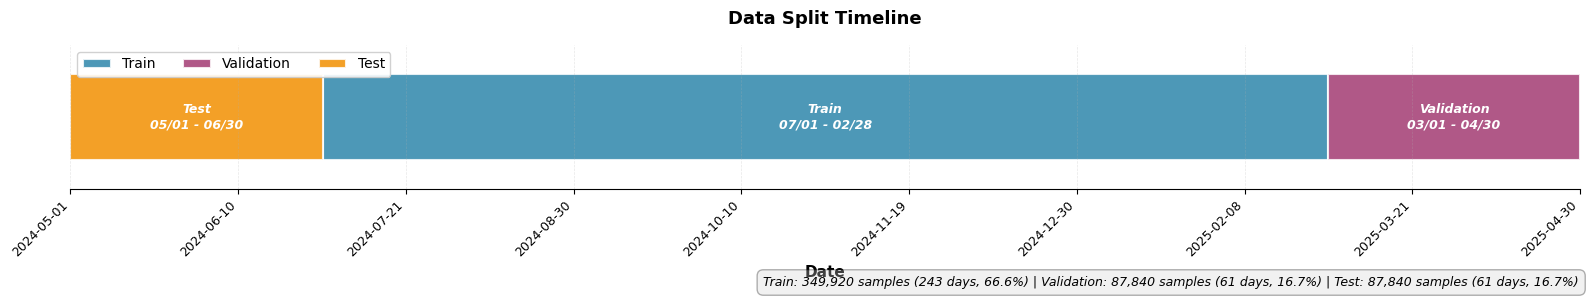

In [19]:
def annualize_factor(sampling: str):
    return ANNUALIZATION.get(sampling, 365*24)

def compute_metrics(equity_curve: pd.Series, sampling: str, turnover_series: pd.Series = None):
    ret = equity_curve.pct_change().dropna()
    ann = annualize_factor(sampling)
    mu = ret.mean() * ann
    sigma = ret.std() * math.sqrt(ann)
    sharpe = mu / (sigma + 1e-12)
    downside = ret[ret < 0].std() * math.sqrt(ann)
    sortino = mu / (downside + 1e-12)
    if len(equity_curve) > 1:
        # Calculate years based on number of samples and sampling frequency
        if isinstance(equity_curve.index, pd.DatetimeIndex):
            dt_years = (equity_curve.index[-1] - equity_curve.index[0]).total_seconds() / (365 * 24 * 3600)
        else:
            # If using RangeIndex, calculate based on sampling frequency
            samples = len(equity_curve)
            samples_per_year = annualize_factor(sampling)
            dt_years = samples / samples_per_year
        dt_years = float(dt_years) if float(dt_years) != 0 else 1e-12
        cagr = (equity_curve.iloc[-1] / equity_curve.iloc[0]) ** (1/dt_years) - 1
    else:
        cagr = 0.0
    cummax = equity_curve.cummax()
    dd = (equity_curve / cummax - 1).min()
    maxdd = float(dd)
    calmar = mu / (abs(maxdd) + 1e-12)
    hit_ratio = (ret > 0).mean()
    turnover = turnover_series.mean() if turnover_series is not None and len(turnover_series)>0 else np.nan
    return {"CAGR": cagr, "Sharpe": sharpe, "Sortino": sortino, "MaxDrawdown": maxdd, "Calmar": calmar, "Volatility": sigma, "Turnover": turnover, "HitRatio": hit_ratio}

def plot_series(series: pd.Series, title: str):
    plt.figure(figsize=(10,4))
    plt.plot(series.index, series.values)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

def plot_splits(time_index: pd.DatetimeIndex, train_mask: np.ndarray, val_mask: np.ndarray, test_mask: np.ndarray = None):
    """Plot timeline showing training, validation, and test periods on a single timeline."""
    fig, ax = plt.subplots(figsize=(16, 3))
    
    # Create segments for each split type
    splits_data = [
        ('Train', train_mask, '#2E86AB', 0.85),
        ('Validation', val_mask, '#A23B72', 0.85),
    ]
    if test_mask is not None:
        splits_data.append(('Test', test_mask, '#F18F01', 0.85))
    
    # All bars at same height (y=0)
    bar_height = 0.6
    
    # Plot each split as a horizontal bar on the same row
    for label, mask, color, alpha in splits_data:
        # Find continuous segments
        mask_diff = np.diff(np.concatenate(([0], mask.astype(int), [0])))
        starts = np.where(mask_diff == 1)[0]
        ends = np.where(mask_diff == -1)[0]
        
        for start, end in zip(starts, ends):
            # Draw horizontal bar for this segment
            ax.barh(y=0, width=end-start, left=start, height=bar_height, 
                   color=color, alpha=alpha, edgecolor='white', linewidth=1.5, label=label)
            
            # Add label in the middle of the segment
            segment_center = (start + end) / 2
            segment_width = end - start
            
            # Only add text label if segment is wide enough
            if segment_width > len(time_index) * 0.05:  # At least 5% of timeline width
                start_date = time_index[start].strftime('%m/%d')
                end_date = time_index[end-1].strftime('%m/%d')
                ax.text(segment_center, 0, f'{label}\n{start_date} - {end_date}', 
                       va='center', ha='center', fontsize=9, color='white', 
                       fontweight='bold', style='italic')
    
    # Remove duplicate labels in legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper left', 
             framealpha=0.9, fontsize=10, ncol=len(by_label))
    
    # Set y-axis (hide it since we only have one row)
    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([])
    
    # Set x-axis ticks to show dates at regular intervals
    num_ticks = 10
    tick_locations = np.linspace(0, len(time_index)-1, num_ticks, dtype=int)
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(time_index[tick_locations].strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=9)
    
    # Styling
    ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax.set_title('Data Split Timeline', fontsize=13, fontweight='bold', pad=15)
    ax.grid(True, axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_xlim(0, len(time_index))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Add summary statistics
    stats_text = []
    for label, mask, _, _ in splits_data:
        n_samples = mask.sum()
        n_days = (time_index[mask][-1] - time_index[mask][0]).days + 1
        pct = (n_samples / len(time_index)) * 100
        stats_text.append(f"{label}: {n_samples:,} samples ({n_days} days, {pct:.1f}%)")
    
    fig.text(0.99, 0.02, ' | '.join(stats_text), 
            ha='right', va='bottom', fontsize=9, style='italic',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.3))
    
    plt.tight_layout()
    plt.show()

def backtest_env(env: gym.Env, model=None, include_leverage: bool = False, include_returns: bool = False):
    # Get the unwrapped environment
    unwrapped = env.unwrapped if hasattr(env, 'unwrapped') else env
    
    obs, _ = env.reset()
    pv, turns, levs, actions, rets = [], [], [], [], []  # Initialize lists for portfolio value, turnover, leverage, actions, and returns
    
    for _ in range(len(unwrapped.R)-1):
        if model is None:
            action = np.array([0.0])  # Default to cash position (action=0)
        else:
            action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _, info = env.step(action)
        pv.append(info["portfolio_value"])
        turns.append(info["turnover"])
        levs.append(info["total_leverage"])  # Track leverage from info dict
        actions.append(info.get("action_taken", action[0] if isinstance(action, np.ndarray) else action))  # Track action taken
        rets.append(info.get("portfolio_log_ret", 0.0))  # Track log returns from info dict
        if done:
            break
            
    idx = pd.RangeIndex(start=0, stop=len(pv), step=1)
    ec = pd.Series(pv, index=idx)
    to = pd.Series(turns, index=idx)
    lev = pd.Series(levs, index=idx)  # Create leverage Series
    act = pd.Series(actions, index=idx)  # Create actions Series
    ret = pd.Series(rets, index=idx)  # Create returns Series
    
    if include_returns:
        return ec, to, lev, act, ret
    if include_leverage:
        return ec, to, lev, act
    return ec, to

print("Visualizing data splits timeline...")
plot_splits(TIME_INDEX, train_mask, val_mask, test_mask)

In [ ]:
# 🔍 PRE-TRAINING DATA VALIDATION
print("="*70)
print("DATA QUALITY CHECK - Detecting NaN/Inf values")
print("="*70)

# Check tensors for NaN/Inf
nan_check = {
    "X_all": {
        "nan_count": np.isnan(X_all).sum(),
        "inf_count": np.isinf(X_all).sum(),
        "shape": X_all.shape,
        "dtype": X_all.dtype
    },
    "R_all": {
        "nan_count": np.isnan(R_all).sum(),
        "inf_count": np.isinf(R_all).sum(),
        "shape": R_all.shape,
        "dtype": R_all.dtype,
        "min": R_all.min(),
        "max": R_all.max(),
        "mean": R_all.mean()
    },
    "VOL_all": {
        "nan_count": np.isnan(VOL_all).sum(),
        "inf_count": np.isinf(VOL_all).sum(),
        "shape": VOL_all.shape,
        "dtype": VOL_all.dtype
    }
}

has_issues = False
for tensor_name, stats in nan_check.items():
    print(f"\n{tensor_name}:")
    print(f"  Shape: {stats['shape']}, Dtype: {stats['dtype']}")
    if 'min' in stats:
        print(f"  Range: [{stats['min']:.6f}, {stats['max']:.6f}], Mean: {stats['mean']:.6f}")
    
    if stats['nan_count'] > 0:
        print(f"  ⚠️  NaN values found: {stats['nan_count']}")
        has_issues = True
    else:
        print(f"  ✓ No NaN values")
    
    if stats['inf_count'] > 0:
        print(f"  ⚠️  Inf values found: {stats['inf_count']}")
        has_issues = True
    else:
        print(f"  ✓ No Inf values")

if has_issues:
    print("\n" + "="*70)
    print("❌ DATA QUALITY ISSUES DETECTED!")
    print("="*70)
    print("\nCannot train with NaN/Inf values - this causes gradient explosion.")
    print("\nFix options:")
    print("  1. Re-run feature engineering cells with proper handling")
    print("  2. Check data preprocessing for missing values")
    print("  3. Verify return calculations don't produce invalid values")
    raise ValueError("Training data contains NaN or Inf values")
else:
    print("\n" + "="*70)
    print("✅ DATA QUALITY CHECK PASSED")
    print("="*70)
    print("All tensors are valid - ready for training!\n")

In [20]:
# Check the final concatenated tensors (all_X, all_R, all_VOL were deleted for memory efficiency)
print("Final tensors after concatenation:")
print(f"X_all shape: {X_all.shape}")
print(f"R_all shape: {R_all.shape}")
print(f"VOL_all shape: {VOL_all.shape}")
print(f"\nall_pairs length: {len(all_pairs)}")
print(f"SAMPLE_TIMESTAMPS length: {len(SAMPLE_TIMESTAMPS)}")
print(f"\ntimestamps variable (from last iteration): type={type(timestamps)}, length={len(timestamps)}")
if len(timestamps) > 0:
    print(f"First 5 timestamps from last iteration: {timestamps[:5]}")
print(f"\nSAMPLE_TIMESTAMPS range: {SAMPLE_TIMESTAMPS.min()} to {SAMPLE_TIMESTAMPS.max()}")

Final tensors after concatenation:
X_all shape: (2520854, 1, 32, 20)
R_all shape: (2520854, 2)
VOL_all shape: (2520854, 1)

all_pairs length: 2520854
SAMPLE_TIMESTAMPS length: 2520854

timestamps variable (from last iteration): type=<class 'list'>, length=1421
First 5 timestamps from last iteration: [Timestamp('2025-04-13 00:20:00+0000', tz='UTC'), Timestamp('2025-04-13 00:21:00+0000', tz='UTC'), Timestamp('2025-04-13 00:22:00+0000', tz='UTC'), Timestamp('2025-04-13 00:23:00+0000', tz='UTC'), Timestamp('2025-04-13 00:24:00+0000', tz='UTC')]

SAMPLE_TIMESTAMPS range: 2024-05-04 00:20:00+00:00 to 2025-04-30 00:00:00+00:00


Slicing: 1698094 samples out of 2520854 fall in range 2024-07-01 00:00:00+00:00 to 2025-02-28 23:59:00+00:00

Validating data for environment 'DateSplit_train'...

Validating data for environment 'DateSplit_train'...
⚠ WARNING: Very large volatility in V_s (max: 28.97)
✓ Data validation complete for 'DateSplit_train'
⚠ WARNING: Very large volatility in V_s (max: 28.97)
✓ Data validation complete for 'DateSplit_train'
  X: shape=(1698094, 1, 32, 20), range=[-33.6430, 29234.4453]
  R: shape=(1698094, 2), range=[-0.1238, 0.0903]
  V: shape=(1698094, 1), range=[0.0000, 28.9668]
Slicing: 417779 samples out of 2520854 fall in range 2025-03-01 00:00:00+00:00 to 2025-04-30 23:59:00+00:00
  X: shape=(1698094, 1, 32, 20), range=[-33.6430, 29234.4453]
  R: shape=(1698094, 2), range=[-0.1238, 0.0903]
  V: shape=(1698094, 1), range=[0.0000, 28.9668]
Slicing: 417779 samples out of 2520854 fall in range 2025-03-01 00:00:00+00:00 to 2025-04-30 23:59:00+00:00

Validating data for environment 'DateSplit

Output()


Starting PPO training for 4000000.0 timesteps...
Using spreadNorm (z-score) for mean reversion signals
Transaction costs: 1.44 bps taker fee + 0 bps slippage

⚠️  MEMORY TIP: Close unused notebooks/terminals to free RAM during long training
   Monitor: Activity Monitor (Mac) or Task Manager (Windows)



Checkpoint saved at step 144000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 288000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 432000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 576000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 720000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 864000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 1008000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 1152000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 1296000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 1440000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 1584000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 1728000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 1872000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 2016000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 2160000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 2304000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 2448000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 2592000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 2736000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 2880000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 3024000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 3168000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 3312000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 3456000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 3600000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 3744000 to ./models/ppo_checkpoint_DateSplit_current.zip

Checkpoint saved at step 3888000 to ./models/ppo_checkpoint_DateSplit_current.zip

Final model saved to ./models/final_model.zip

Backtesting on training set...
Backtesting equal-weight baseline...
Backtesting equal-weight baseline...

Completed split: DateSplit
PPO Model Sharpe: -0.2953
Equal-Weight Sharpe: 0.0000

Completed split: DateSplit
PPO Model Sharpe: -0.2953
Equal-Weight Sharpe: 0.0000


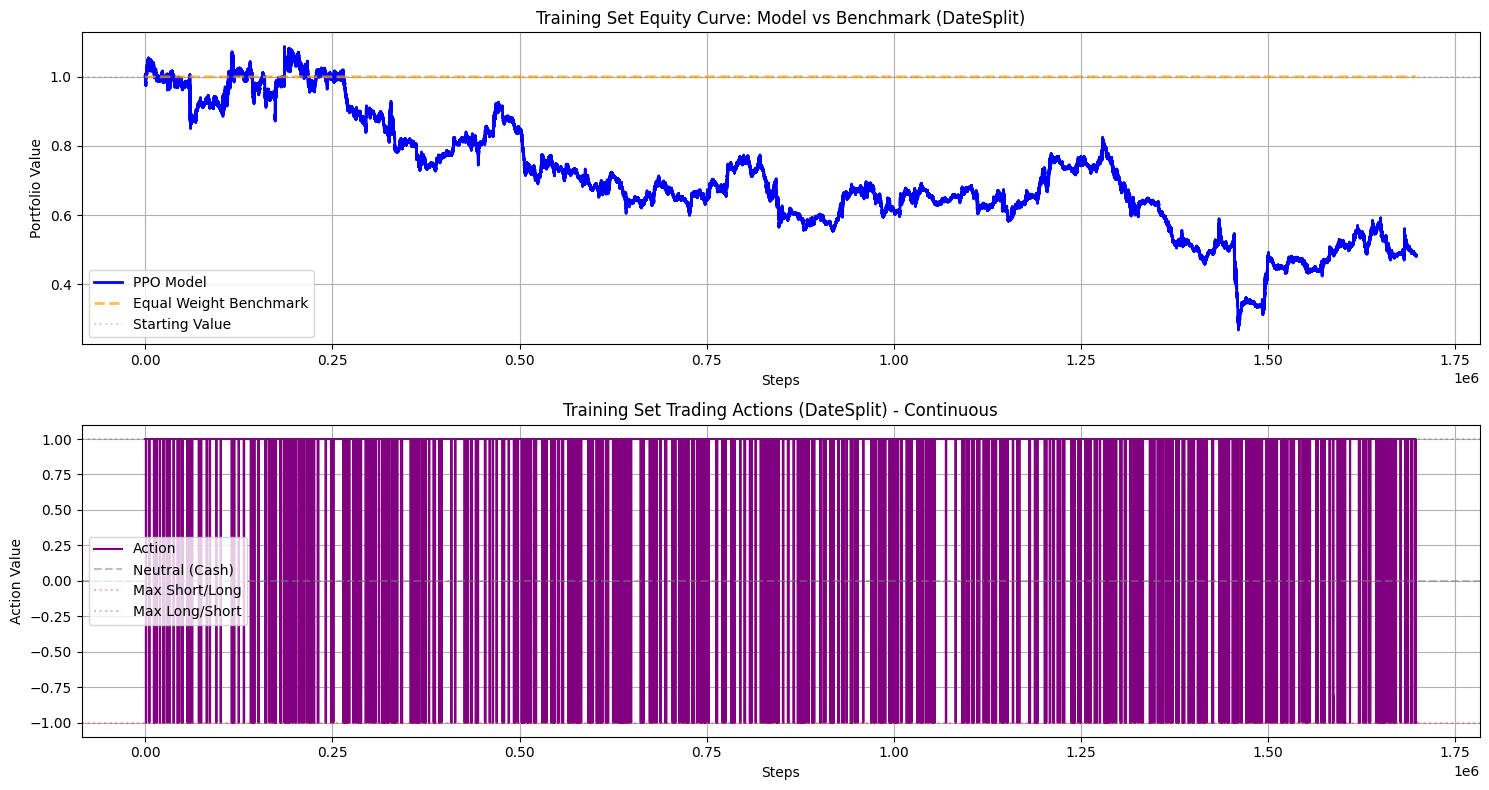

In [21]:
ensure_dir(CONFIG["IO"]["models_dir"])
ensure_dir(CONFIG["EVAL"]["reports_dir"])

# Check if required tensors exist
if 'X_all' not in globals() or 'R_all' not in globals() or 'VOL_all' not in globals() or 'SAMPLE_TIMESTAMPS' not in globals():
    raise NameError(
        "Required tensors (X_all, R_all, VOL_all, SAMPLE_TIMESTAMPS) not found!\n"
        "Please run the tensor construction cell (cell 29) before running this cell.\n"
        "The cell starts with: def build_state_tensor_for_interval..."
    )

RESULTS = []

for split in SPLITS:
    train_env = make_env_from_mask(split["train"], name=f"{split['name']}_train")
    val_env = make_env_from_mask(split["val"], name=f"{split['name']}_val")

    vec_train = DummyVecEnv([lambda env=train_env: env])
    vec_val = DummyVecEnv([lambda env=val_env: env])

    # Get algorithm and action space from config
    algorithm = CONFIG["RL"].get("algorithm", "PPO")
    action_space_type = CONFIG["ENV"].get("action_space_type", "continuous")
    
    print(f"\n{'='*60}")
    print(f"Training {algorithm} model for split: {split['name']}")
    print(f"Action space: {action_space_type}")
    if action_space_type == "discrete":
        print(f"Discrete actions: {CONFIG['ENV']['discrete_actions']}")
    print(f"{'='*60}")
    
    # Create PPO model with correct parameters
    model = PPO(
        policy=CONFIG["RL"]["policy"],
        env=vec_train,
        learning_rate=CONFIG["RL"]["learning_rate"],
        n_steps=CONFIG["RL"]["n_steps"],
        batch_size=CONFIG["RL"]["batch_size"],
        n_epochs=CONFIG["RL"]["n_epochs"],
        gamma=CONFIG["RL"]["gamma"],
        gae_lambda=CONFIG["RL"]["gae_lambda"],
        clip_range=CONFIG["RL"]["clip_range"],
        ent_coef=CONFIG["RL"]["ent_coef"],
        vf_coef=CONFIG["RL"]["vf_coef"],
        max_grad_norm=CONFIG["RL"]["max_grad_norm"],
        tensorboard_log=CONFIG["IO"]["tb_logdir"],
        device="cpu",
        verbose=0
    )

    # Checkpoint callback to save model periodically during training
    class CheckpointCallback(BaseCallback):
        def __init__(self, save_freq: int, save_path: str, name_prefix: str = "checkpoint", verbose: int = 1):
            super().__init__(verbose)
            self.save_freq = save_freq
            self.save_path = save_path
            self.name_prefix = name_prefix

        def _on_step(self) -> bool:
            if self.n_calls % self.save_freq == 0:
                checkpoint_path = os.path.join(self.save_path, f"{self.name_prefix}_current.zip")
                self.model.save(checkpoint_path)
                if self.verbose > 0:
                    print(f"Checkpoint saved at step {self.num_timesteps} to {checkpoint_path}")
            return True

    # Create callbacks
    eval_callback = EvalCallback(
        vec_val,
        best_model_save_path=CONFIG["IO"]["models_dir"],
        log_path=CONFIG["IO"]["models_dir"],
        eval_freq=CONFIG["EVAL"]["frequency"],
        n_eval_episodes=CONFIG["EVAL"]["n_eval_episodes"],
        deterministic=True,
        render=False,
        verbose=0
    )
    
    checkpoint_callback = CheckpointCallback(
        save_freq=CONFIG["EVAL"].get("save_freq", 100000),
        save_path=CONFIG["IO"]["models_dir"],
        name_prefix=f"{algorithm.lower()}_checkpoint_{split['name']}"
    )
    
    callback = CallbackList([eval_callback, checkpoint_callback])

    print(f"\nStarting {algorithm} training for {CONFIG['RL']['timesteps']} timesteps...")
    print("Using spreadNorm (z-score) for mean reversion signals")
    print(f"Transaction costs: {CONFIG['ENV']['transaction_costs']['taker_bps']} bps taker fee + {CONFIG['ENV']['transaction_costs']['slippage_bps']} bps slippage")
    if action_space_type == "discrete":
        print("Discrete actions reduce overtrading by forcing significant position jumps")
    
    print("\n⚠️  MEMORY TIP: Close unused notebooks/terminals to free RAM during long training")
    print("   Monitor: Activity Monitor (Mac) or Task Manager (Windows)\n")
    
    # Memory cleanup before training
    import gc
    gc.collect()
    
    # Train with explicit error handling and checkpointing
    try:
        model.learn(total_timesteps=int(CONFIG["RL"]["timesteps"]), callback=callback, progress_bar=True)
    except KeyboardInterrupt:
        print("\n⚠️  Training interrupted by user")
        print("   Saving checkpoint...")
        checkpoint_path = os.path.join(CONFIG["IO"]["models_dir"], f"{algorithm.lower()}_interrupted_{split['name']}.zip")
        model.save(checkpoint_path)
        print(f"   ✓ Checkpoint saved to: {checkpoint_path}")
        raise
    except Exception as e:
        print(f"\n❌ Training error: {e}")
        print("   Attempting to save emergency checkpoint...")
        try:
            emergency_path = os.path.join(CONFIG["IO"]["models_dir"], f"{algorithm.lower()}_emergency_{split['name']}.zip")
            model.save(emergency_path)
            print(f"   ✓ Emergency checkpoint saved to: {emergency_path}")
        except:
            print("   ✗ Could not save emergency checkpoint")
        raise
    finally:
        # Clean up memory after training
        gc.collect()

    final_path = os.path.join(CONFIG["IO"]["models_dir"], "final_model.zip")
    model.save(final_path)
    print(f"Final model saved to {final_path}")

    # Backtest training environment
    print("\nBacktesting on training set...")
    ec_train, to_train, lev_train, act_train = backtest_env(train_env, model=model, include_leverage=True)
    m_model = compute_metrics(ec_train, CONFIG["DATA"]["sampling"], to_train)

    # Backtest equal-weight baseline
    print("Backtesting equal-weight baseline...")
    ec_ew, to_ew, lev_ew, act_ew = backtest_env(train_env, model=None, include_leverage=True)
    m_ew = compute_metrics(ec_ew, CONFIG["DATA"]["sampling"], to_ew)

    # Calculate additional leverage metrics
    model_avg_lev = lev_train.mean()
    model_max_lev = lev_train.max()

    res = {
        "split": split["name"],
        "model_CAGR": m_model["CAGR"],
        "model_Sharpe": m_model["Sharpe"],
        "model_Sortino": m_model["Sortino"],
        "model_Calmar": m_model["Calmar"],
        "model_MaxDrawdown": m_model["MaxDrawdown"],
        "model_Volatility": m_model["Volatility"],
        "model_Turnover": m_model["Turnover"],
        "model_HitRatio": m_model["HitRatio"],
        "model_Avg_Leverage": model_avg_lev,
        "model_Max_Leverage": model_max_lev,
        "equal_weight_CAGR": m_ew["CAGR"],
        "equal_weight_Sharpe": m_ew["Sharpe"],
        "equal_weight_Sortino": m_ew["Sortino"],
        "equal_weight_Calmar": m_ew["Calmar"],
        "equal_weight_MaxDrawdown": m_ew["MaxDrawdown"],
        "equal_weight_Volatility": m_ew["Volatility"],
        "equal_weight_Turnover": m_ew["Turnover"],
        "equal_weight_HitRatio": m_ew["HitRatio"],
    }
    RESULTS.append(res)
    print(f"\nCompleted split: {split['name']}")
    print(f"{algorithm} Model Sharpe: {m_model['Sharpe']:.4f}")
    print(f"Equal-Weight Sharpe: {m_ew['Sharpe']:.4f}")

    # Plot training results
    if CONFIG["EVAL"]["plots"]:
        plt.figure(figsize=(15, 8))

        # Plot equity curves - Model vs Equal Weight Benchmark
        plt.subplot(2, 1, 1)
        plt.plot(ec_train.index, ec_train.values, label=f'{algorithm} Model', color='blue', linewidth=2)
        plt.plot(ec_ew.index, ec_ew.values, label='Equal Weight Benchmark', color='orange', linewidth=2, linestyle='--', alpha=0.7)
        plt.axhline(y=1.0, color='gray', linestyle=':', alpha=0.3, label='Starting Value')
        plt.title(f"Training Set Equity Curve: Model vs Benchmark ({split['name']})")
        plt.xlabel("Steps")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.grid(True)

        # Plot actions
        plt.subplot(2, 1, 2)
        plt.plot(act_train.index, act_train.values, label='Action', drawstyle='steps-post', color='purple')
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Neutral (Cash)')
        plt.axhline(y=-1, color='red', linestyle=':', alpha=0.3, label='Max Short/Long')
        plt.axhline(y=1, color='green', linestyle=':', alpha=0.3, label='Max Long/Short')
        plt.ylim(-1.1, 1.1)
        plt.title(f"Training Set Trading Actions ({split['name']}) - {action_space_type.capitalize()}")
        plt.xlabel("Steps")
        plt.ylabel("Action Value")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

df_results = pd.DataFrame(RESULTS)

In [23]:
# Create a DataFrame with all results (already flattened in RESULTS)
df_results = pd.DataFrame(RESULTS)

# Reorder columns to group related metrics together
column_order = ['split']
for model_type in ['model', 'equal_weight']:
    for metric in ['CAGR', 'Sharpe', 'Sortino', 'Calmar', 'MaxDrawdown', 'Volatility', 'Turnover', 'HitRatio']:
        col = f"{model_type}_{metric}"
        if col in df_results.columns:
            column_order.append(col)
    # Add leverage metrics for model only
    if model_type == 'model':
        for metric in ['Avg_Leverage', 'Max_Leverage']:
            col = f"{model_type}_{metric}"
            if col in df_results.columns:
                column_order.append(col)

df_results = df_results[column_order]

# Format only numeric columns, leave 'split' column as-is
format_dict = {col: "{:.4f}" for col in df_results.columns if col != 'split'}
display(df_results.style.format(format_dict))

,split,model_CAGR,model_Sharpe,model_Sortino,model_Calmar,model_MaxDrawdown,model_Volatility,model_Turnover,model_HitRatio,model_Avg_Leverage,model_Max_Leverage,equal_weight_CAGR,equal_weight_Sharpe,equal_weight_Sortino,equal_weight_Calmar,equal_weight_MaxDrawdown,equal_weight_Volatility,equal_weight_Turnover,equal_weight_HitRatio
0,DateSplit,-0.2016,-0.2953,-0.3687,-0.1714,-0.7545,0.4379,0.0018,0.4963,0.9998,1.0000,0.0000,0.0000,nan,0.0000,0.0000,0.0000,0.0000,0.0000


## 🛡️ Preventing VS Code Crashes During Long Training

### **Common Causes & Solutions:**

#### **1. Memory Exhaustion (Primary Cause)**
VS Code + Jupyter extension + training models can consume 8-16GB+ RAM.

**Solutions:**
- ✅ **Close unused notebooks** before training (File → Close Editor)
- ✅ **Restart Jupyter kernel** periodically: Restart icon in notebook toolbar
- ✅ **Monitor memory**: Activity Monitor (Mac) / Task Manager (Windows)
- ✅ **Reduce `n_eval_episodes`**: Already set to 1 in config (was 5)
- ✅ **More frequent checkpoints**: `save_freq` now 72k (was 144k)

#### **2. Run Training Outside Notebook (Recommended)**
**Best practice for 4M timestep training:**
```bash
# In terminal (separate from VS Code)
cd /Users/lazaro/Downloads/defi-ai
python3 rl_class.py  # Or create training script
```

**Advantages:**
- ✅ No VS Code/Jupyter overhead (~2-4GB RAM saved)
- ✅ Can close VS Code entirely
- ✅ Runs in background (use `nohup` or `tmux`)
- ✅ Faster (~10-20% speed improvement)

#### **3. Alternative: Use Google Colab / Paperspace**
Upload notebook to cloud with better resources:
- Free tier: 12GB RAM
- Pro tier: 25GB+ RAM
- No local resource limitations

#### **4. Reduce Training Load**
If crashes persist:
```python
# In config.py
"timesteps": 2e6,  # Reduce from 4e6
"n_steps": 1024,   # Reduce from 2048
"batch_size": 32,  # Reduce from 64
```

#### **5. Enable Auto-Recovery**
The training cell now includes:
- ✅ **KeyboardInterrupt** handler (Ctrl+C saves checkpoint)
- ✅ **Exception** handler (automatic emergency save)
- ✅ **Memory cleanup** (garbage collection before/after)

**To resume from checkpoint:**
```python
model = PPO.load("./models/ppo_interrupted_split_0.zip")
model.set_env(vec_train)
model.learn(total_timesteps=remaining_steps, callback=callback)
```

---

### **Monitoring During Training:**
```python
# Watch memory in real-time (Mac)
watch -n 5 'ps aux | grep python | head -5'

# Or use htop/top
htop -p $(pgrep -f python)
```

**Signs of impending crash:**
- Memory usage >90%
- Swap memory growing rapidly
- System becoming unresponsive
- VS Code freezing/lagging

**Emergency actions:**
1. Press `Ctrl+C` to trigger graceful shutdown
2. Checkpoint will auto-save
3. Restart kernel and resume training

In [24]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
ensure_dir(CONFIG["EVAL"]["reports_dir"])
out_json = os.path.join(CONFIG["EVAL"]["reports_dir"], f"metrics_{ts}.json")
out_csv  = os.path.join(CONFIG["EVAL"]["reports_dir"], f"metrics_{ts}.csv")
df_results.to_csv(out_csv, index=False)
with open(out_json, "w") as f:
    json.dump(RESULTS, f, indent=2)
print("Saved:", out_json, "and", out_csv)

Saved: ./reports/metrics_20251211_150025.json and ./reports/metrics_20251211_150025.csv


Loading model from: ./models/best_model.zip
Slicing: 404981 samples out of 2520854 fall in range 2024-05-01 00:00:00+00:00 to 2024-06-30 23:59:00+00:00
Slicing: 404981 samples out of 2520854 fall in range 2024-05-01 00:00:00+00:00 to 2024-06-30 23:59:00+00:00

Validating data for environment 'test_backtest'...

Validating data for environment 'test_backtest'...
⚠ WARNING: Very large volatility in V_s (max: 20.22)
✓ Data validation complete for 'test_backtest'
  X: shape=(404981, 1, 32, 20), range=[-23.1273, 7564.9917]
  R: shape=(404981, 2), range=[-0.0943, 0.0378]
  V: shape=(404981, 1), range=[0.0000, 20.2210]

Running backtest on test set...
⚠ WARNING: Very large volatility in V_s (max: 20.22)
✓ Data validation complete for 'test_backtest'
  X: shape=(404981, 1, 32, 20), range=[-23.1273, 7564.9917]
  R: shape=(404981, 2), range=[-0.0943, 0.0378]
  V: shape=(404981, 1), range=[0.0000, 20.2210]

Running backtest on test set...

Backtest completed!
Test period: 2024-05-01 00:00:00 to 2

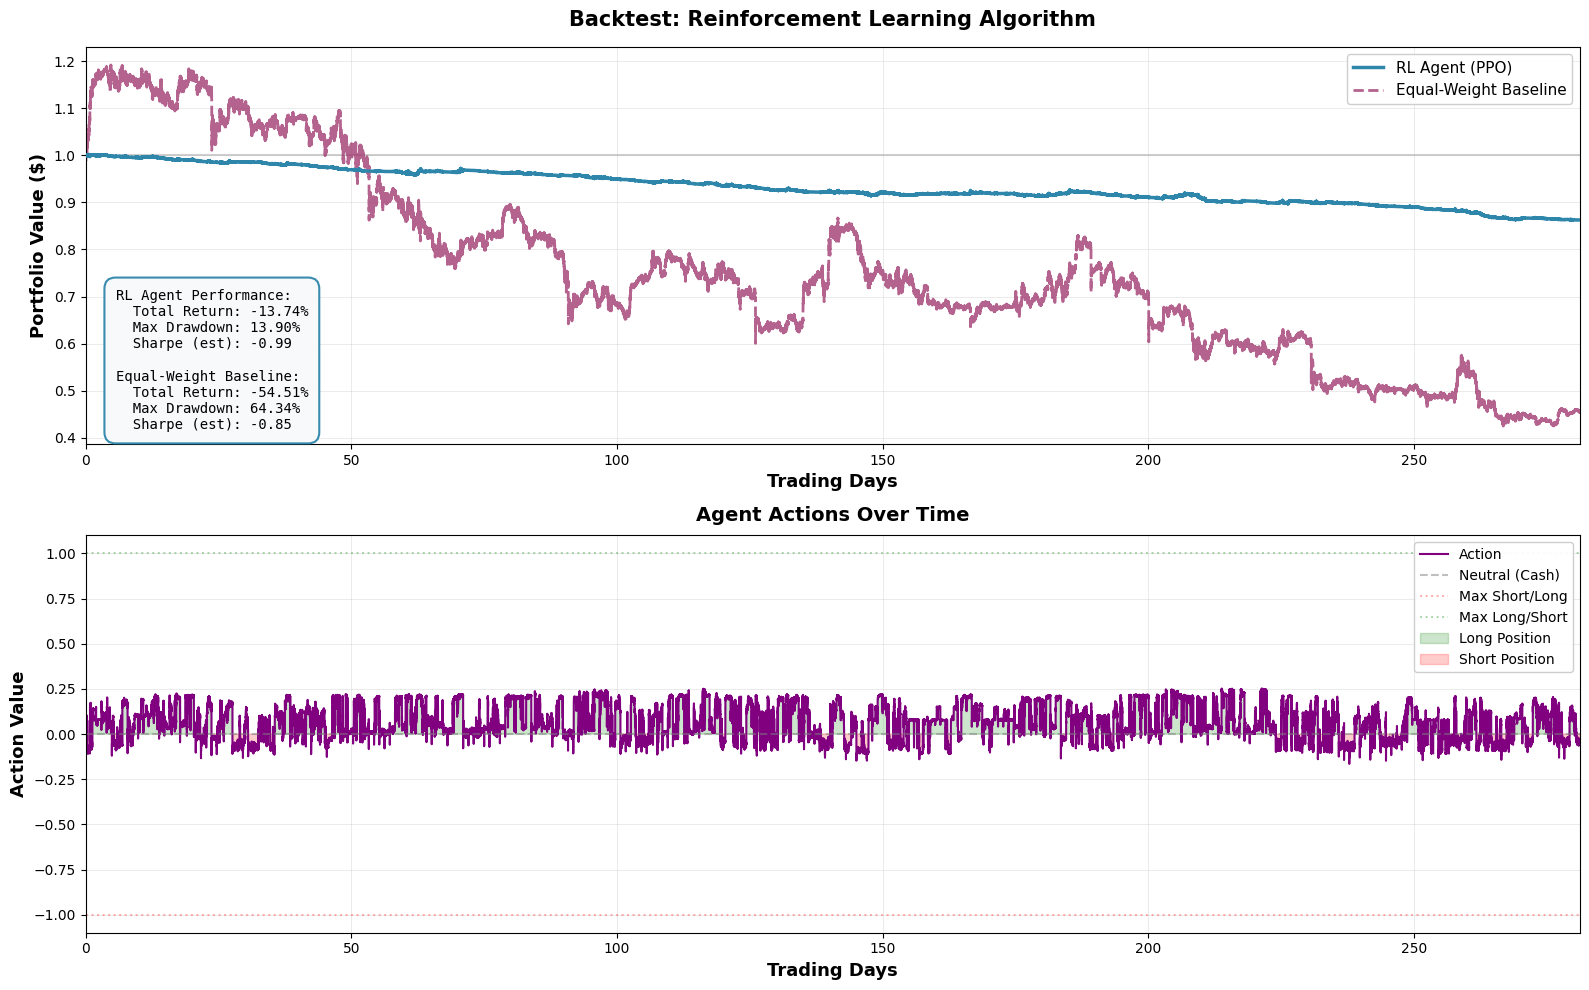


DETAILED BACKTEST STATISTICS

Portfolio Metrics:
  Starting Value:        1.0000
  Ending Value:          0.8626
  Total Return:          -13.74%
  Max Drawdown:          13.90%
  Volatility (Returns):  0.000049

Trading Statistics:
  Average Action:        0.0676
  Action Std Dev:        0.0938
  Action Range:          [-0.1654, 0.2526]
  Average Leverage:      0.0937
  Average Turnover:      0.0017

Benchmark Metrics:
  Final Value:           0.4549
  Total Return:          -54.51%
  Max Drawdown:          64.34%

Relative Performance:
  Outperformance:        40.77%
  Return Ratio:          1.8961x


In [25]:
# Load the best trained model
best_split = SPLITS[0]
model_path = os.path.join(CONFIG["IO"]["models_dir"], "best_model.zip")

# Check if best model exists, otherwise use the split model
if not os.path.exists(model_path):
    #model_path = os.path.join(CONFIG["IO"]["models_dir"], f"ppo_{best_split['name']}.zip")
    model_path = os.path.join(CONFIG["IO"]["models_dir"], "final_model.zip")

print(f"Loading model from: {model_path}")
model = PPO.load(model_path)

# Create test environment
test_env = make_env_from_mask(best_split["test"], name="test_backtest")

# Run backtest
print("\nRunning backtest on test set...")
ec, to, lev, act = backtest_env(test_env, model=model, include_leverage=True)

# Calculate equal weight benchmark for comparison
base_env = test_env.unwrapped if hasattr(test_env, "unwrapped") else test_env
raw_returns = np.asarray(base_env.R)
if raw_returns.ndim == 1:
    raw_returns = raw_returns.reshape(-1, 1)

steps = min(len(ec.index) - 1, raw_returns.shape[0])
if raw_returns.shape[1] == 0 or steps <= 0:
    ec_bench = pd.Series(np.ones(len(ec.index)), index=ec.index)
else:
    ew = np.ones(raw_returns.shape[1]) / raw_returns.shape[1]
    ec_bench = [1.0]
    for i in range(steps):
        step_ret = float(np.dot(ew, raw_returns[i].reshape(-1)))
        ec_bench.append(ec_bench[-1] * math.exp(step_ret))
    if len(ec_bench) < len(ec.index):
        ec_bench.extend([ec_bench[-1]] * (len(ec.index) - len(ec_bench)))
    ec_bench = pd.Series(ec_bench[:len(ec.index)], index=ec.index)

# Get test period dates
test_period_start = CONFIG["SPLITS"]["test"][0]
test_period_end = CONFIG["SPLITS"]["test"][1]

print("\nBacktest completed!")
print(f"Test period: {test_period_start} to {test_period_end}")
print(f"Total steps: {len(ec)}")
print(f"Model final value: {ec.iloc[-1]:.4f} ({(ec.iloc[-1] - 1) * 100:.2f}%)")
print(f"Benchmark final value: {ec_bench.iloc[-1]:.4f} ({(ec_bench.iloc[-1] - 1) * 100:.2f}%)")
print(f"Average leverage: {lev.mean():.4f}")
print(f"Average turnover: {to.mean():.4f}")

# Create visualization with improved labeling
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Convert steps to days (1 step = 1 minute)
minutes_per_day = 24 * 60
days = ec.index / minutes_per_day
days_bench = ec_bench.index / minutes_per_day

# Calculate performance metrics
final_value = ec.iloc[-1]
total_return = (final_value - 1) * 100
max_drawdown = (ec / ec.cummax() - 1).min()
bench_return = (ec_bench.iloc[-1] - 1) * 100
bench_max_drawdown = (ec_bench / ec_bench.cummax() - 1).min()
total_days = len(ec) / minutes_per_day

# Plot 1: Portfolio Value - Model vs Benchmark
ax = axes[0]
ax.plot(days, ec.values, label='RL Agent (PPO)', color='#2E86AB', linewidth=2.5, zorder=3)
ax.plot(days_bench, ec_bench.values, label='Equal-Weight Baseline', 
        color='#A23B72', linewidth=2, linestyle='--', alpha=0.8, zorder=2)
ax.axhline(y=1.0, color='#888888', linestyle='-', linewidth=1.5, alpha=0.4, zorder=1)
ax.set_title('Backtest: Reinforcement Learning Algorithm', 
             fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('Trading Days', fontsize=13, fontweight='600')
ax.set_ylabel('Portfolio Value ($)', fontsize=13, fontweight='600')
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.25, linestyle='-', linewidth=0.7)
ax.set_xlim(0, total_days)

# Add performance metrics box with better formatting (moved to lower left)
metrics_text = (f'RL Agent Performance:\n'
                f'  Total Return: {total_return:+.2f}%\n'
                f'  Max Drawdown: {abs(max_drawdown) * 100:.2f}%\n'
                f'  Sharpe (est): {(total_return / (abs(max_drawdown) * 100 + 1e-6)):.2f}\n'
                f'\n'
                f'Equal-Weight Baseline:\n'
                f'  Total Return: {bench_return:+.2f}%\n'
                f'  Max Drawdown: {abs(bench_max_drawdown) * 100:.2f}%\n'
                f'  Sharpe (est): {(bench_return / (abs(bench_max_drawdown) * 100 + 1e-6)):.2f}')
ax.text(0.02, 0.03, metrics_text, transform=ax.transAxes, 
        fontsize=10, verticalalignment='bottom', family='monospace',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='#F7F9FB', 
                 edgecolor='#2E86AB', linewidth=1.5, alpha=0.95))

# Plot 2: Actions Over Time
ax = axes[1]
days_act = act.index / minutes_per_day
ax.plot(days_act, act.values, label='Action', drawstyle='steps-post', color='purple', linewidth=1.5)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Neutral (Cash)')
ax.axhline(y=-1, color='red', linestyle=':', alpha=0.3, label='Max Short/Long')
ax.axhline(y=1, color='green', linestyle=':', alpha=0.3, label='Max Long/Short')
ax.fill_between(days_act, act.values, 0, where=(act.values > 0), 
                alpha=0.2, color='green', interpolate=True, label='Long Position')
ax.fill_between(days_act, act.values, 0, where=(act.values < 0), 
                alpha=0.2, color='red', interpolate=True, label='Short Position')
ax.set_xlabel('Trading Days', fontsize=13, fontweight='600')
ax.set_ylabel('Action Value', fontsize=13, fontweight='600')
ax.set_title('Agent Actions Over Time', fontsize=14, fontweight='bold', pad=10)
ax.legend(fontsize=10, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.25, linestyle='-', linewidth=0.7)
ax.set_xlim(0, total_days)
ax.set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.show()
plt.close(fig)

# Print detailed statistics
print("\n" + "="*60)
print("DETAILED BACKTEST STATISTICS")
print("="*60)
print("\nPortfolio Metrics:")
print("  Starting Value:        1.0000")
print(f"  Ending Value:          {ec.iloc[-1]:.4f}")
print(f"  Total Return:          {(ec.iloc[-1] - 1) * 100:.2f}%")
print(f"  Max Drawdown:          {abs(max_drawdown) * 100:.2f}%")
print(f"  Volatility (Returns):  {ec.pct_change().std():.6f}")

print("\nTrading Statistics:")
print(f"  Average Action:        {act.mean():.4f}")
print(f"  Action Std Dev:        {act.std():.4f}")
print(f"  Action Range:          [{act.min():.4f}, {act.max():.4f}]")
print(f"  Average Leverage:      {lev.mean():.4f}")
print(f"  Average Turnover:      {to.mean():.4f}")

print("\nBenchmark Metrics:")
print(f"  Final Value:           {ec_bench.iloc[-1]:.4f}")
print(f"  Total Return:          {(ec_bench.iloc[-1] - 1) * 100:.2f}%")
print(f"  Max Drawdown:          {abs(bench_max_drawdown) * 100:.2f}%")

print("\nRelative Performance:")
print(f"  Outperformance:        {(ec.iloc[-1] - ec_bench.iloc[-1]) * 100:.2f}%")
print(f"  Return Ratio:          {ec.iloc[-1] / ec_bench.iloc[-1]:.4f}x")

Loading model from: ./models/best_model.zip
Slicing: 404981 samples out of 2520854 fall in range 2024-05-01 00:00:00+00:00 to 2024-06-30 23:59:00+00:00

Validating data for environment 'test_backtest'...

Validating data for environment 'test_backtest'...
⚠ WARNING: Very large volatility in V_s (max: 20.22)
✓ Data validation complete for 'test_backtest'
  X: shape=(404981, 1, 32, 20), range=[-23.1273, 7564.9917]
  R: shape=(404981, 2), range=[-0.0943, 0.0378]
  V: shape=(404981, 1), range=[0.0000, 20.2210]
⚠ WARNING: Very large volatility in V_s (max: 20.22)
✓ Data validation complete for 'test_backtest'
  X: shape=(404981, 1, 32, 20), range=[-23.1273, 7564.9917]
  R: shape=(404981, 2), range=[-0.0943, 0.0378]
  V: shape=(404981, 1), range=[0.0000, 20.2210]

Running backtest on test set...

Running backtest on test set...

Backtest completed!
Test period: 2024-05-01 00:00:00 to 2024-06-30 23:59:59
Total steps: 404980
Model final value: 0.8626 (-13.74%)
Benchmark final value: 0.4549 (-5

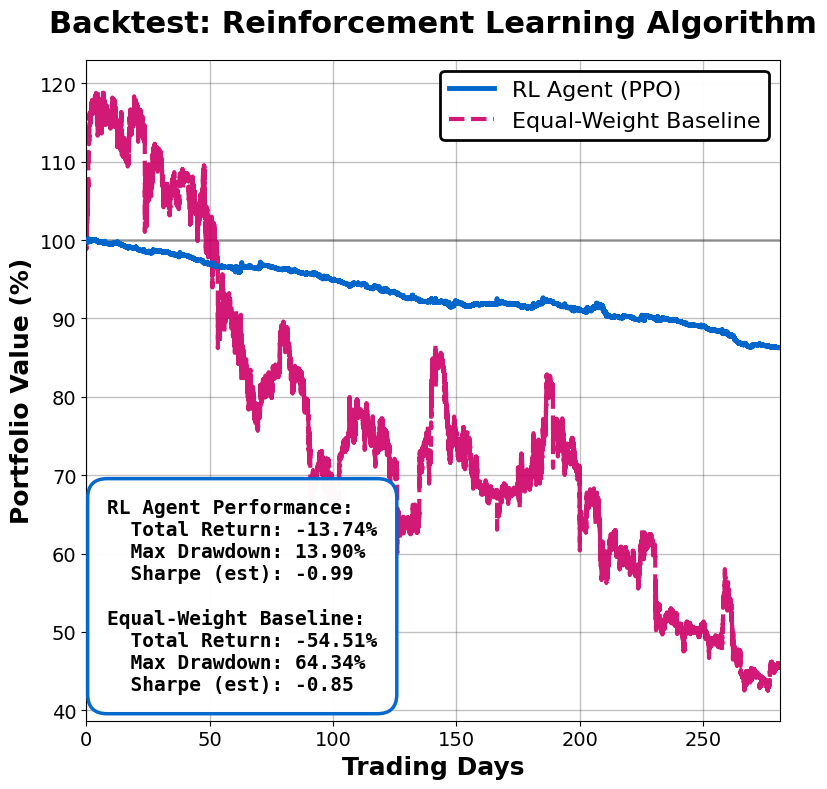


DETAILED BACKTEST STATISTICS

Portfolio Metrics:
  Starting Value:        1.0000
  Ending Value:          0.8626
  Total Return:          -13.74%
  Max Drawdown:          13.90%
  Volatility (Returns):  0.000049

Trading Statistics:
  Average Action:        0.0676
  Action Std Dev:        0.0938
  Action Range:          [-0.1654, 0.2526]
  Average Leverage:      0.0937
  Average Turnover:      0.0017

Benchmark Metrics:
  Final Value:           0.4549
  Total Return:          -54.51%
  Max Drawdown:          64.34%

Relative Performance:
  Outperformance:        40.77%
  Return Ratio:          1.8961x


In [26]:
# Load the best trained model
best_split = SPLITS[0]
model_path = os.path.join(CONFIG["IO"]["models_dir"], "best_model.zip")

# Check if best model exists, otherwise use the split model
if not os.path.exists(model_path):
    #model_path = os.path.join(CONFIG["IO"]["models_dir"], f"ppo_{best_split['name']}.zip")
    model_path = os.path.join(CONFIG["IO"]["models_dir"], "final_model.zip")

print(f"Loading model from: {model_path}")
model = PPO.load(model_path)

# Create test environment
test_env = make_env_from_mask(best_split["test"], name="test_backtest")

# Run backtest
print("\nRunning backtest on test set...")
ec, to, lev, act = backtest_env(test_env, model=model, include_leverage=True)

# Calculate equal weight benchmark for comparison
base_env = test_env.unwrapped if hasattr(test_env, "unwrapped") else test_env
raw_returns = np.asarray(base_env.R)
if raw_returns.ndim == 1:
    raw_returns = raw_returns.reshape(-1, 1)

steps = min(len(ec.index) - 1, raw_returns.shape[0])
if raw_returns.shape[1] == 0 or steps <= 0:
    ec_bench = pd.Series(np.ones(len(ec.index)), index=ec.index)
else:
    ew = np.ones(raw_returns.shape[1]) / raw_returns.shape[1]
    ec_bench = [1.0]
    for i in range(steps):
        step_ret = float(np.dot(ew, raw_returns[i].reshape(-1)))
        ec_bench.append(ec_bench[-1] * math.exp(step_ret))
    if len(ec_bench) < len(ec.index):
        ec_bench.extend([ec_bench[-1]] * (len(ec.index) - len(ec_bench)))
    ec_bench = pd.Series(ec_bench[:len(ec.index)], index=ec.index)

# Get test period dates
test_period_start = CONFIG["SPLITS"]["test"][0]
test_period_end = CONFIG["SPLITS"]["test"][1]

print("\nBacktest completed!")
print(f"Test period: {test_period_start} to {test_period_end}")
print(f"Total steps: {len(ec)}")
print(f"Model final value: {ec.iloc[-1]:.4f} ({(ec.iloc[-1] - 1) * 100:.2f}%)")
print(f"Benchmark final value: {ec_bench.iloc[-1]:.4f} ({(ec_bench.iloc[-1] - 1) * 100:.2f}%)")
print(f"Average leverage: {lev.mean():.4f}")
print(f"Average turnover: {to.mean():.4f}")

# Create visualization with improved labeling - square format with high readability
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Convert steps to days (1 step = 1 minute)
minutes_per_day = 24 * 60
days = ec.index / minutes_per_day
days_bench = ec_bench.index / minutes_per_day

# Calculate performance metrics
final_value = ec.iloc[-1]
total_return = (final_value - 1) * 100
max_drawdown = (ec / ec.cummax() - 1).min()
bench_return = (ec_bench.iloc[-1] - 1) * 100
bench_max_drawdown = (ec_bench / ec_bench.cummax() - 1).min()
total_days = len(ec) / minutes_per_day

# Plot: Portfolio Value - Model vs Benchmark with high contrast (percentage scale)
ax.plot(days, ec.values * 100, label='RL Agent (PPO)', color='#0066CC', linewidth=3.5, zorder=3)
ax.plot(days_bench, ec_bench.values * 100, label='Equal-Weight Baseline', 
        color='#CC0066', linewidth=3, linestyle='--', alpha=0.9, zorder=2)
ax.axhline(y=100, color='#000000', linestyle='-', linewidth=2, alpha=0.3, zorder=1)
ax.set_title('Backtest: Reinforcement Learning Algorithm', 
             fontsize=22, fontweight='bold', pad=20)
ax.set_xlabel('Trading Days', fontsize=18, fontweight='bold')
ax.set_ylabel('Portfolio Value (%)', fontsize=18, fontweight='bold')
legend = ax.legend(fontsize=16, loc='best', framealpha=0.98, edgecolor='black')
legend.get_frame().set_linewidth(2)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=1, color='#333333')
ax.set_xlim(0, total_days)
ax.tick_params(axis='both', which='major', labelsize=14)

# Add performance metrics box with larger font and better contrast
metrics_text = (f'RL Agent Performance:\n'
                f'  Total Return: {total_return:+.2f}%\n'
                f'  Max Drawdown: {abs(max_drawdown) * 100:.2f}%\n'
                f'  Sharpe (est): {(total_return / (abs(max_drawdown) * 100 + 1e-6)):.2f}\n'
                f'\n'
                f'Equal-Weight Baseline:\n'
                f'  Total Return: {bench_return:+.2f}%\n'
                f'  Max Drawdown: {abs(bench_max_drawdown) * 100:.2f}%\n'
                f'  Sharpe (est): {(bench_return / (abs(bench_max_drawdown) * 100 + 1e-6)):.2f}')
ax.text(0.03, 0.04, metrics_text, transform=ax.transAxes, 
        fontsize=14, verticalalignment='bottom', family='monospace', fontweight='bold',
        bbox=dict(boxstyle='round,pad=1.0', facecolor='white', 
                 edgecolor='#0066CC', linewidth=2.5, alpha=0.98))

plt.tight_layout()
plt.show()
plt.close(fig)

# Print detailed statistics
print("\n" + "="*60)
print("DETAILED BACKTEST STATISTICS")
print("="*60)
print("\nPortfolio Metrics:")
print("  Starting Value:        1.0000")
print(f"  Ending Value:          {ec.iloc[-1]:.4f}")
print(f"  Total Return:          {(ec.iloc[-1] - 1) * 100:.2f}%")
print(f"  Max Drawdown:          {abs(max_drawdown) * 100:.2f}%")
print(f"  Volatility (Returns):  {ec.pct_change().std():.6f}")

print("\nTrading Statistics:")
print(f"  Average Action:        {act.mean():.4f}")
print(f"  Action Std Dev:        {act.std():.4f}")
print(f"  Action Range:          [{act.min():.4f}, {act.max():.4f}]")
print(f"  Average Leverage:      {lev.mean():.4f}")
print(f"  Average Turnover:      {to.mean():.4f}")

print("\nBenchmark Metrics:")
print(f"  Final Value:           {ec_bench.iloc[-1]:.4f}")
print(f"  Total Return:          {(ec_bench.iloc[-1] - 1) * 100:.2f}%")
print(f"  Max Drawdown:          {abs(bench_max_drawdown) * 100:.2f}%")

print("\nRelative Performance:")
print(f"  Outperformance:        {(ec.iloc[-1] - ec_bench.iloc[-1]) * 100:.2f}%")
print(f"  Return Ratio:          {ec.iloc[-1] / ec_bench.iloc[-1]:.4f}x")

Loading model from: ./models/best_model.zip
Slicing: 404981 samples out of 2520854 fall in range 2024-05-01 00:00:00+00:00 to 2024-06-30 23:59:00+00:00

Validating data for environment 'test_backtest'...

Validating data for environment 'test_backtest'...
⚠ WARNING: Very large volatility in V_s (max: 20.22)
✓ Data validation complete for 'test_backtest'
  X: shape=(404981, 1, 32, 20), range=[-23.1273, 7564.9917]
  R: shape=(404981, 2), range=[-0.0943, 0.0378]
  V: shape=(404981, 1), range=[0.0000, 20.2210]

Running backtest on test set...
⚠ WARNING: Very large volatility in V_s (max: 20.22)
✓ Data validation complete for 'test_backtest'
  X: shape=(404981, 1, 32, 20), range=[-23.1273, 7564.9917]
  R: shape=(404981, 2), range=[-0.0943, 0.0378]
  V: shape=(404981, 1), range=[0.0000, 20.2210]

Running backtest on test set...

Backtest completed!
Test period: 2024-05-01 00:00:00 to 2024-06-30 23:59:59
Total steps: 404980
Model final value: 0.8626 (-13.74%)
Benchmark final value: 0.4549 (-5

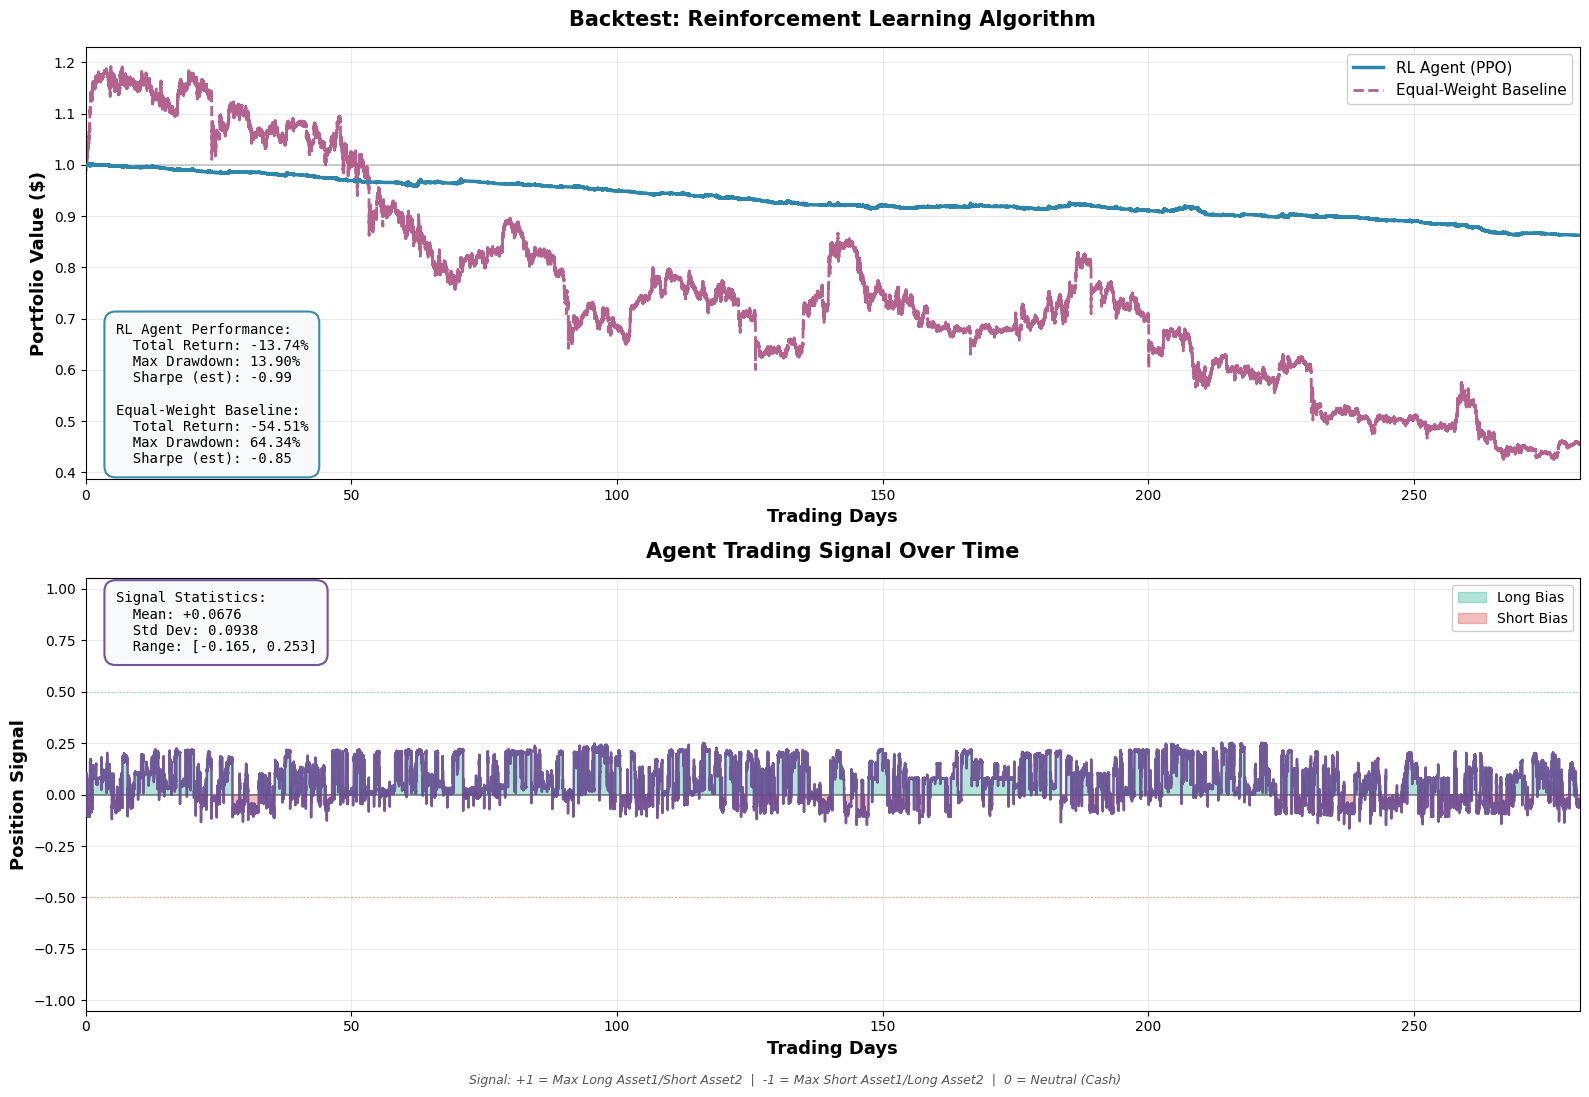


DETAILED BACKTEST STATISTICS

Portfolio Metrics:
  Starting Value:        1.0000
  Ending Value:          0.8626
  Total Return:          -13.74%
  Max Drawdown:          13.90%
  Volatility (Returns):  0.000049

Trading Statistics:
  Average Action:        0.0676
  Action Std Dev:        0.0938
  Action Range:          [-0.1654, 0.2526]
  Avg Turnover:          0.0017
  Avg Leverage:          0.0937
  Max Leverage:          0.2526

Action Distribution:
  Neutral (|action| < 0.1): 62.84%
  Long (action > 0.1):      35.93%
  Short (action < -0.1):    1.23%


In [27]:
# Load the best trained model
best_split = SPLITS[0]
model_path = os.path.join(CONFIG["IO"]["models_dir"], "best_model.zip")

# Check if best model exists, otherwise use the split model
if not os.path.exists(model_path):
    #model_path = os.path.join(CONFIG["IO"]["models_dir"], f"ppo_{best_split['name']}.zip")
    model_path = os.path.join(CONFIG["IO"]["models_dir"], "final_model.zip")

print(f"Loading model from: {model_path}")
model = PPO.load(model_path)

# Create test environment
test_env = make_env_from_mask(best_split["test"], name="test_backtest")

# Run backtest
print("\nRunning backtest on test set...")
ec, to, lev, act = backtest_env(test_env, model=model, include_leverage=True)

# Calculate equal weight benchmark for comparison
base_env = test_env.unwrapped if hasattr(test_env, "unwrapped") else test_env
raw_returns = np.asarray(base_env.R)
if raw_returns.ndim == 1:
    raw_returns = raw_returns.reshape(-1, 1)

steps = min(len(ec.index) - 1, raw_returns.shape[0])
if raw_returns.shape[1] == 0 or steps <= 0:
    ec_bench = pd.Series(np.ones(len(ec.index)), index=ec.index)
else:
    ew = np.ones(raw_returns.shape[1]) / raw_returns.shape[1]
    ec_bench = [1.0]
    for i in range(steps):
        step_ret = float(np.dot(ew, raw_returns[i].reshape(-1)))
        ec_bench.append(ec_bench[-1] * math.exp(step_ret))
    if len(ec_bench) < len(ec.index):
        ec_bench.extend([ec_bench[-1]] * (len(ec.index) - len(ec_bench)))
    ec_bench = pd.Series(ec_bench[:len(ec.index)], index=ec.index)

# Get test period dates
test_period_start = CONFIG["SPLITS"]["test"][0]
test_period_end = CONFIG["SPLITS"]["test"][1]

print("\nBacktest completed!")
print(f"Test period: {test_period_start} to {test_period_end}")
print(f"Total steps: {len(ec)}")
print(f"Model final value: {ec.iloc[-1]:.4f} ({(ec.iloc[-1] - 1) * 100:.2f}%)")
print(f"Benchmark final value: {ec_bench.iloc[-1]:.4f} ({(ec_bench.iloc[-1] - 1) * 100:.2f}%)")
print(f"Average leverage: {lev.mean():.4f}")
print(f"Average turnover: {to.mean():.4f}")

# Create visualization with improved labeling
fig, axes = plt.subplots(2, 1, figsize=(16, 11))

# Convert steps to days (1 step = 1 minute)
minutes_per_day = 24 * 60
days = ec.index / minutes_per_day
days_bench = ec_bench.index / minutes_per_day
days_act = act.index / minutes_per_day

# Calculate performance metrics
final_value = ec.iloc[-1]
total_return = (final_value - 1) * 100
max_drawdown = (ec / ec.cummax() - 1).min()
bench_return = (ec_bench.iloc[-1] - 1) * 100
bench_max_drawdown = (ec_bench / ec_bench.cummax() - 1).min()
total_days = len(ec) / minutes_per_day

# Plot 1: Portfolio Value - Model vs Benchmark
axes[0].plot(days, ec.values, label='RL Agent (PPO)', color='#2E86AB', linewidth=2.5, zorder=3)
axes[0].plot(days_bench, ec_bench.values, label='Equal-Weight Baseline', 
             color='#A23B72', linewidth=2, linestyle='--', alpha=0.8, zorder=2)
axes[0].axhline(y=1.0, color='#888888', linestyle='-', linewidth=1.5, alpha=0.4, zorder=1)
axes[0].set_title('Backtest: Reinforcement Learning Algorithm', 
                   fontsize=15, fontweight='bold', pad=15)
axes[0].set_xlabel('Trading Days', fontsize=13, fontweight='600')
axes[0].set_ylabel('Portfolio Value ($)', fontsize=13, fontweight='600')
axes[0].legend(fontsize=11, loc='best', framealpha=0.95)
axes[0].grid(True, alpha=0.25, linestyle='-', linewidth=0.7)
axes[0].set_xlim(0, total_days)

# Add performance metrics box with better formatting (moved to lower left)
metrics_text = (f'RL Agent Performance:\n'
                f'  Total Return: {total_return:+.2f}%\n'
                f'  Max Drawdown: {abs(max_drawdown) * 100:.2f}%\n'
                f'  Sharpe (est): {(total_return / (abs(max_drawdown) * 100 + 1e-6)):.2f}\n'
                f'\n'
                f'Equal-Weight Baseline:\n'
                f'  Total Return: {bench_return:+.2f}%\n'
                f'  Max Drawdown: {abs(bench_max_drawdown) * 100:.2f}%\n'
                f'  Sharpe (est): {(bench_return / (abs(bench_max_drawdown) * 100 + 1e-6)):.2f}')
axes[0].text(0.02, 0.03, metrics_text, transform=axes[0].transAxes, 
             fontsize=10, verticalalignment='bottom', family='monospace',
             bbox=dict(boxstyle='round,pad=0.8', facecolor='#F7F9FB', 
                      edgecolor='#2E86AB', linewidth=1.5, alpha=0.95))

# Plot 2: Trading Actions (Position Signal)
axes[1].plot(days_act, act.values, color='#6A4C93', linewidth=1.8, alpha=0.9, zorder=3)
axes[1].fill_between(days_act, act.values, 0, where=(act.values >= 0), 
                      color='#06A77D', alpha=0.3, label='Long Bias', interpolate=True)
axes[1].fill_between(days_act, act.values, 0, where=(act.values < 0), 
                      color='#D62828', alpha=0.3, label='Short Bias', interpolate=True)
axes[1].axhline(y=0, color='#444444', linestyle='-', linewidth=1.2, alpha=0.6, zorder=2)
axes[1].axhline(y=0.5, color='#06A77D', linestyle=':', linewidth=1, alpha=0.4)
axes[1].axhline(y=-0.5, color='#D62828', linestyle=':', linewidth=1, alpha=0.4)
axes[1].set_ylim(-1.05, 1.05)
axes[1].set_title('Agent Trading Signal Over Time', fontsize=15, fontweight='bold', pad=15)
axes[1].set_xlabel('Trading Days', fontsize=13, fontweight='600')
axes[1].set_ylabel('Position Signal', fontsize=13, fontweight='600')
axes[1].legend(fontsize=10, loc='upper right', framealpha=0.95)
axes[1].grid(True, alpha=0.25, linestyle='-', linewidth=0.7)
axes[1].set_xlim(0, total_days)

# Add action statistics box with better formatting
action_stats = (f'Signal Statistics:\n'
                f'  Mean: {act.mean():+.4f}\n'
                f'  Std Dev: {act.std():.4f}\n'
                f'  Range: [{act.min():.3f}, {act.max():.3f}]')
axes[1].text(0.02, 0.97, action_stats, transform=axes[1].transAxes, 
             fontsize=10, verticalalignment='top', family='monospace',
             bbox=dict(boxstyle='round,pad=0.8', facecolor='#F7F9FB', 
                      edgecolor='#6A4C93', linewidth=1.5, alpha=0.95))

# Add note about signal interpretation
signal_note = 'Signal: +1 = Max Long Asset1/Short Asset2  |  -1 = Max Short Asset1/Long Asset2  |  0 = Neutral (Cash)'
fig.text(0.5, 0.01, signal_note, ha='center', fontsize=9, style='italic', color='#555555')

plt.tight_layout(rect=[0, 0.02, 1, 1])
plt.show()
plt.close(fig)

# Print detailed statistics
print("\n" + "="*60)
print("DETAILED BACKTEST STATISTICS")
print("="*60)
print("\nPortfolio Metrics:")
print("  Starting Value:        1.0000")
print(f"  Ending Value:          {ec.iloc[-1]:.4f}")
print(f"  Total Return:          {(ec.iloc[-1] - 1) * 100:.2f}%")
print(f"  Max Drawdown:          {abs(max_drawdown) * 100:.2f}%")
print(f"  Volatility (Returns):  {ec.pct_change().std():.6f}")

print("\nTrading Statistics:")
print(f"  Average Action:        {act.mean():.4f}")
print(f"  Action Std Dev:        {act.std():.4f}")
print(f"  Action Range:          [{act.min():.4f}, {act.max():.4f}]")
print(f"  Avg Turnover:          {to.mean():.4f}")
print(f"  Avg Leverage:          {lev.mean():.4f}")
print(f"  Max Leverage:          {lev.max():.4f}")

# Action distribution
neutral_pct = ((act.abs() < 0.1).sum() / len(act)) * 100
long_pct = ((act > 0.1).sum() / len(act)) * 100
short_pct = ((act < -0.1).sum() / len(act)) * 100

print("\nAction Distribution:")
print(f"  Neutral (|action| < 0.1): {neutral_pct:.2f}%")
print(f"  Long (action > 0.1):      {long_pct:.2f}%")
print(f"  Short (action < -0.1):    {short_pct:.2f}%")
print("="*60)

Loading model from: ./models/best_model.zip
Slicing: 404981 samples out of 2520854 fall in range 2024-05-01 00:00:00+00:00 to 2024-06-30 23:59:00+00:00

Validating data for environment 'test_backtest'...

Validating data for environment 'test_backtest'...
⚠ WARNING: Very large volatility in V_s (max: 20.22)
✓ Data validation complete for 'test_backtest'
  X: shape=(404981, 1, 32, 20), range=[-23.1273, 7564.9917]
  R: shape=(404981, 2), range=[-0.0943, 0.0378]
  V: shape=(404981, 1), range=[0.0000, 20.2210]

Running backtest on test set...
⚠ WARNING: Very large volatility in V_s (max: 20.22)
✓ Data validation complete for 'test_backtest'
  X: shape=(404981, 1, 32, 20), range=[-23.1273, 7564.9917]
  R: shape=(404981, 2), range=[-0.0943, 0.0378]
  V: shape=(404981, 1), range=[0.0000, 20.2210]

Running backtest on test set...

Backtest completed!
Test period: 2024-05-01 00:00:00 to 2024-06-30 23:59:59
Total steps: 404980
Model final value: 0.8626 (-13.74%)
Benchmark final value: 0.4549 (-5

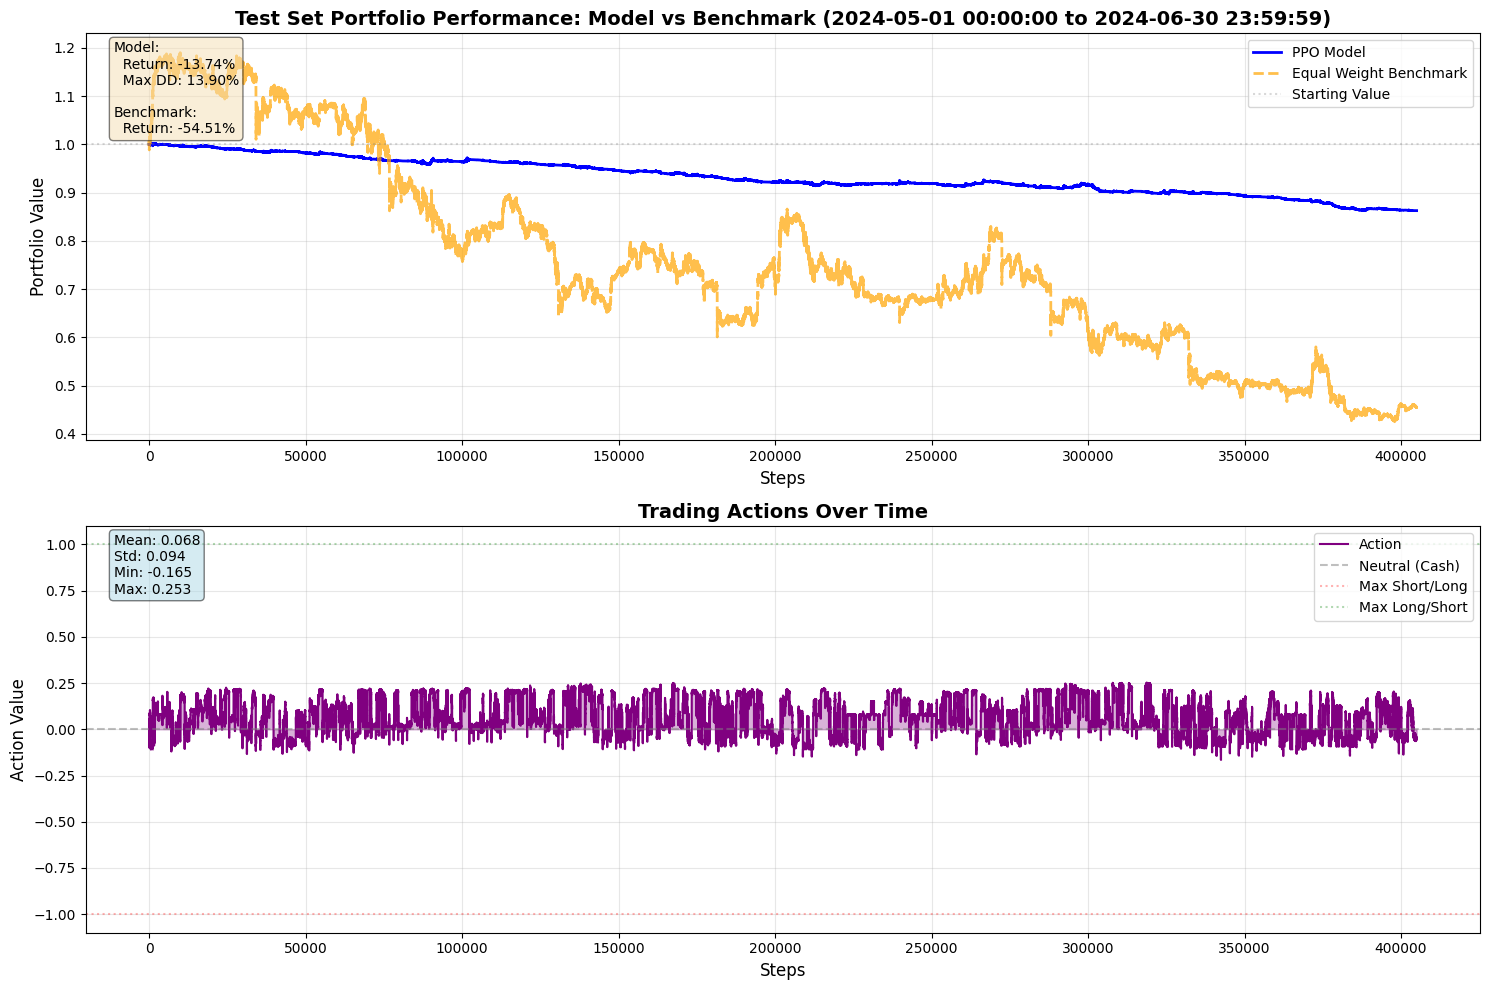


DETAILED BACKTEST STATISTICS

Portfolio Metrics:
  Starting Value:        1.0000
  Ending Value:          0.8626
  Total Return:          -13.74%
  Max Drawdown:          13.90%
  Volatility (Returns):  0.000049

Trading Statistics:
  Average Action:        0.0676
  Action Std Dev:        0.0938
  Action Range:          [-0.1654, 0.2526]
  Avg Turnover:          0.0017
  Avg Leverage:          0.0937
  Max Leverage:          0.2526

Action Distribution:
  Neutral (|action| < 0.1): 62.84%
  Long (action > 0.1):      35.93%
  Short (action < -0.1):    1.23%


In [28]:
# Load the best trained model
best_split = SPLITS[0]
model_path = os.path.join(CONFIG["IO"]["models_dir"], "best_model.zip")

# Check if best model exists, otherwise use the split model
if not os.path.exists(model_path):
    #model_path = os.path.join(CONFIG["IO"]["models_dir"], f"ppo_{best_split['name']}.zip")
    model_path = os.path.join(CONFIG["IO"]["models_dir"], "final_model.zip")

print(f"Loading model from: {model_path}")
model = PPO.load(model_path)

# Create test environment
test_env = make_env_from_mask(best_split["test"], name="test_backtest")

# Run backtest
print("\nRunning backtest on test set...")
ec, to, lev, act = backtest_env(test_env, model=model, include_leverage=True)

# Calculate equal weight benchmark for comparison
base_env = test_env.unwrapped if hasattr(test_env, "unwrapped") else test_env
raw_returns = np.asarray(base_env.R)
if raw_returns.ndim == 1:
    raw_returns = raw_returns.reshape(-1, 1)

steps = min(len(ec.index) - 1, raw_returns.shape[0])
if raw_returns.shape[1] == 0 or steps <= 0:
    ec_bench = pd.Series(np.ones(len(ec.index)), index=ec.index)
else:
    ew = np.ones(raw_returns.shape[1]) / raw_returns.shape[1]
    ec_bench = [1.0]
    for i in range(steps):
        step_ret = float(np.dot(ew, raw_returns[i].reshape(-1)))
        ec_bench.append(ec_bench[-1] * math.exp(step_ret))
    if len(ec_bench) < len(ec.index):
        ec_bench.extend([ec_bench[-1]] * (len(ec.index) - len(ec_bench)))
    ec_bench = pd.Series(ec_bench[:len(ec.index)], index=ec.index)

# Get test period dates
test_period_start = CONFIG["SPLITS"]["test"][0]
test_period_end = CONFIG["SPLITS"]["test"][1]

print("\nBacktest completed!")
print(f"Test period: {test_period_start} to {test_period_end}")
print(f"Total steps: {len(ec)}")
print(f"Model final value: {ec.iloc[-1]:.4f} ({(ec.iloc[-1] - 1) * 100:.2f}%)")
print(f"Benchmark final value: {ec_bench.iloc[-1]:.4f} ({(ec_bench.iloc[-1] - 1) * 100:.2f}%)")
print(f"Average leverage: {lev.mean():.4f}")
print(f"Average turnover: {to.mean():.4f}")

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Portfolio Value - Model vs Benchmark
axes[0].plot(ec.index, ec.values, label='PPO Model', color='blue', linewidth=2)
axes[0].plot(ec_bench.index, ec_bench.values, label='Equal Weight Benchmark', color='orange', linewidth=2, linestyle='--', alpha=0.7)
axes[0].axhline(y=1.0, color='gray', linestyle=':', alpha=0.3, label='Starting Value')
axes[0].set_title(f'Test Set Portfolio Performance: Model vs Benchmark ({test_period_start} to {test_period_end})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Steps', fontsize=12)
axes[0].set_ylabel('Portfolio Value', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Add performance metrics as text
final_value = ec.iloc[-1]
total_return = (final_value - 1) * 100
max_drawdown = (ec / ec.cummax() - 1).min()
bench_return = (ec_bench.iloc[-1] - 1) * 100
metrics_text = f'Model:\n  Return: {total_return:.2f}%\n  Max DD: {abs(max_drawdown) * 100:.2f}%\n\nBenchmark:\n  Return: {bench_return:.2f}%'
axes[0].text(0.02, 0.98, metrics_text, transform=axes[0].transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Trading Actions
axes[1].plot(act.index, act.values, label='Action', drawstyle='steps-post', color='purple', linewidth=1.5)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Neutral (Cash)')
axes[1].axhline(y=-1, color='red', linestyle=':', alpha=0.3, label='Max Short/Long')
axes[1].axhline(y=1, color='green', linestyle=':', alpha=0.3, label='Max Long/Short')
axes[1].fill_between(act.index, act.values, 0, alpha=0.3, color='purple')
axes[1].set_ylim(-1.1, 1.1)
axes[1].set_title('Trading Actions Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Steps', fontsize=12)
axes[1].set_ylabel('Action Value', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Add action statistics as text
action_stats = f'Mean: {act.mean():.3f}\nStd: {act.std():.3f}\nMin: {act.min():.3f}\nMax: {act.max():.3f}'
axes[1].text(0.02, 0.98, action_stats, transform=axes[1].transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()
plt.close(fig)

# Print detailed statistics
print("\n" + "="*60)
print("DETAILED BACKTEST STATISTICS")
print("="*60)
print("\nPortfolio Metrics:")
print("  Starting Value:        1.0000")
print(f"  Ending Value:          {ec.iloc[-1]:.4f}")
print(f"  Total Return:          {(ec.iloc[-1] - 1) * 100:.2f}%")
print(f"  Max Drawdown:          {abs(max_drawdown) * 100:.2f}%")
print(f"  Volatility (Returns):  {ec.pct_change().std():.6f}")

print("\nTrading Statistics:")
print(f"  Average Action:        {act.mean():.4f}")
print(f"  Action Std Dev:        {act.std():.4f}")
print(f"  Action Range:          [{act.min():.4f}, {act.max():.4f}]")
print(f"  Avg Turnover:          {to.mean():.4f}")
print(f"  Avg Leverage:          {lev.mean():.4f}")
print(f"  Max Leverage:          {lev.max():.4f}")

# Action distribution
neutral_pct = ((act.abs() < 0.1).sum() / len(act)) * 100
long_pct = ((act > 0.1).sum() / len(act)) * 100
short_pct = ((act < -0.1).sum() / len(act)) * 100

print("\nAction Distribution:")
print(f"  Neutral (|action| < 0.1): {neutral_pct:.2f}%")
print(f"  Long (action > 0.1):      {long_pct:.2f}%")
print(f"  Short (action < -0.1):    {short_pct:.2f}%")
print("="*60)

Loading model from: ./models/best_model.zip
Slicing: 404981 samples out of 2520854 fall in range 2024-05-01 00:00:00+00:00 to 2024-06-30 23:59:00+00:00

Validating data for environment 'test_backtest'...

Validating data for environment 'test_backtest'...
⚠ WARNING: Very large volatility in V_s (max: 20.22)
✓ Data validation complete for 'test_backtest'
  X: shape=(404981, 1, 32, 20), range=[-23.1273, 7564.9917]
  R: shape=(404981, 2), range=[-0.0943, 0.0378]
  V: shape=(404981, 1), range=[0.0000, 20.2210]

Running backtest on test set...
⚠ WARNING: Very large volatility in V_s (max: 20.22)
✓ Data validation complete for 'test_backtest'
  X: shape=(404981, 1, 32, 20), range=[-23.1273, 7564.9917]
  R: shape=(404981, 2), range=[-0.0943, 0.0378]
  V: shape=(404981, 1), range=[0.0000, 20.2210]

Running backtest on test set...

Backtest completed!
Test period: 2024-05-01 00:00:00 to 2024-06-30 23:59:59
Total steps: 404980
Model final value: 0.8626 (-13.74%)
Benchmark final value: 0.4549 (-5

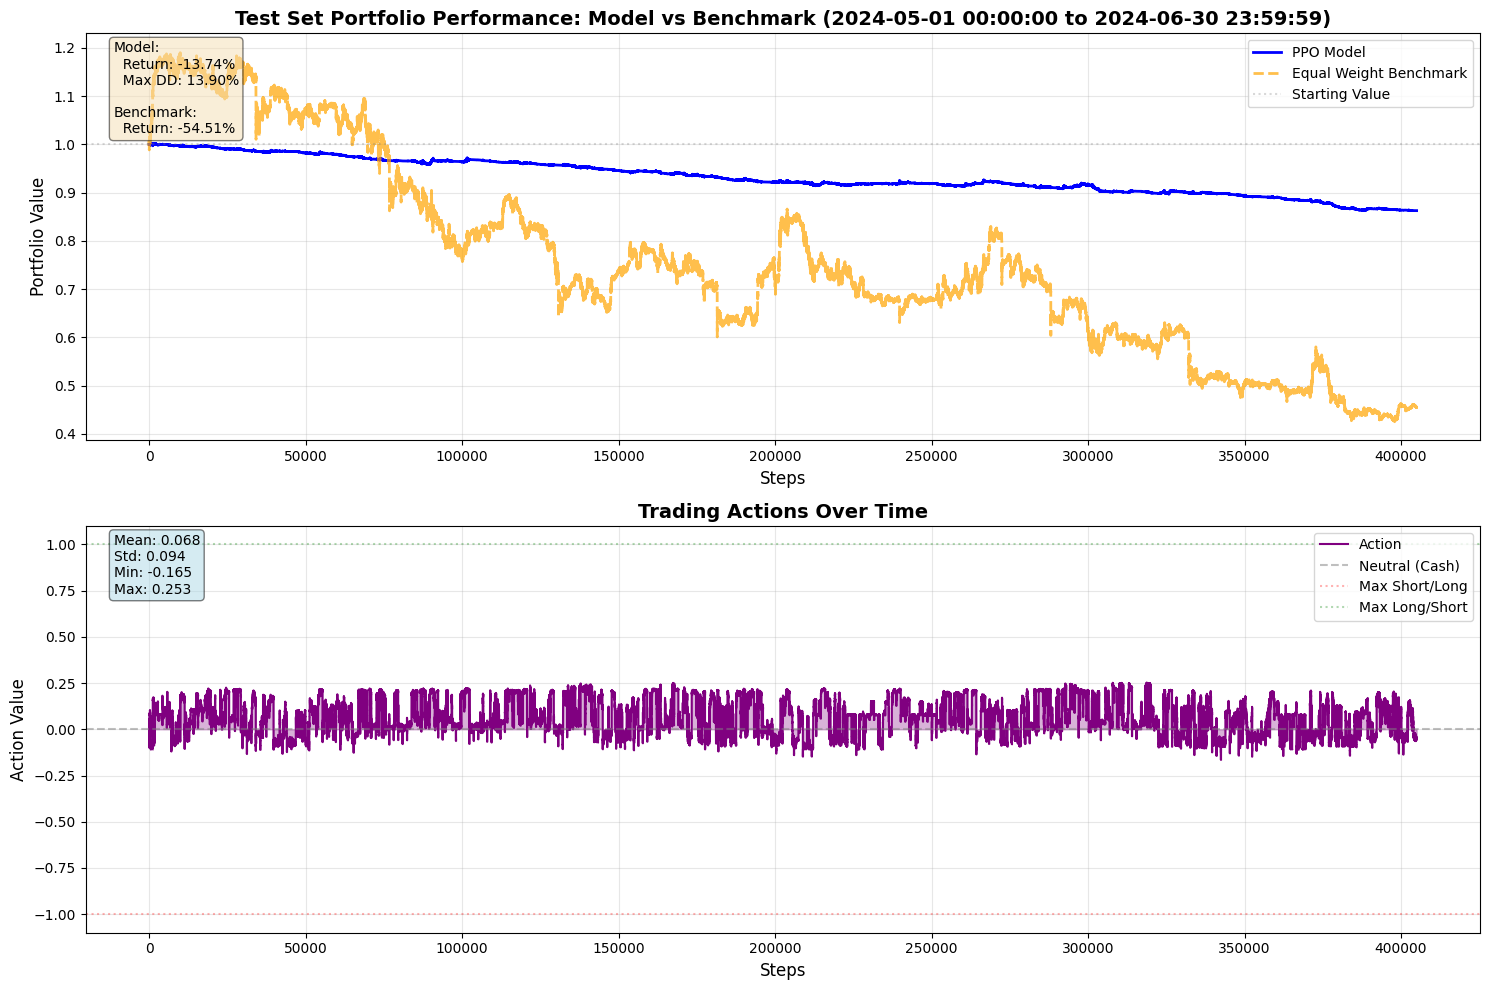


DETAILED BACKTEST STATISTICS

Portfolio Metrics:
  Starting Value:        1.0000
  Ending Value:          0.8626
  Total Return:          -13.74%
  Max Drawdown:          13.90%
  Volatility (Returns):  0.000049

Trading Statistics:
  Average Action:        0.0676
  Action Std Dev:        0.0938
  Action Range:          [-0.1654, 0.2526]
  Avg Turnover:          0.0017
  Avg Leverage:          0.0937
  Max Leverage:          0.2526

Action Distribution:
  Neutral (|action| < 0.1): 62.84%
  Long (action > 0.1):      35.93%
  Short (action < -0.1):    1.23%


In [29]:
# Load the best trained model
best_split = SPLITS[0]
model_path = os.path.join(CONFIG["IO"]["models_dir"], "best_model.zip")

# Check if best model exists, otherwise use the split model
if not os.path.exists(model_path):
    #model_path = os.path.join(CONFIG["IO"]["models_dir"], f"ppo_{best_split['name']}.zip")
    model_path = os.path.join(CONFIG["IO"]["models_dir"], "final_model.zip")

print(f"Loading model from: {model_path}")
model = PPO.load(model_path)

# Create test environment
test_env = make_env_from_mask(best_split["test"], name="test_backtest")

# Run backtest
print("\nRunning backtest on test set...")
ec, to, lev, act = backtest_env(test_env, model=model, include_leverage=True)

# Calculate equal weight benchmark for comparison
base_env = test_env.unwrapped if hasattr(test_env, "unwrapped") else test_env
raw_returns = np.asarray(base_env.R)
if raw_returns.ndim == 1:
    raw_returns = raw_returns.reshape(-1, 1)

steps = min(len(ec.index) - 1, raw_returns.shape[0])
if raw_returns.shape[1] == 0 or steps <= 0:
    ec_bench = pd.Series(np.ones(len(ec.index)), index=ec.index)
else:
    ew = np.ones(raw_returns.shape[1]) / raw_returns.shape[1]
    ec_bench = [1.0]
    for i in range(steps):
        step_ret = float(np.dot(ew, raw_returns[i].reshape(-1)))
        ec_bench.append(ec_bench[-1] * math.exp(step_ret))
    if len(ec_bench) < len(ec.index):
        ec_bench.extend([ec_bench[-1]] * (len(ec.index) - len(ec_bench)))
    ec_bench = pd.Series(ec_bench[:len(ec.index)], index=ec.index)

# Get test period dates
test_period_start = CONFIG["SPLITS"]["test"][0]
test_period_end = CONFIG["SPLITS"]["test"][1]

print("\nBacktest completed!")
print(f"Test period: {test_period_start} to {test_period_end}")
print(f"Total steps: {len(ec)}")
print(f"Model final value: {ec.iloc[-1]:.4f} ({(ec.iloc[-1] - 1) * 100:.2f}%)")
print(f"Benchmark final value: {ec_bench.iloc[-1]:.4f} ({(ec_bench.iloc[-1] - 1) * 100:.2f}%)")
print(f"Average leverage: {lev.mean():.4f}")
print(f"Average turnover: {to.mean():.4f}")

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Portfolio Value - Model vs Benchmark
axes[0].plot(ec.index, ec.values, label='PPO Model', color='blue', linewidth=2)
axes[0].plot(ec_bench.index, ec_bench.values, label='Equal Weight Benchmark', color='orange', linewidth=2, linestyle='--', alpha=0.7)
axes[0].axhline(y=1.0, color='gray', linestyle=':', alpha=0.3, label='Starting Value')
axes[0].set_title(f'Test Set Portfolio Performance: Model vs Benchmark ({test_period_start} to {test_period_end})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Steps', fontsize=12)
axes[0].set_ylabel('Portfolio Value', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Add performance metrics as text
final_value = ec.iloc[-1]
total_return = (final_value - 1) * 100
max_drawdown = (ec / ec.cummax() - 1).min()
bench_return = (ec_bench.iloc[-1] - 1) * 100
metrics_text = f'Model:\n  Return: {total_return:.2f}%\n  Max DD: {abs(max_drawdown) * 100:.2f}%\n\nBenchmark:\n  Return: {bench_return:.2f}%'
axes[0].text(0.02, 0.98, metrics_text, transform=axes[0].transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Trading Actions
axes[1].plot(act.index, act.values, label='Action', drawstyle='steps-post', color='purple', linewidth=1.5)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Neutral (Cash)')
axes[1].axhline(y=-1, color='red', linestyle=':', alpha=0.3, label='Max Short/Long')
axes[1].axhline(y=1, color='green', linestyle=':', alpha=0.3, label='Max Long/Short')
axes[1].fill_between(act.index, act.values, 0, alpha=0.3, color='purple')
axes[1].set_ylim(-1.1, 1.1)
axes[1].set_title('Trading Actions Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Steps', fontsize=12)
axes[1].set_ylabel('Action Value', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Add action statistics as text
action_stats = f'Mean: {act.mean():.3f}\nStd: {act.std():.3f}\nMin: {act.min():.3f}\nMax: {act.max():.3f}'
axes[1].text(0.02, 0.98, action_stats, transform=axes[1].transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()
plt.close(fig)

# Print detailed statistics
print("\n" + "="*60)
print("DETAILED BACKTEST STATISTICS")
print("="*60)
print("\nPortfolio Metrics:")
print("  Starting Value:        1.0000")
print(f"  Ending Value:          {ec.iloc[-1]:.4f}")
print(f"  Total Return:          {(ec.iloc[-1] - 1) * 100:.2f}%")
print(f"  Max Drawdown:          {abs(max_drawdown) * 100:.2f}%")
print(f"  Volatility (Returns):  {ec.pct_change().std():.6f}")

print("\nTrading Statistics:")
print(f"  Average Action:        {act.mean():.4f}")
print(f"  Action Std Dev:        {act.std():.4f}")
print(f"  Action Range:          [{act.min():.4f}, {act.max():.4f}]")
print(f"  Avg Turnover:          {to.mean():.4f}")
print(f"  Avg Leverage:          {lev.mean():.4f}")
print(f"  Max Leverage:          {lev.max():.4f}")

# Action distribution
neutral_pct = ((act.abs() < 0.1).sum() / len(act)) * 100
long_pct = ((act > 0.1).sum() / len(act)) * 100
short_pct = ((act < -0.1).sum() / len(act)) * 100

print("\nAction Distribution:")
print(f"  Neutral (|action| < 0.1): {neutral_pct:.2f}%")
print(f"  Long (action > 0.1):      {long_pct:.2f}%")
print(f"  Short (action < -0.1):    {short_pct:.2f}%")
print("="*60)


Generating returns visualization...
Slicing: 404981 samples out of 2520854 fall in range 2024-05-01 00:00:00+00:00 to 2024-06-30 23:59:00+00:00

Validating data for environment 'test_returns'...

Validating data for environment 'test_returns'...
⚠ WARNING: Very large volatility in V_s (max: 20.22)
✓ Data validation complete for 'test_returns'
  X: shape=(404981, 1, 32, 20), range=[-23.1273, 7564.9917]
  R: shape=(404981, 2), range=[-0.0943, 0.0378]
  V: shape=(404981, 1), range=[0.0000, 20.2210]
⚠ WARNING: Very large volatility in V_s (max: 20.22)
✓ Data validation complete for 'test_returns'
  X: shape=(404981, 1, 32, 20), range=[-23.1273, 7564.9917]
  R: shape=(404981, 2), range=[-0.0943, 0.0378]
  V: shape=(404981, 1), range=[0.0000, 20.2210]


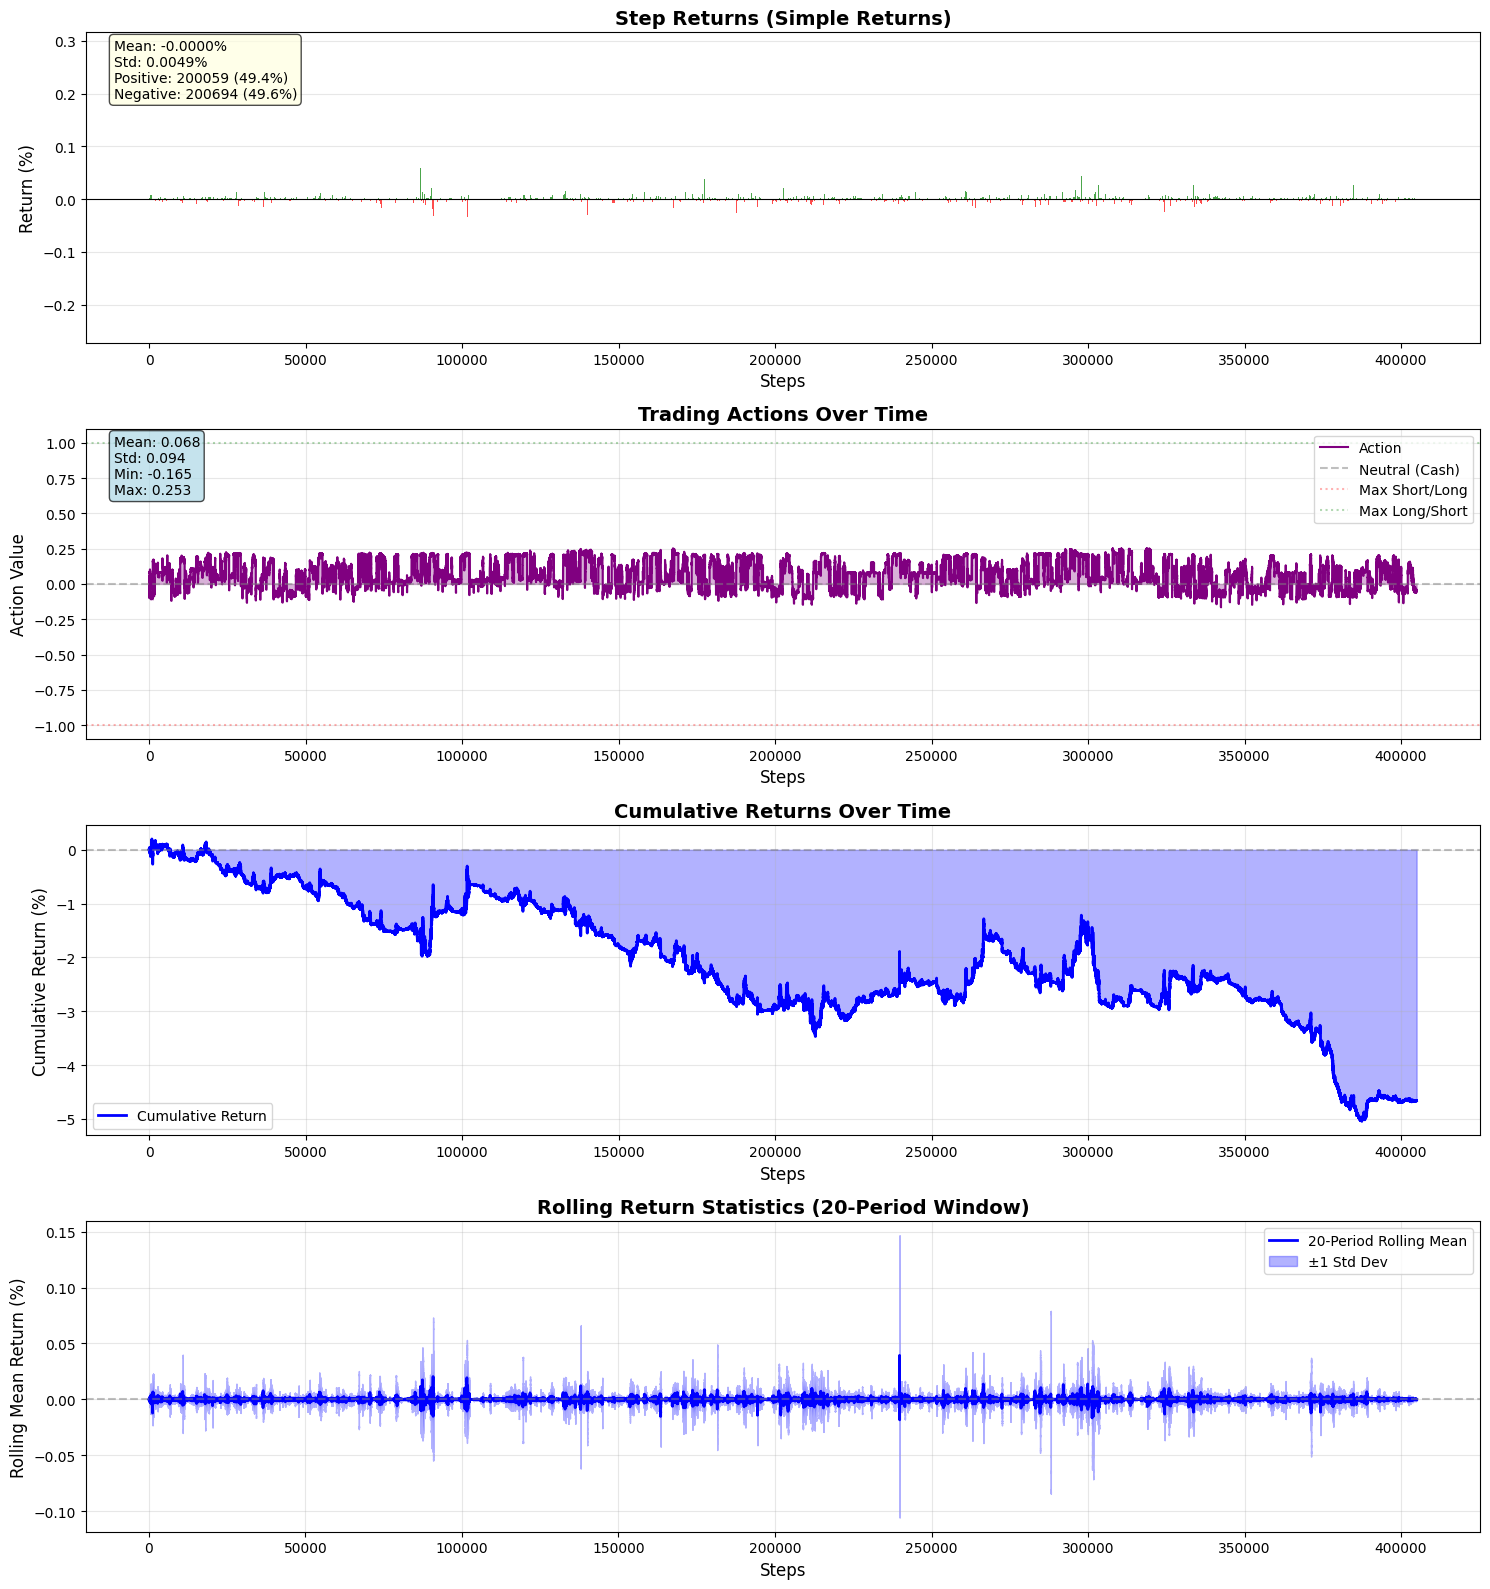


RETURN STATISTICS

Step Returns (Simple Returns):
  Mean:              -0.0000%
  Median:            0.0000%
  Std Dev:           0.0049%
  Min:               -0.2461%
  Max:               0.2894%
  Skewness:          0.1619
  Kurtosis:          141.1378

Return Distribution:
  Positive steps:    200059 (49.4%)
  Negative steps:    200694 (49.6%)
  Zero steps:        4227 (1.0%)

Cumulative:
  Total Return:      -4.66%
  Arithmetic Mean:   -0.0000% per step
  Geometric Mean:    -0.0000% per step


In [30]:
# Create a plot showing returns on each timestep
print("\nGenerating returns visualization...")

# Get returns from test environment backtest
test_env_returns = make_env_from_mask(best_split["test"], name="test_returns")
ec_ret, to_ret, lev_ret, act_ret, log_ret = backtest_env(test_env_returns, model=model, include_returns=True)

# Convert log returns to simple returns (stable): use expm1 for precision
ret = np.expm1(log_ret)

# Create comprehensive returns visualization with actions
fig, axes = plt.subplots(4, 1, figsize=(15, 16))

# Plot 1: Step Returns (Simple Returns as %)
ret_pct = ret * 100  # Convert to percentage
axes[0].bar(ret.index, ret_pct.values, color=['green' if r > 0 else 'red' for r in ret_pct.values], alpha=0.7, width=1.0)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[0].set_title('Step Returns (Simple Returns)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Steps', fontsize=12)
axes[0].set_ylabel('Return (%)', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# Add statistics
ret_mean = ret.mean() * 100
ret_std = ret.std() * 100
ret_pos = (ret > 0).sum()
ret_neg = (ret < 0).sum()
ret_stats = f'Mean: {ret_mean:.4f}%\nStd: {ret_std:.4f}%\nPositive: {ret_pos} ({ret_pos/len(ret)*100:.1f}%)\nNegative: {ret_neg} ({ret_neg/len(ret)*100:.1f}%)'
axes[0].text(0.02, 0.98, ret_stats, transform=axes[0].transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

# Plot 2: Trading Actions
axes[1].plot(act_ret.index, act_ret.values, label='Action', drawstyle='steps-post', color='purple', linewidth=1.5)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Neutral (Cash)')
axes[1].axhline(y=-1, color='red', linestyle=':', alpha=0.3, label='Max Short/Long')
axes[1].axhline(y=1, color='green', linestyle=':', alpha=0.3, label='Max Long/Short')
axes[1].fill_between(act_ret.index, act_ret.values, 0, alpha=0.3, color='purple')
axes[1].set_ylim(-1.1, 1.1)
axes[1].set_title('Trading Actions Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Steps', fontsize=12)
axes[1].set_ylabel('Action Value', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Add action statistics
action_stats = f'Mean: {act_ret.mean():.3f}\nStd: {act_ret.std():.3f}\nMin: {act_ret.min():.3f}\nMax: {act_ret.max():.3f}'
axes[1].text(0.02, 0.98, action_stats, transform=axes[1].transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# Plot 3: Cumulative Returns (%)
cumulative_ret = ((1 + ret).cumprod() - 1) * 100
axes[2].plot(cumulative_ret.index, cumulative_ret.values, color='blue', linewidth=2, label='Cumulative Return')
axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[2].fill_between(cumulative_ret.index, cumulative_ret.values, 0, alpha=0.3, color='blue')
axes[2].set_title('Cumulative Returns Over Time', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Steps', fontsize=12)
axes[2].set_ylabel('Cumulative Return (%)', fontsize=12)
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

# Plot 4: Rolling Statistics (20-period window)
window_raw = len(ret) // 4  # Base window from data length
window = max(1, min(20, window_raw))  # Ensure valid window size
rolling_mean = (ret * 100).rolling(window=window).mean()
rolling_std = (ret * 100).rolling(window=window).std()

axes[3].plot(rolling_mean.index, rolling_mean.values, color='blue', linewidth=2, label=f'{window}-Period Rolling Mean')
axes[3].fill_between(rolling_mean.index, 
                      rolling_mean - rolling_std, 
                      rolling_mean + rolling_std, 
                      alpha=0.3, color='blue', label='±1 Std Dev')
axes[3].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[3].set_title(f'Rolling Return Statistics ({window}-Period Window)', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Steps', fontsize=12)
axes[3].set_ylabel('Rolling Mean Return (%)', fontsize=12)
axes[3].legend(fontsize=10)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close(fig)

# Print return statistics
print("\n" + "="*60)
print("RETURN STATISTICS")
print("="*60)
print("\nStep Returns (Simple Returns):")
print(f"  Mean:              {ret.mean() * 100:.4f}%")
print(f"  Median:            {ret.median() * 100:.4f}%")
print(f"  Std Dev:           {ret.std() * 100:.4f}%")
print(f"  Min:               {ret.min() * 100:.4f}%")
print(f"  Max:               {ret.max() * 100:.4f}%")
print(f"  Skewness:          {ret.skew():.4f}")
print(f"  Kurtosis:          {ret.kurtosis():.4f}")
print("\nReturn Distribution:")
print(f"  Positive steps:    {(ret > 0).sum()} ({(ret > 0).sum()/len(ret)*100:.1f}%)")
print(f"  Negative steps:    {(ret < 0).sum()} ({(ret < 0).sum()/len(ret)*100:.1f}%)")
print(f"  Zero steps:        {(ret == 0).sum()} ({(ret == 0).sum()/len(ret)*100:.1f}%)")
print("\nCumulative:")
print(f"  Total Return:      {((1 + ret).prod() - 1) * 100:.2f}%")
print(f"  Arithmetic Mean:   {ret.mean() * 100:.4f}% per step")
print(f"  Geometric Mean:    {(((1 + ret).prod()) ** (1/len(ret)) - 1) * 100:.4f}% per step")
print("="*60)

# Clean up
test_env_returns.close()

## Inference: Generate Trading Signals

This cell contains a standalone inference function that can be copied to a separate Python script.
The function takes a single observation (features for one timestep) and outputs a trading signal in JSON format.

In [31]:
"""
STANDALONE INFERENCE FUNCTION
==============================
This function can be copied to a separate Python script for production use.
It takes features for a single timestep and generates a trading signal.

Required imports for standalone use:
    import numpy as np
    import pandas as pd
    from datetime import datetime
    from stable_baselines3 import PPO

Feature structure:
------------------
Single asset features (per asset): 12 features
    ['close', 'closeBias', 'closeEwmaVol', 'closeKalman', 'closeLowerShadow', 
     'closeMacd', 'closeRsi', 'closeSigns', 'closeStochRsi', 'closeUpperShadow', 
     'funding', 'fundingMinutesLeft']

Pair features (for both assets combined): 8 features
    ['alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman', 
     'spreadNormMa', 'spreadNormVol']
"""

def continuous_action_to_weights(action: float) -> tuple[float, float]:
    """
    Convert continuous action [-1, 1] to portfolio weights.
    
    Parameters
    ----------
    action : float
        Action value from -1 (short asset1/long asset2) to 1 (long asset1/short asset2)
    
    Returns
    -------
    tuple[float, float]
        (asset1_weight, asset2_weight)
    """
    action = np.clip(action, -1.0, 1.0)
    position_size = action * 0.5
    asset1_weight = position_size
    asset2_weight = -position_size
    return asset1_weight, asset2_weight


def generate_signal_from_features(
    model_path: str,
    asset1: str,
    asset2: str,
    asset1_features: dict,
    asset2_features: dict,
    pair_features: dict,
    current_portfolio_weights: tuple[float, float, float] = (0.0, 0.0, 1.0),
    lookback_window: int = 24,
    timestamp: str = None,
    notional_usd: float = 100,
    bar_timeframe: str = "1h",
    exchange: str = "binance_perpetual",
    fresh_for_seconds: int = 3600,
    version: int = 1
) -> dict:
    """
    Generate a trading signal from features for a single timestep.
    
    This is a STANDALONE function that can be copied to a separate Python script.
    
    Parameters
    ----------
    model_path : str
        Path to the trained PPO model (.zip file)
    asset1 : str
        First asset symbol (e.g., "ETH")
    asset2 : str
        Second asset symbol (e.g., "BTC")
    asset1_features : dict
        Features for asset1 with keys:
        ['close', 'closeBias', 'closeEwmaVol', 'closeKalman', 'closeLowerShadow',
         'closeMacd', 'closeRsi', 'closeSigns', 'closeStochRsi', 'closeUpperShadow',
         'funding', 'fundingMinutesLeft']
        Each value should be a list/array of length lookback_window
    asset2_features : dict
        Features for asset2 (same structure as asset1_features)
    pair_features : dict
        Combined pair features with keys:
        ['alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman',
         'spreadNormMa', 'spreadNormVol']
        Each value should be a list/array of length lookback_window
    current_portfolio_weights : tuple[float, float, float]
        Current portfolio weights (asset1_weight, asset2_weight, cash_weight)
        Default: (0.0, 0.0, 1.0) = 100% cash position
    lookback_window : int
        Number of historical timesteps (default: 24)
    timestamp : str, optional
        ISO format timestamp. If None, uses current time.
    notional_usd : float
        Notional value in USD
    bar_timeframe : str
        Timeframe of bars (e.g., "1h", "1m")
    exchange : str
        Exchange identifier
    fresh_for_seconds : int
        Signal validity duration in seconds
    version : int
        Signal format version
    
    Returns
    -------
    dict
        Trading signal in JSON format
    
    Example
    -------
    >>> signal = generate_signal_from_features(
    ...     model_path="./models/ppo_model.zip",
    ...     asset1="ETH",
    ...     asset2="BTC",
    ...     asset1_features={
    ...         'close': [0.1, 0.2, ...],  # 24 values
    ...         'closeBias': [0.05, -0.03, ...],
    ...         # ... other 10 features
    ...     },
    ...     asset2_features={
    ...         'close': [0.15, 0.18, ...],
    ...         # ... other 11 features
    ...     },
    ...     pair_features={
    ...         'alpha': [0.01, 0.02, ...],  # 24 values
    ...         'beta': [0.98, 0.99, ...],
    ...         # ... other 6 features
    ...     },
    ...     current_portfolio_weights=(0.3, -0.3, 0.4)  # Current position
    ... )
    """
    
    # Define feature order (must match training order)
    SINGLE_ASSET_FEATURES = [
        'close', 'closeBias', 'closeEwmaVol', 'closeKalman', 'closeLowerShadow',
        'closeMacd', 'closeRsi', 'closeSigns', 'closeStochRsi', 'closeUpperShadow',
        'funding', 'fundingMinutesLeft'
    ]
    
    PAIR_FEATURES = [
        'alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman',
        'spreadNormMa', 'spreadNormVol'
    ]
    
    # Validate inputs
    for feat in SINGLE_ASSET_FEATURES:
        if feat not in asset1_features:
            raise ValueError(f"Missing feature '{feat}' in asset1_features")
        if feat not in asset2_features:
            raise ValueError(f"Missing feature '{feat}' in asset2_features")
        if len(asset1_features[feat]) != lookback_window:
            raise ValueError(f"asset1_features['{feat}'] must have length {lookback_window}")
        if len(asset2_features[feat]) != lookback_window:
            raise ValueError(f"asset2_features['{feat}'] must have length {lookback_window}")
    
    # Validate pair features
    for feat in PAIR_FEATURES:
        if feat not in pair_features:
            raise ValueError(f"Missing feature '{feat}' in pair_features")
        if len(pair_features[feat]) != lookback_window:
            raise ValueError(f"pair_features['{feat}'] must have length {lookback_window}")
    
    # Validate portfolio weights
    if len(current_portfolio_weights) != 3:
        raise ValueError(f"current_portfolio_weights must have length 3, got {len(current_portfolio_weights)}")
    
    # Build observation tensor
    # Shape: (n_features * lookback_window + 3,)
    # - Market features: (8 pair + 12 asset1 + 12 asset2) * lookback_window = 32 * 24 = 768 dimensions
    # - Position features: 3 portfolio weights (asset1, asset2, cash) = 3 dimensions
    # Total observation shape: (771,) with default lookback=24
    
    n_pair_features = len(PAIR_FEATURES)
    n_asset_features = len(SINGLE_ASSET_FEATURES)
    n_total_features = n_pair_features + 2 * n_asset_features  # pair + asset1 + asset2
    
    market_obs = np.zeros((n_total_features, lookback_window), dtype=np.float32)
    
    # Fill features in order: pair features, then asset1 features, then asset2 features
    idx = 0
    
    # 1. Fill pair features
    for feat in PAIR_FEATURES:
        market_obs[idx, :] = pair_features[feat]
        idx += 1
    
    # 2. Fill asset1 features
    for feat in SINGLE_ASSET_FEATURES:
        market_obs[idx, :] = asset1_features[feat]
        idx += 1
    
    # 3. Fill asset2 features
    for feat in SINGLE_ASSET_FEATURES:
        market_obs[idx, :] = asset2_features[feat]
        idx += 1
    
    # Flatten market features to (n_features * lookback_window,)
    market_obs = market_obs.reshape(-1).astype(np.float32)
    
    # Add portfolio weights to observation
    position_obs = np.array(current_portfolio_weights, dtype=np.float32)
    
    # Concatenate market features and position features
    obs = np.concatenate([market_obs, position_obs])
    
    # Clip observation values (same as training)
    obs = np.clip(obs, -5.0, 5.0)
    
    # Load model and predict
    model = PPO.load(model_path)
    action, _ = model.predict(obs, deterministic=True)
    
    # Convert action to weights
    action_value = float(action[0]) if isinstance(action, np.ndarray) else float(action)
    asset1_weight, asset2_weight = continuous_action_to_weights(action_value)
    
    # Get or generate timestamp
    if timestamp is None:
        timestamp = pd.Timestamp.now(tz='UTC').strftime("%Y-%m-%dT%H:%M:%SZ")
    elif isinstance(timestamp, pd.Timestamp):
        timestamp = timestamp.strftime("%Y-%m-%dT%H:%M:%SZ")
    
    # Create signal JSON
    signal = {
        "timestamp": timestamp,
        "bar_timeframe": bar_timeframe,
        "pair": {
            "asset1": asset1,
            "asset2": asset2
        },
        "markets": {
            "exchange": exchange,
            "asset1": f"{asset1}-USDT",
            "asset2": f"{asset2}-USDT"
        },
        "weights": {
            "asset1": float(asset1_weight),
            "asset2": float(asset2_weight)
        },
        "notional_usd": notional_usd,
        "fresh_for_seconds": fresh_for_seconds,
        "version": version
    }
    
    return signal
print("  - Features for a single timestep:")
print("    * pair_features: 8 features x lookback_window values")
print("    * current_portfolio_weights: (asset1, asset2, cash) tuple")
print("  - Note: asset1_features and asset2_features parameters exist for")
print("    API compatibility but are not currently used by the model")
print("\nExample below demonstrates usage with TEST data (unseen data)...")
print("=" * 80)





print("=" * 80)
print("\nExample below demonstrates usage with TEST data (unseen data)...")
print("    * pair_features: 8 features x lookback_window values")
print("    * asset2_features: 12 features x lookback_window values")
print("    * asset1_features: 12 features x lookback_window values")
print("  - Features for a single timestep:")
print("    * asset1_features: 12 features x lookback_window values")
print("    * asset2_features: 12 features x lookback_window values")
print("    * pair_features: 8 features x lookback_window values")
print("\nExample below demonstrates usage with TEST data (unseen data)...")
print("=" * 80)

  - Features for a single timestep:
    * pair_features: 8 features x lookback_window values
    * current_portfolio_weights: (asset1, asset2, cash) tuple
  - Note: asset1_features and asset2_features parameters exist for
    API compatibility but are not currently used by the model

Example below demonstrates usage with TEST data (unseen data)...

Example below demonstrates usage with TEST data (unseen data)...
    * pair_features: 8 features x lookback_window values
    * asset2_features: 12 features x lookback_window values
    * asset1_features: 12 features x lookback_window values
  - Features for a single timestep:
    * asset1_features: 12 features x lookback_window values
    * asset2_features: 12 features x lookback_window values
    * pair_features: 8 features x lookback_window values

Example below demonstrates usage with TEST data (unseen data)...


In [32]:
# Demo: Test the standalone function with test data
print("\nRunning demo with test data...\n")

# Load the trained model
best_split = SPLITS[0]
#model_path = os.path.join(CONFIG["IO"]["models_dir"], f"ppo_{best_split['name']}.zip")
model_path = os.path.join(CONFIG["IO"]["models_dir"], "final_model.zip")

if os.path.exists(model_path):
    try:
        # Get a sample from test data
        test_env = make_env_from_mask(best_split["test"], name="test_inference")
        unwrapped_env = test_env.unwrapped if hasattr(test_env, 'unwrapped') else test_env
        
        # Get the first pair
        sample_pair = all_pairs[0]
        asset1, asset2 = sample_pair
    except Exception as e:
        print(f"✗ Error setting up test environment: {str(e)}")
        raise
    
    # Extract features from the first timestep in test set
    # Shape of X: (samples, 1, n_features, lookback)
    sample_idx = 0
    sample_features = unwrapped_env.X[sample_idx, 0, :, :]  # (n_features, lookback)
    
    # For demo, we'll construct the feature dictionaries
    # Note: In production, you'd receive these features from your data pipeline
    lookback = CONFIG["ENV"]["lookback_window"]
    
    # Define feature names (must match training order)
    PAIR_FEATURES = [
        'alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman',
        'spreadNormMa', 'spreadNormVol'
    ]
    
    SINGLE_ASSET_FEATURES = [
        'close', 'closeBias', 'closeEwmaVol', 'closeKalman', 'closeLowerShadow',
        'closeMacd', 'closeRsi', 'closeSigns', 'closeStochRsi', 'closeUpperShadow',
        'funding', 'fundingMinutesLeft'
    ]
    
    # Extract features from sample in the correct order: pair, asset1, asset2
    n_pair_features = len(PAIR_FEATURES)
    n_asset_features = len(SINGLE_ASSET_FEATURES)
    
    # Build pair_features dict (first 8 features)
    pair_features = {}
    for i, feat_name in enumerate(PAIR_FEATURES):
        if i < sample_features.shape[0]:
            pair_features[feat_name] = sample_features[i, :].tolist()
    
    # Build asset1_features dict (next 12 features)
    asset1_features = {}
    for i, feat_name in enumerate(SINGLE_ASSET_FEATURES):
        feat_idx = n_pair_features + i
        if feat_idx < sample_features.shape[0]:
            asset1_features[feat_name] = sample_features[feat_idx, :].tolist()
        else:
            asset1_features[feat_name] = [0.0] * lookback
    
    # Build asset2_features dict (last 12 features)
    asset2_features = {}
    for i, feat_name in enumerate(SINGLE_ASSET_FEATURES):
        feat_idx = n_pair_features + n_asset_features + i
        if feat_idx < sample_features.shape[0]:
            asset2_features[feat_name] = sample_features[feat_idx, :].tolist()
        else:
            asset2_features[feat_name] = [0.0] * lookback
    
    # Get timestamp from test set
    test_timestamps = SAMPLE_TIMESTAMPS[SAMPLE_TIMESTAMPS >= pd.Timestamp(CONFIG["SPLITS"]["test"][0], tz='UTC')]
    if len(test_timestamps) > 0:
        sample_timestamp = test_timestamps[0]
    else:
        sample_timestamp = None
    
    # Generate signal using standalone function
    # Start with a neutral position (100% cash) for the first prediction
    current_weights = (0.0, 0.0, 1.0)  # (asset1, asset2, cash)
    
    try:
        signal = generate_signal_from_features(
            model_path=model_path,
            asset1=asset1,
            asset2=asset2,
            asset1_features=asset1_features,
            asset2_features=asset2_features,
            pair_features=pair_features,
            current_portfolio_weights=current_weights,
            lookback_window=lookback,
            timestamp=sample_timestamp,
            notional_usd=100,
            bar_timeframe="1h",
            exchange="binance_perpetual",
            fresh_for_seconds=3600,
            version=1
        )
        
        print("✓ Successfully generated signal using standalone function!")
        print("✓ Inference performed on TEST SET (unseen data)\n")
        print("Sample output:")
        print(json.dumps(signal, indent=2))
        
        # Save as example
        example_file = os.path.join(CONFIG["EVAL"]["reports_dir"], "signal_example_test.json")
        with open(example_file, "w") as f:
            json.dump(signal, f, indent=2)
        print(f"\n✓ Saved example signal to: {example_file}")
        print(f"✓ Test period: {CONFIG['SPLITS']['test'][0]} to {CONFIG['SPLITS']['test'][1]}")
        
    except Exception as e:
        print(f"✗ Error generating signal: {str(e)}")
        import traceback
        traceback.print_exc()
    finally:
        # Clean up test environment
        if 'test_env' in locals():
            test_env.close()
    
else:
    print(f"✗ Model not found at {model_path}")
    print("Please run the training cell first.")


Running demo with test data...

Slicing: 404981 samples out of 2520854 fall in range 2024-05-01 00:00:00+00:00 to 2024-06-30 23:59:00+00:00

Validating data for environment 'test_inference'...

Validating data for environment 'test_inference'...
⚠ WARNING: Very large volatility in V_s (max: 20.22)
✓ Data validation complete for 'test_inference'
  X: shape=(404981, 1, 32, 20), range=[-23.1273, 7564.9917]
  R: shape=(404981, 2), range=[-0.0943, 0.0378]
  V: shape=(404981, 1), range=[0.0000, 20.2210]
✓ Successfully generated signal using standalone function!
✓ Inference performed on TEST SET (unseen data)

Sample output:
{
  "timestamp": "2024-05-20T00:20:00Z",
  "bar_timeframe": "1h",
  "pair": {
    "asset1": "AAVE",
    "asset2": "SUI"
  },
  "markets": {
    "exchange": "binance_perpetual",
    "asset1": "AAVE-USDT",
    "asset2": "SUI-USDT"
  },
  "weights": {
    "asset1": 0.5,
    "asset2": -0.5
  },
  "notional_usd": 100,
  "fresh_for_seconds": 3600,
  "version": 1
}

✓ Saved exa

In [33]:
# Diagnostics: verify action sign mapping vs realized returns
print("\nVerifying action sign mapping...")
try:
    # If available from earlier cell, reuse log_ret and act_ret; else recompute quickly
    if 'log_ret' in globals() and isinstance(log_ret, pd.Series) and 'act_ret' in globals():
        ret_diag = np.expm1(log_ret).astype(float)
        act_diag = act_ret.astype(float)
    else:
        _env_diag = make_env_from_mask(best_split["test"], name="diag_returns")
        _, _, _, act_diag, log_ret_diag = backtest_env(_env_diag, model=model, include_returns=True)
        ret_diag = np.expm1(log_ret_diag).astype(float)
        _env_diag.close()
    # Align indexes
    idx = ret_diag.index.intersection(act_diag.index)
    ret_diag = ret_diag.loc[idx]
    act_diag = act_diag.loc[idx]
    corr = act_diag.corr(ret_diag)
    print(f"Correlation(action, realized return): {corr:.4f}")
    if np.isnan(corr):
        print("Could not compute correlation (NaN). Check data alignment.")
    elif corr < 0:
        print("Potential sign mismatch: positive action correlates with negative returns.")
        print("Consider flipping the action sign in mapping (long-short convention) or pair ordering.")
    else:
        print("Sign mapping looks consistent: positive action aligns with positive returns.")
except Exception as e:
    print("Sign verification failed:", e)


Verifying action sign mapping...
Correlation(action, realized return): -0.0017
Potential sign mismatch: positive action correlates with negative returns.
Consider flipping the action sign in mapping (long-short convention) or pair ordering.


## Cointegration Demonstration

Visual demonstration of cointegration between two asset price series for presentation purposes.

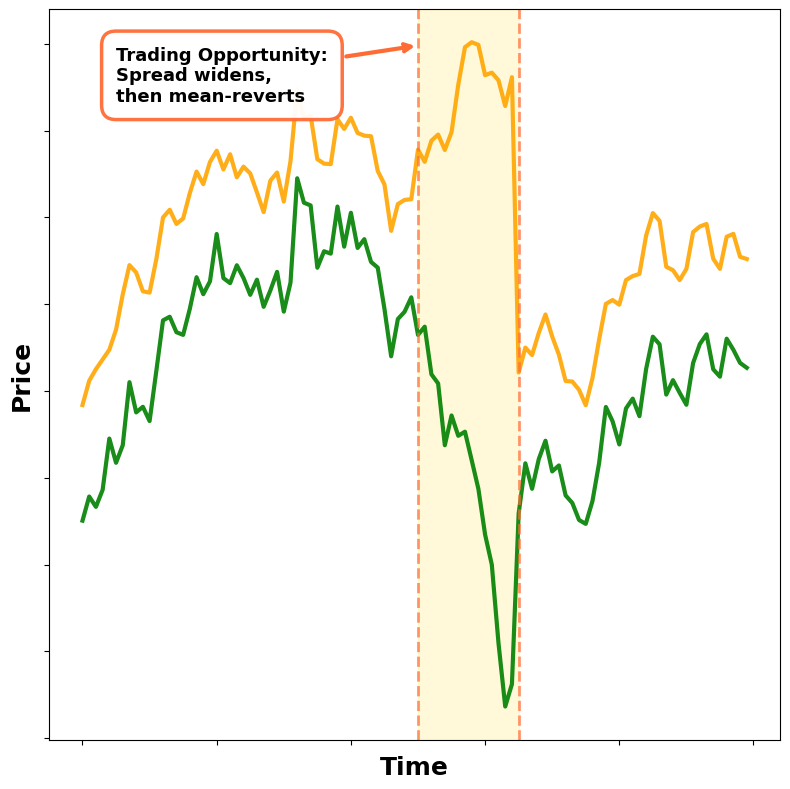


COINTEGRATION DEMONSTRATION

Optimal Hedge Ratio (β): 0.3272
Spread Mean: 71.0647
Spread Std Dev: 1.9712

Key Insight:
  - Both assets follow a common long-term trend (non-stationary)
  - Their spread is mean-reverting (stationary)
  - Trading opportunity: Buy spread when below mean, sell when above


In [34]:
# Generate synthetic cointegrated price series for demonstration
np.random.seed(32)
n_points = 100

# Generate common stochastic trend
common_trend = np.cumsum(np.random.randn(n_points)) * 0.5

# Asset 1: Price follows common trend + small idiosyncratic noise
noise1 = np.random.randn(n_points) * 0.1
price1 = 100 + common_trend + noise1

# Asset 2: Price follows common trend (with slight coefficient) + small idiosyncratic noise
noise2 = np.random.randn(n_points) * 0.3
price2 = 97 + 1.1 * common_trend + noise2

# Create temporary divergence in spread between time 200-300
divergence_window = slice(50, 65)
price1[divergence_window] += np.linspace(1, 6, 15)  # Asset 1 increases more
price2[divergence_window] -= np.linspace(0, 5, 15)  # Asset 2 decreases slightly

# Calculate the spread (linear combination)
# Optimal hedge ratio from simple regression
beta = np.cov(price1, price2)[0, 1] / np.var(price2)
spread = price1 - beta * price2

# Create time axis
time_days = np.arange(n_points)

# Create simplified cointegration plot - prices only
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot price series
ax.plot(time_days, price1, label='Asset 1', color='orange', linewidth=3, alpha=0.9)
ax.plot(time_days, price2, label='Asset 2', color='green', linewidth=3, alpha=0.9)

# Highlight the divergence period (200-300)
ax.axvspan(50, 65, alpha=0.15, color='#FFD700', label='Spread Divergence Period')

# Add vertical lines to mark the divergence window
ax.axvline(x=50, color='#FF6B35', linestyle='--', linewidth=2, alpha=0.7)
ax.axvline(x=65, color='#FF6B35', linestyle='--', linewidth=2, alpha=0.7)

ax.set_xlabel('Time', fontsize=18, fontweight='bold')
ax.set_ylabel('Price', fontsize=18, fontweight='bold')

# Add annotation with arrow pointing to beginning of divergence period (straight line)
y_top = ax.get_ylim()[1]
y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
y_position = y_top - 0.05 * y_range  # 3% from top
ax.annotate('Trading Opportunity:\nSpread widens,\nthen mean-reverts', 
            xy=(50, y_position), 
            xytext=(5, y_position), 
            fontsize=13, fontweight='bold',
            verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='white', edgecolor='#FF6B35', linewidth=2.5, alpha=0.95),
            arrowprops=dict(arrowstyle='->', color='#FF6B35', lw=3))

# Remove axis tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.tight_layout()
plt.show()
plt.close(fig)

print("\n" + "="*70)
print("COINTEGRATION DEMONSTRATION")
print("="*70)
print(f"\nOptimal Hedge Ratio (β): {beta:.4f}")
print(f"Spread Mean: {spread.mean():.4f}")
print(f"Spread Std Dev: {spread.std():.4f}")
print("\nKey Insight:")
print("  - Both assets follow a common long-term trend (non-stationary)")
print("  - Their spread is mean-reverting (stationary)")
print("  - Trading opportunity: Buy spread when below mean, sell when above")
print("="*70)

## Perpetual Futures Contract Mechanics

This demonstration shows how perpetual futures (perp) prices interact with spot prices, with periodic funding rate payments.

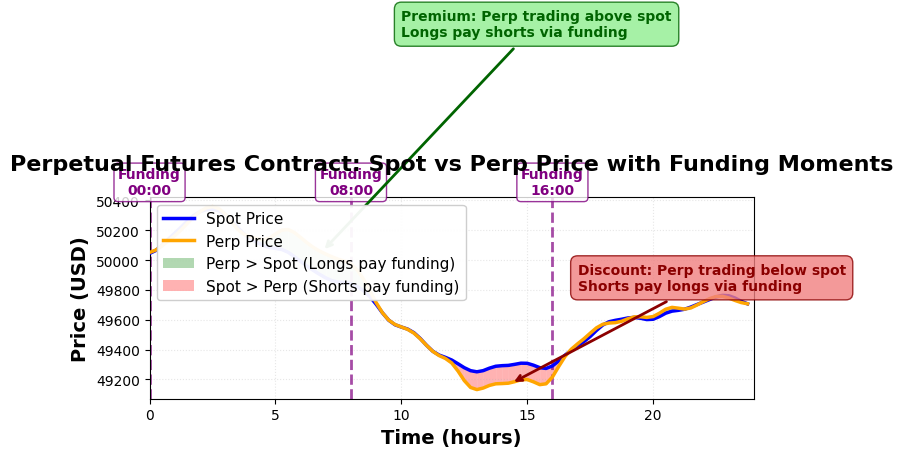


PERPETUAL FUTURES CONTRACT MECHANICS

Key Concepts:
----------------------------------------------------------------------
• Spot Price: The current market price of the underlying asset
• Perp Price: Price of the perpetual futures contract
• Funding Rate: Periodic payment between longs and shorts
• Funding Moments: Typically every 8 hours (00:00, 08:00, 16:00 UTC)

Funding Rate Mechanism:
----------------------------------------------------------------------
• GREEN AREA (Perp > Spot): Perp trades at PREMIUM
  → Longs pay shorts (to discourage long positions)
  → Brings perp price down toward spot

• RED AREA (Spot > Perp): Perp trades at DISCOUNT
  → Shorts pay longs (to discourage short positions)
  → Brings perp price up toward spot

Arbitrage Opportunity:
----------------------------------------------------------------------
• When perp > spot: Short perp, long spot → collect funding
• When spot > perp: Long perp, short spot → collect funding
• Funding keeps perp and spot prices c

In [35]:


# Generate time series (24 hours with 15-minute intervals)
num_points = 96  # 24 hours * 4 (15-min intervals)
time_index = np.arange(num_points)
hours = time_index / 4  # Convert to hours

# Create base price trend
np.random.seed(42)
base_price = 50000  # Starting price (e.g., BTC)

# Generate spot price with some random walk
spot_price = base_price + np.cumsum(np.random.randn(num_points) * 50)
spot_price = spot_price + 200 * np.sin(time_index / 12)  # Add some cyclical movement

# Generate perp price (mostly follows spot but with some deviation)
perp_price = spot_price + np.random.randn(num_points) * 30
# Add some periods where perp is systematically higher or lower
perp_price[20:35] += 150  # Period where perp trades at premium
perp_price[50:65] -= 120  # Period where perp trades at discount

spot_price = gaussian_filter1d(spot_price, sigma=1.5)
perp_price = gaussian_filter1d(perp_price, sigma=1.5)

# Define funding rate moments (every 8 hours = every 32 intervals)
funding_moments = [0, 32, 64, 96]  # 0h, 8h, 16h, 24h

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Fill areas between curves
for i in range(num_points - 1):
    if perp_price[i] > spot_price[i]:
        # Perp is higher - mark green (positive funding for longs)
        ax.fill_between([hours[i], hours[i+1]],
                        [spot_price[i], spot_price[i+1]], 
                        [perp_price[i], perp_price[i+1]], 
                        color='green', alpha=0.3, linewidth=0)
    else:
        # Spot is higher - mark red (negative funding for longs)
        ax.fill_between([hours[i], hours[i+1]], 
                        [perp_price[i], perp_price[i+1]], 
                        [spot_price[i], spot_price[i+1]], 
                        color='red', alpha=0.3, linewidth=0)

# Plot the price curves
ax.plot(hours, spot_price, color='blue', linewidth=2.5, label='Spot Price', zorder=3)
ax.plot(hours, perp_price, color='orange', linewidth=2.5, label='Perp Price', zorder=3)

# Mark funding moments with vertical lines
for funding_hour in [0, 8, 16]:
    ax.axvline(x=funding_hour, color='purple', linestyle='--', linewidth=2, 
               alpha=0.7, zorder=2)
    # Add text label
    ax.text(funding_hour, ax.get_ylim()[1], f'Funding\n{funding_hour:02d}:00', 
            ha='center', va='bottom', fontsize=10, color='purple', 
            fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', 
            facecolor='white', edgecolor='purple', alpha=0.8))

# Styling
ax.set_xlabel('Time (hours)', fontsize=14, fontweight='bold')
ax.set_ylabel('Price (USD)', fontsize=14, fontweight='bold')
ax.set_title('Perpetual Futures Contract: Spot vs Perp Price with Funding Moments', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=12, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax.set_xlim(0, 24)

legend_elements = [
    Patch(facecolor='green', alpha=0.3, label='Perp > Spot (Longs pay funding)'),
    Patch(facecolor='red', alpha=0.3, label='Spot > Perp (Shorts pay funding)')
]
ax.legend(handles=ax.get_legend_handles_labels()[0] + legend_elements, 
          loc='upper left', fontsize=11, framealpha=0.95)

# Add annotations explaining key concepts
ax.annotate('Premium: Perp trading above spot\nLongs pay shorts via funding',
            xy=(27.5/4, perp_price[27]), xytext=(10, 51500),
            arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2),
            fontsize=10, color='darkgreen', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', 
                     edgecolor='darkgreen', alpha=0.8))

ax.annotate('Discount: Perp trading below spot\nShorts pay longs via funding',
            xy=(57.5/4, perp_price[57]), xytext=(17, 49800),
            arrowprops=dict(arrowstyle='->', color='darkred', lw=2),
            fontsize=10, color='darkred', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', 
                     edgecolor='darkred', alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("PERPETUAL FUTURES CONTRACT MECHANICS")
print("="*70)
print("\nKey Concepts:")
print("-" * 70)
print("• Spot Price: The current market price of the underlying asset")
print("• Perp Price: Price of the perpetual futures contract")
print("• Funding Rate: Periodic payment between longs and shorts")
print("• Funding Moments: Typically every 8 hours (00:00, 08:00, 16:00 UTC)")
print("\nFunding Rate Mechanism:")
print("-" * 70)
print("• GREEN AREA (Perp > Spot): Perp trades at PREMIUM")
print("  → Longs pay shorts (to discourage long positions)")
print("  → Brings perp price down toward spot")
print("\n• RED AREA (Spot > Perp): Perp trades at DISCOUNT")
print("  → Shorts pay longs (to discourage short positions)")
print("  → Brings perp price up toward spot")
print("\nArbitrage Opportunity:")
print("-" * 70)
print("• When perp > spot: Short perp, long spot → collect funding")
print("• When spot > perp: Long perp, short spot → collect funding")
print("• Funding keeps perp and spot prices converged over time")
print("="*70)

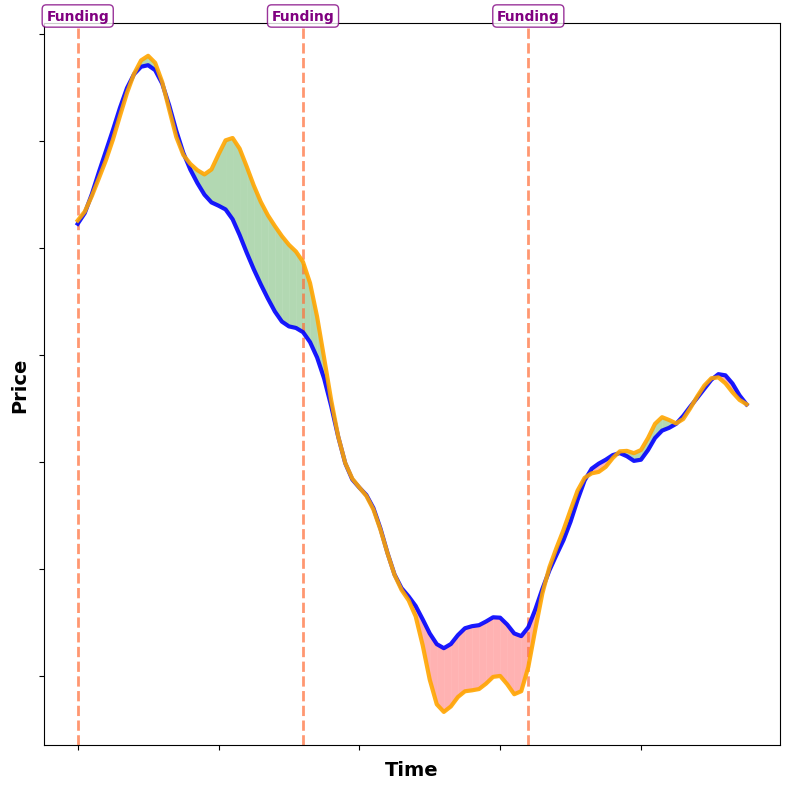


PERPETUAL FUTURES CONTRACT MECHANICS

Key Concepts:
----------------------------------------------------------------------
• Spot Price: The current market price of the underlying asset
• Perp Price: Price of the perpetual futures contract
• Funding Rate: Periodic payment between longs and shorts
• Funding Moments: Typically every 8 hours (00:00, 08:00, 16:00 UTC)

Funding Rate Mechanism:
----------------------------------------------------------------------
• GREEN AREA (Perp > Spot): Perp trades at PREMIUM
  → Longs pay shorts (to discourage long positions)
  → Brings perp price down toward spot

• RED AREA (Spot > Perp): Perp trades at DISCOUNT
  → Shorts pay longs (to discourage short positions)
  → Brings perp price up toward spot

Arbitrage Opportunity:
----------------------------------------------------------------------
• When perp > spot: Short perp, long spot → collect funding
• When spot > perp: Long perp, short spot → collect funding
• Funding keeps perp and spot prices c

In [36]:

# Generate time series (24 hours with 15-minute intervals)
num_points = 96  # 24 hours * 4 (15-min intervals)
time_index = np.arange(num_points)
hours = time_index / 4  # Convert to hours

# Create base price trend
np.random.seed(42)
base_price = 50000  # Starting price (e.g., BTC)

# Generate spot price with some random walk
spot_price = base_price + np.cumsum(np.random.randn(num_points) * 50)
spot_price = spot_price + 200 * np.sin(time_index / 12)  # Add some cyclical movement

# Generate perp price (mostly follows spot but with some deviation)
perp_price = spot_price + np.random.randn(num_points) * 30
# Add some periods where perp is systematically higher or lower
perp_price[20:35] += 150  # Period where perp trades at premium
perp_price[50:65] -= 120  # Period where perp trades at discount

# Smooth both curves slightly
spot_price = gaussian_filter1d(spot_price, sigma=1.5)
perp_price = gaussian_filter1d(perp_price, sigma=1.5)

# Define funding rate moments (every 8 hours = every 32 intervals)
funding_moments = [0, 32, 64, 96]  # 0h, 8h, 16h, 24h

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Fill areas between curves
for i in range(num_points - 1):
    if perp_price[i] > spot_price[i]:
        # Perp is higher - mark green (positive funding for longs)
        ax.fill_between([hours[i], hours[i+1]], 
                        [spot_price[i], spot_price[i+1]], 
                        [perp_price[i], perp_price[i+1]], 
                        color='green', alpha=0.3, linewidth=0)
    else:
        # Spot is higher - mark red (negative funding for longs)
        ax.fill_between([hours[i], hours[i+1]], 
                        [perp_price[i], perp_price[i+1]], 
                        [spot_price[i], spot_price[i+1]], 
                        color='red', alpha=0.3, linewidth=0)

# Plot the price curves
ax.plot(hours, spot_price, color='blue', linewidth=3, alpha=0.9, zorder=3)
ax.plot(hours, perp_price, color='orange', linewidth=3, alpha=0.9, zorder=3)

# Mark funding moments with vertical lines
for funding_hour in [0, 8, 16]:
    ax.axvline(x=funding_hour, color='#FF6B35', linestyle='--', linewidth=2, alpha=0.7, zorder=2)
    # Add text label
    ax.text(funding_hour, ax.get_ylim()[1], 'Funding', 
            ha='center', va='bottom', fontsize=10, color='purple', 
            fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', 
            facecolor='white', edgecolor='purple', alpha=0.8))

ax.set_xlabel('Time', fontsize=14, fontweight='bold')
ax.set_ylabel('Price', fontsize=14, fontweight='bold')

# Remove axis tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.tight_layout()
plt.show()
plt.close(fig)

# Print summary statistics
print("\n" + "="*70)
print("PERPETUAL FUTURES CONTRACT MECHANICS")
print("="*70)
print("\nKey Concepts:")
print("-" * 70)
print("• Spot Price: The current market price of the underlying asset")
print("• Perp Price: Price of the perpetual futures contract")
print("• Funding Rate: Periodic payment between longs and shorts")
print("• Funding Moments: Typically every 8 hours (00:00, 08:00, 16:00 UTC)")
print("\nFunding Rate Mechanism:")
print("-" * 70)
print("• GREEN AREA (Perp > Spot): Perp trades at PREMIUM")
print("  → Longs pay shorts (to discourage long positions)")
print("  → Brings perp price down toward spot")
print("\n• RED AREA (Spot > Perp): Perp trades at DISCOUNT")
print("  → Shorts pay longs (to discourage short positions)")
print("  → Brings perp price up toward spot")
print("\nArbitrage Opportunity:")
print("-" * 70)
print("• When perp > spot: Short perp, long spot → collect funding")
print("• When spot > perp: Long perp, short spot → collect funding")
print("• Funding keeps perp and spot prices converged over time")
print("="*70)

## PPO Agent Manager Class

This class provides a unified interface for training, fine-tuning, and inference with the PPO agent.

In [37]:
class PPOAgentManager:
    """
    Unified class for training, fine-tuning, and inference with PPO agent.
    
    Features:
    - Load raw CSV data and handle feature engineering
    - Train new models or fine-tune existing ones
    - Single timestep deterministic prediction
    - Automatic model saving/loading
    - Export predictions to JSON
    
    Example usage:
    ```python
    # Initialize manager
    manager = PPOAgentManager(config=CONFIG)
    
    # Train new model
    manager.train(
        csv_path="data/features.csv",
        train_period=["2024-01-01", "2024-06-30"],
        val_period=["2024-07-01", "2024-07-31"],
        timesteps=1000000
    )
    
    # Fine-tune on new data
    manager.fine_tune(
        csv_path="data/features_new.csv",
        model_path="models/best_model.zip",
        train_period=["2024-08-01", "2024-09-30"],
        timesteps=100000
    )
    
    # Predict single timestep
    result = manager.predict(
        csv_path="data/features_latest.csv",
        model_path="models/best_model.zip",
        timestamp="2024-10-01 12:00:00"
    )
    print(result)  # {"timestamp": "...", "action": 0.85, "confidence": 0.92}
    ```
    """
    
    def __init__(self, config: dict):
        """
        Initialize the PPO Agent Manager.
        
        Parameters
        ----------
        config : dict
            Configuration dictionary containing all settings
        """
        self.config = config
        self.model = None
        self.env = None
        self.feature_columns = None
        self.assets = None
        
    def _load_and_prepare_data(self, csv_path: str) -> tuple:
        """
        Load CSV data and prepare features.
        
        Parameters
        ----------
        csv_path : str
            Path to the CSV file containing features
            
        Returns
        -------
        tuple
            (features_df, X_tensor, R_tensor, VOL_tensor, timestamps, ticker_order)
        """
        print(f"Loading data from: {csv_path}")
        
        # Load CSV
        features_df = load_csv_to_df(
            csv_path,
            sep=self.config["DATA"]["features"].get("separator", ","),
            timestamp_index_col=self.config["DATA"]["features"]["index"]
        )
        
        print(f"Loaded {len(features_df)} rows with {len(features_df.columns)} columns")
        
        # Identify assets and features
        assets, single_features, pair_features, pairs = identify_assets_features_pairs(
            features_df,
            self.config["DATA"]["features"]["single_asset_format"],
            self.config["DATA"]["features"]["pair_feature_format"]
        )
        
        self.assets = sorted(list(assets))
        print(f"Detected {len(self.assets)} assets: {self.assets}")
        print(f"Single features: {sorted(single_features)}")
        print(f"Pair features: {sorted(pair_features)}")
        
        # Build state tensor
        X_tensor, R_tensor, VOL_tensor, timestamps, ticker_order = build_state_tensor_for_interval(
            features_df,
            self.assets,
            sorted(single_features),
            sorted(pair_features),
            lookback=self.config["ENV"]["lookback_window"]
        )
        
        print(f"Built tensors: X{X_tensor.shape}, R{R_tensor.shape}, VOL{VOL_tensor.shape}")
        print(f"Timestamps: {len(timestamps)} samples from {timestamps.min()} to {timestamps.max()}")
        
        return features_df, X_tensor, R_tensor, VOL_tensor, timestamps, ticker_order
    
    def _create_time_mask(self, timestamps: pd.DatetimeIndex, period: list) -> np.ndarray:
        """
        Create boolean mask for time period.
        
        Parameters
        ----------
        timestamps : pd.DatetimeIndex
            All available timestamps
        period : list
            [start_date, end_date] as strings
            
        Returns
        -------
        np.ndarray
            Boolean mask
        """
        start = pd.to_datetime(period[0]).tz_localize('UTC')
        end = pd.to_datetime(period[1]).tz_localize('UTC')
        
        # Ensure timestamps are UTC
        if timestamps.tz is None:
            timestamps = timestamps.tz_localize('UTC')
        elif timestamps.tz != pytz.UTC:
            timestamps = timestamps.tz_convert('UTC')
        
        mask = (timestamps >= start) & (timestamps <= end)
        print(f"Time mask: {mask.sum()} / {len(mask)} samples in period {period[0]} to {period[1]}")
        
        return mask
    
    def _create_env(self, X: np.ndarray, R: np.ndarray, VOL: np.ndarray, 
                    ticker_order: list, name: str = "env") -> gym.Env:
        """
        Create environment instance.
        
        Parameters
        ----------
        X, R, VOL : np.ndarray
            State tensors
        ticker_order : list
            List of asset tickers
        name : str
            Environment name for monitoring
            
        Returns
        -------
        gym.Env
            Wrapped environment
        """
        env = PortfolioWeightsEnvUtility(
            X, R, VOL, ticker_order,
            self.config["ENV"]["lookback_window"],
            self.config["ENV"]
        )
        env = Monitor(env, filename=None)
        return env
    
    def train(self, csv_path: str, train_period: list, val_period: list,
              timesteps: int = None, save_path: str = None) -> dict:
        """
        Train a new PPO model from scratch.
        
        Parameters
        ----------
        csv_path : str
            Path to CSV file with features
        train_period : list
            [start_date, end_date] for training
        val_period : list
            [start_date, end_date] for validation
        timesteps : int, optional
            Number of training timesteps (uses config if None)
        save_path : str, optional
            Where to save the model (uses config if None)
            
        Returns
        -------
        dict
            Training metrics and paths
        """
        print("\n" + "="*70)
        print("TRAINING NEW MODEL")
        print("="*70)
        
        # Load and prepare data
        _, X_all, R_all, VOL_all, timestamps, ticker_order = self._load_and_prepare_data(csv_path)
        
        # Create time masks
        train_mask = self._create_time_mask(timestamps, train_period)
        val_mask = self._create_time_mask(timestamps, val_period)
        
        # Slice data
        X_train = X_all[train_mask]
        R_train = R_all[train_mask]
        VOL_train = VOL_all[train_mask]
        
        X_val = X_all[val_mask]
        R_val = R_all[val_mask]
        VOL_val = VOL_all[val_mask]
        
        # Create environments
        train_env = self._create_env(X_train, R_train, VOL_train, ticker_order, "train")
        val_env = self._create_env(X_val, R_val, VOL_val, ticker_order, "val")
        
        vec_train = DummyVecEnv([lambda: train_env])
        vec_val = DummyVecEnv([lambda: val_env])
        
        # Create model
        print("\nInitializing PPO model...")
        self.model = PPO(
            policy=self.config["RL"]["policy"],
            env=vec_train,
            gamma=self.config["RL"]["gamma"],
            gae_lambda=self.config["RL"]["gae_lambda"],
            clip_range=self.config["RL"]["clip_range"],
            n_steps=self.config["RL"]["n_steps"],
            batch_size=self.config["RL"]["batch_size"],
            learning_rate=self.config["RL"]["learning_rate"],
            ent_coef=self.config["RL"]["ent_coef"],
            vf_coef=self.config["RL"]["vf_coef"],
            max_grad_norm=self.config["RL"]["max_grad_norm"],
            tensorboard_log=self.config["IO"]["tb_logdir"],
            device="cpu",
            verbose=0
        )
        
        # Setup callbacks
        save_path = save_path or self.config["IO"]["models_dir"]
        ensure_dir(save_path)
        
        eval_callback = EvalCallback(
            vec_val,
            best_model_save_path=save_path,
            log_path=save_path,
            eval_freq=self.config["EVAL"]["frequency"],
            n_eval_episodes=self.config["EVAL"]["n_eval_episodes"],
            deterministic=True,
            render=False,
            verbose=0
        )
        
        # Train
        timesteps = timesteps or int(self.config["RL"]["timesteps"])
        print(f"\nStarting training for {timesteps:,} timesteps...")
        print("Monitor progress: tensorboard --logdir=./tb_logs\n")
        
        self.model.learn(total_timesteps=timesteps, callback=eval_callback, progress_bar=True)
        
        # Save final model
        final_path = os.path.join(save_path, "final_model.zip")
        self.model.save(final_path)
        print(f"\n✓ Training complete! Model saved to: {final_path}")
        
        return {
            "final_model_path": final_path,
            "best_model_path": os.path.join(save_path, "best_model.zip"),
            "timesteps": timesteps,
            "train_period": train_period,
            "val_period": val_period
        }
    
    def fine_tune(self, csv_path: str, model_path: str, train_period: list,
                  val_period: list = None, timesteps: int = None, 
                  save_path: str = None) -> dict:
        """
        Fine-tune an existing model on new data (transfer learning).
        
        Parameters
        ----------
        csv_path : str
            Path to CSV file with new features
        model_path : str
            Path to pre-trained model
        train_period : list
            [start_date, end_date] for fine-tuning
        val_period : list, optional
            [start_date, end_date] for validation
        timesteps : int, optional
            Number of fine-tuning timesteps (default: 10% of original training)
        save_path : str, optional
            Where to save fine-tuned model
            
        Returns
        -------
        dict
            Fine-tuning metrics and paths
        """
        print("\n" + "="*70)
        print("FINE-TUNING EXISTING MODEL")
        print("="*70)
        
        # Load pre-trained model
        print(f"Loading pre-trained model from: {model_path}")
        self.model = PPO.load(model_path)
        
        # Load and prepare new data
        _, X_all, R_all, VOL_all, timestamps, ticker_order = self._load_and_prepare_data(csv_path)
        
        # Create time masks
        train_mask = self._create_time_mask(timestamps, train_period)
        
        # Slice data
        X_train = X_all[train_mask]
        R_train = R_all[train_mask]
        VOL_train = VOL_all[train_mask]
        
        # Create training environment
        train_env = self._create_env(X_train, R_train, VOL_train, ticker_order, "finetune_train")
        vec_train = DummyVecEnv([lambda: train_env])
        
        # Update model's environment
        self.model.set_env(vec_train)
        
        # Setup validation if provided
        vec_val = None
        if val_period:
            val_mask = self._create_time_mask(timestamps, val_period)
            X_val = X_all[val_mask]
            R_val = R_all[val_mask]
            VOL_val = VOL_all[val_mask]
            val_env = self._create_env(X_val, R_val, VOL_val, ticker_order, "finetune_val")
            vec_val = DummyVecEnv([lambda: val_env])
        
        # Setup callbacks
        save_path = save_path or self.config["IO"]["models_dir"]
        ensure_dir(save_path)
        
        callbacks = []
        if vec_val:
            eval_callback = EvalCallback(
                vec_val,
                best_model_save_path=save_path,
                log_path=save_path,
                eval_freq=self.config["EVAL"]["frequency"],
                n_eval_episodes=self.config["EVAL"]["n_eval_episodes"],
                deterministic=True,
                render=False,
                verbose=0
            )
            callbacks.append(eval_callback)
        
        # Fine-tune
        timesteps = timesteps or int(self.config["RL"]["timesteps"] * 0.1)  # 10% of original
        print(f"\nFine-tuning for {timesteps:,} timesteps...")
        
        callback = CallbackList(callbacks) if callbacks else None
        self.model.learn(total_timesteps=timesteps, callback=callback, progress_bar=True, reset_num_timesteps=False)
        
        # Save fine-tuned model
        finetuned_path = os.path.join(save_path, "finetuned_model.zip")
        self.model.save(finetuned_path)
        print(f"\n✓ Fine-tuning complete! Model saved to: {finetuned_path}")
        
        return {
            "finetuned_model_path": finetuned_path,
            "timesteps": timesteps,
            "train_period": train_period,
            "val_period": val_period
        }
    
    def predict(self, csv_path: str, model_path: str, timestamp: str,
                output_json: str = None) -> dict:
        """
        Predict action for a single timestep (deterministic).
        
        Parameters
        ----------
        csv_path : str
            Path to CSV file with features
        model_path : str
            Path to trained model
        timestamp : str
            Timestamp for prediction (e.g., "2024-10-01 12:00:00")
        output_json : str, optional
            Path to save prediction as JSON
            
        Returns
        -------
        dict
            Prediction result with timestamp, action, and metadata
        """
        print("\n" + "="*70)
        print("SINGLE TIMESTEP PREDICTION")
        print("="*70)
        
        # Load model
        if self.model is None or model_path:
            print(f"Loading model from: {model_path}")
            self.model = PPO.load(model_path)
        
        # Load and prepare data
        features_df, X_all, R_all, VOL_all, timestamps, ticker_order = self._load_and_prepare_data(csv_path)
        
        # Find the timestamp
        target_time = pd.to_datetime(timestamp).tz_localize('UTC') if pd.to_datetime(timestamp).tz is None else pd.to_datetime(timestamp)
        
        if timestamps.tz is None:
            timestamps = timestamps.tz_localize('UTC')
        elif timestamps.tz != pytz.UTC:
            timestamps = timestamps.tz_convert('UTC')
        
        # Find closest timestamp
        time_diffs = np.abs((timestamps - target_time).total_seconds())
        idx = np.argmin(time_diffs)
        actual_time = timestamps[idx]
        
        if time_diffs[idx] > 3600:  # More than 1 hour difference
            print(f"⚠ Warning: Requested time {timestamp} not found exactly.")
            print(f"  Using closest timestamp: {actual_time} (diff: {time_diffs[idx]/60:.1f} minutes)")
        else:
            print(f"✓ Found timestamp: {actual_time}")
        
        # Get state
        state = X_all[idx]
        
        # Predict (deterministic)
        action, _states = self.model.predict(state, deterministic=True)
        action_value = float(action[0]) if isinstance(action, np.ndarray) else float(action)
        
        # Get additional context
        returns = R_all[idx]
        volatility = VOL_all[idx]
        
        # Build result
        result = {
            "timestamp": str(actual_time),
            "requested_timestamp": timestamp,
            "action": action_value,
            "model_path": model_path,
            "assets": ticker_order,
            "returns": returns.tolist() if isinstance(returns, np.ndarray) else [float(returns)],
            "volatility": volatility.tolist() if isinstance(volatility, np.ndarray) else [float(volatility)],
            "state_shape": list(state.shape),
            "prediction_time": datetime.now().isoformat()
        }
        
        # Save to JSON if requested
        if output_json:
            ensure_dir(os.path.dirname(output_json))
            with open(output_json, 'w') as f:
                json.dump(result, f, indent=2)
            print(f"✓ Prediction saved to: {output_json}")
        
        print("\n📊 Prediction Result:")
        print(f"   Action: {action_value:+.4f}")
        print(f"   Assets: {', '.join(ticker_order)}")
        
        return result
    
    def batch_predict(self, csv_path: str, model_path: str, 
                     start_time: str, end_time: str,
                     output_json: str = None) -> list:
        """
        Predict actions for multiple timesteps.
        
        Parameters
        ----------
        csv_path : str
            Path to CSV file with features
        model_path : str
            Path to trained model
        start_time, end_time : str
            Time range for predictions
        output_json : str, optional
            Path to save predictions as JSON
            
        Returns
        -------
        list
            List of prediction dictionaries
        """
        print("\n" + "="*70)
        print("BATCH PREDICTION")
        print("="*70)
        
        # Load model
        if self.model is None or model_path:
            print(f"Loading model from: {model_path}")
            self.model = PPO.load(model_path)
        
        # Load and prepare data
        _, X_all, R_all, VOL_all, timestamps, ticker_order = self._load_and_prepare_data(csv_path)
        
        # Create time mask
        period = [start_time, end_time]
        time_mask = self._create_time_mask(timestamps, period)
        
        # Get indices
        indices = np.where(time_mask)[0]
        print(f"Predicting for {len(indices)} timesteps...")
        
        results = []
        for idx in indices:
            state = X_all[idx]
            action, _ = self.model.predict(state, deterministic=True)
            action_value = float(action[0]) if isinstance(action, np.ndarray) else float(action)
            
            result = {
                "timestamp": str(timestamps[idx]),
                "action": action_value,
                "returns": R_all[idx].tolist() if isinstance(R_all[idx], np.ndarray) else [float(R_all[idx])],
                "volatility": VOL_all[idx].tolist() if isinstance(VOL_all[idx], np.ndarray) else [float(VOL_all[idx])]
            }
            results.append(result)
        
        # Save to JSON if requested
        if output_json:
            ensure_dir(os.path.dirname(output_json))
            output = {
                "model_path": model_path,
                "period": period,
                "assets": ticker_order,
                "num_predictions": len(results),
                "predictions": results
            }
            with open(output_json, 'w') as f:
                json.dump(output, f, indent=2)
            print(f"✓ Batch predictions saved to: {output_json}")
        
        return results

print("✓ PPOAgentManager class defined successfully!")

✓ PPOAgentManager class defined successfully!


## Example Usage: PPOAgentManager

Here are examples of how to use the PPOAgentManager class for training, fine-tuning, and inference.

In [38]:
# Example 1: Train a new model from scratch
# Uncomment to run

# manager = PPOAgentManager(config=CONFIG)
# 
# training_result = manager.train(
#     csv_path=os.path.join(CONFIG["DATA"]["cache_dir"], f"{CONFIG['DATA']['features']['file_name']}.csv"),
#     train_period=["2024-07-01 00:00:00", "2024-12-31 23:59:59"],
#     val_period=["2025-01-01 00:00:00", "2025-01-31 23:59:59"],
#     timesteps=500000,  # Shorter for example
#     save_path="./models/example"
# )
# 
# print("\nTraining Result:")
# print(json.dumps(training_result, indent=2))

In [39]:
# Example 2: Fine-tune an existing model on new data (transfer learning)
# Uncomment to run

# manager = PPOAgentManager(config=CONFIG)
# 
# finetune_result = manager.fine_tune(
#     csv_path=os.path.join(CONFIG["DATA"]["cache_dir"], f"{CONFIG['DATA']['features']['file_name']}.csv"),
#     model_path="./models/best_model.zip",  # Path to pre-trained model
#     train_period=["2025-02-01 00:00:00", "2025-02-28 23:59:59"],
#     val_period=["2025-03-01 00:00:00", "2025-03-15 23:59:59"],
#     timesteps=100000,  # Fewer timesteps for fine-tuning
#     save_path="./models/finetuned"
# )
# 
# print("\nFine-tuning Result:")
# print(json.dumps(finetune_result, indent=2))

In [40]:
# Example 3: Single timestep prediction (deterministic)
# Uncomment to run

# manager = PPOAgentManager(config=CONFIG)
# 
# prediction = manager.predict(
#     csv_path=os.path.join(CONFIG["DATA"]["cache_dir"], f"{CONFIG['DATA']['features']['file_name']}.csv"),
#     model_path="./models/best_model.zip",
#     timestamp="2025-03-15 12:00:00",
#     output_json="./predictions/single_prediction.json"
# )
# 
# print("\nPrediction Result:")
# print(json.dumps(prediction, indent=2))

In [41]:
# Example 4: Batch predictions for a time period
# Uncomment to run

# manager = PPOAgentManager(config=CONFIG)
# 
# batch_predictions = manager.batch_predict(
#     csv_path=os.path.join(CONFIG["DATA"]["cache_dir"], f"{CONFIG['DATA']['features']['file_name']}.csv"),
#     model_path="./models/best_model.zip",
#     start_time="2025-03-01 00:00:00",
#     end_time="2025-03-07 23:59:59",
#     output_json="./predictions/batch_predictions.json"
# )
# 
# print(f"\nBatch Predictions: {len(batch_predictions)} timesteps")
# print("\nFirst 3 predictions:")
# for pred in batch_predictions[:3]:
#     print(f"  {pred['timestamp']}: action={pred['action']:+.4f}")